In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Colab Notebooks/'

Mounted at /content/drive


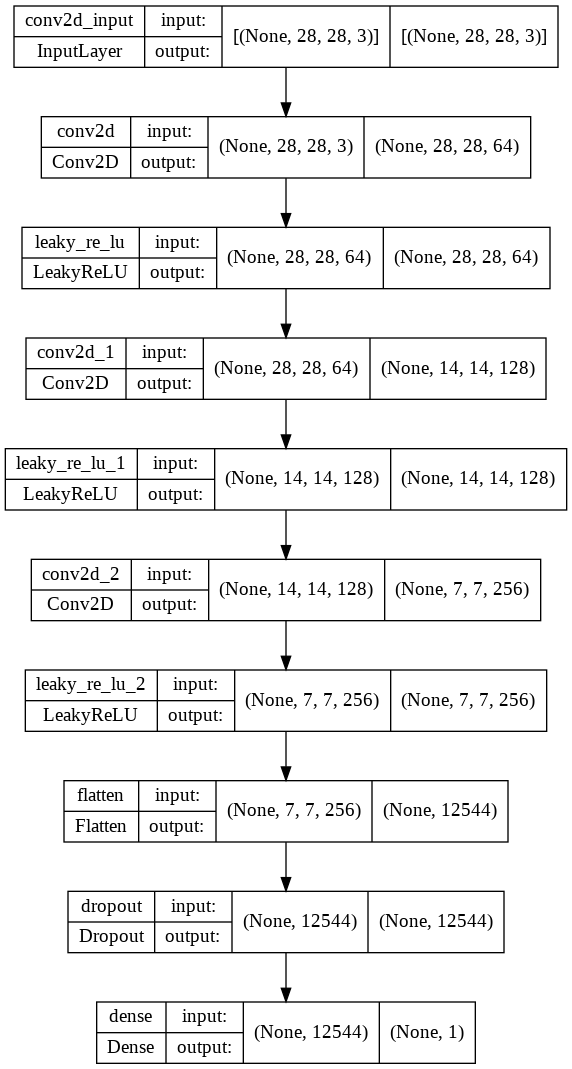

In [3]:
# Building the discriminator model
def build_discriminator(img_shape=(28, 28, 3)):
    model = Sequential()
    # Start with 28x28 image
    model.add(Conv2D(64, (3,3), padding='same', input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.2))
    # Downsample to 14x14
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # Downsample to 7x7
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # Binary classifier
    model.add(Flatten())
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    # Compile discriminator model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])

    return model

# Build, compile and display a summary of the discriminator
discriminator = build_discriminator()
plot_model(discriminator, show_shapes=True, show_layer_names=True)

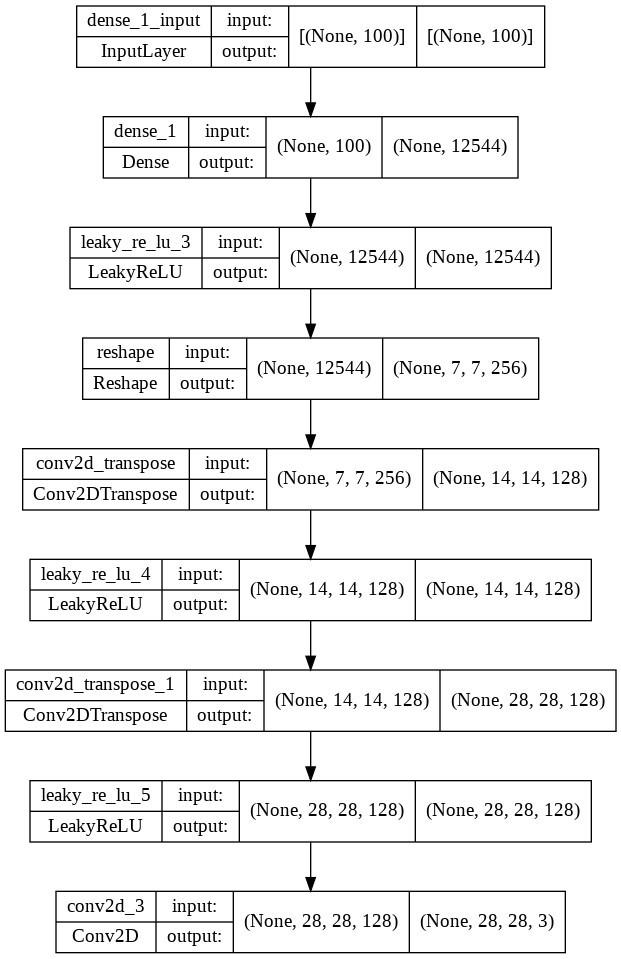

In [4]:
# Building the generator model
def build_generator(latent_dim):
    model = Sequential()
    # Start with 7x7 image
    model.add(Dense(256*7*7, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 256)))
    # Upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # Upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # Output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))

    return model

# Size of the latent space
latent_dim = 100
# Build and display a summary of the discriminator
generator = build_generator(latent_dim)
plot_model(generator, show_shapes=True, show_layer_names=True)

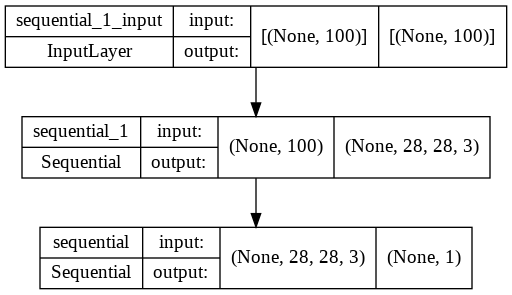

In [5]:
# Building the GAN model which combines the discriminator and generator models
def define_gan(generator, discriminator):
    # Set the weights in the discriminator to not trainable
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    # Compile combined GAN model
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

    return model

# Build and display a summary of the GAN
gan_model = define_gan(generator, discriminator)
plot_model(gan_model, show_shapes=True, show_layer_names=True)

In [6]:
# Load and return the training data
def load_training_data():
    train_x = np.load(path + 'train_x10000x28.npy', allow_pickle=True)

    # Converting image data from doubles to floats
    train_x = train_x.astype('float32')
    # Scale from [0, 255] to [-1, 1]
    train_x = (train_x - 127.5) / 127.5

    return train_x

In [7]:
# Select random images from training data
def select_real_samples(train_x, n_samples):
    # Choose n_samples amount of random indexes
    random_indexes = np.random.randint(0, train_x.shape[0], n_samples)
    # Select the images from the training data
    real_samples_x = train_x[random_indexes]
    # Label '1' for each image to signify that it is real
    real_samples_y = np.ones((n_samples, 1))

    return real_samples_x, real_samples_y

In [8]:
# Generate random points in the latent space
def generate_latent_points(latent_dim, n_samples):
    # Choose n_samples amount of random points in the latent space
    fake_x_input = np.random.randn(latent_dim * n_samples)
    # Reshape into batches of inputs for the model
    fake_x_input = fake_x_input.reshape(n_samples, latent_dim)

    return fake_x_input

In [9]:
# Generate fake images using random points in the latent space
def generate_fake_samples(generator, latent_dim, n_samples):
    # Generate random points in the latent space
    fake_x_input = generate_latent_points(latent_dim, n_samples)
    # Generate fake images
    fake_x = generator.predict(fake_x_input)
    # Label '0' for each image to signify that it is fake
    fake_y = np.zeros((n_samples, 1))

    return fake_x, fake_y

In [10]:
# Display and save a plot of n^2 generated images
def plot_gen_imgs(generated_imgs, epoch, n=4):
    # Scale from [-1, 1] to [0, 1] for displaying images
    generated_imgs = (generated_imgs + 1) / 2.0

    # Plot generated images in a grid
    fig, ax = plt.subplots(n, n, figsize=(2, 2))
    count = 0
    for i in range(n):
        for j in range(n):
            ax[i, j].imshow(generated_imgs[count])
            ax[i, j].axis('off')
            count += 1
    
    # Save the plot of generated images
    plt.savefig(path + '/GAN for 28x28 Output/generated_images_epoch_%d.jpg' % 
                (epoch+1), bbox_inches='tight', dpi = 200)
    plt.close()

In [11]:
# Save the generator model
def save_generator(generator, epoch):
    generator.save(path  + '/GAN for 28x28 Output/generator_model_epoch_%d.h5' % 
                   (epoch+1))

In [12]:
losses = []
accuracies = []
epochs = []

# Periodic evaluation of the model
def evaluate_gan(epoch, generator, discriminator, train_x, latent_dim, n_samples=150):
    # Evaluate discriminator on real images
    real_x, real_y = select_real_samples(train_x, n_samples)
    _, d_acc_real = discriminator.evaluate(real_x, real_y, verbose=0)

    # Evaluate discriminator on fake images
    fake_x, fake_y = generate_fake_samples(generator, latent_dim, n_samples)
    _, d_acc_fake = discriminator.evaluate(fake_x, fake_y, verbose=0)

    print('\nDiscriminator Accuracy (Real Data): %.0f%%, Discriminator Accuracy (Fake Data): %.0f%%\n' % 
          (d_acc_real*100, d_acc_fake*100))
    
    plot_gen_imgs(fake_x, epoch)
    save_generator(generator, epoch)

In [13]:
# Display and save plots to show discriminator loss and accuracy throughout training
def plot_loss_and_accuracy(losses, accuracies, epochs):
    losses = np.array(losses)
    accuracies = np.array(accuracies)
    epochs = np.array(epochs)

    # Plot training losses for Discriminator
    plt.figure(figsize=(15, 5))
    plt.plot(epochs, losses.T[0], label='Discriminator Loss (Real Data)')
    plt.plot(epochs, losses.T[1], label='Discriminator Loss (Fake Data)')

    # Calculate line of best fit
    a0, a1 = np.polyfit(epochs, losses.T[0], 1)
    b0, b1 = np.polyfit(epochs, losses.T[1], 1)

    # Plot line of best fit
    plt.plot(epochs, a0*epochs + a1, color='blue', linestyle='dashed', 
              label='Line of best fit Discriminator Loss (Real Data)')
    plt.plot(epochs, b0*epochs + b1, color='red', linestyle='dashed', 
              label='Line of best fit Discriminator Loss (Fake Data)')

    # Configure and save plot
    plt.xticks(np.arange(0, np.max(epochs) + 1, epochs.shape[0] / 20))
    plt.title('Discriminator Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Values')
    plt.xlim([0, np.max(epochs) + 1])
    plt.ylim()
    plt.legend()
    plt.savefig(path + '/GAN for 28x28 Output/discriminator_loss_plot.jpg', 
                bbox_inches='tight')


    # Plot training accuracies for Discriminator
    plt.figure(figsize=(15, 5))
    plt.plot(epochs, accuracies.T[0], label='Discriminator Accuracy (Real Data)')
    plt.plot(epochs, accuracies.T[1], label='Discriminator Accuracy (Fake Data)')

    # Calculate line of best fit
    c0, c1 = np.polyfit(epochs, accuracies.T[0], 1)
    d0, d1 = np.polyfit(epochs, accuracies.T[1], 1)

    # Plot line of best fit
    plt.plot(epochs, c0*epochs + c1, color='blue', linestyle='dashed', 
              label='Line of best fit (Real Data)')
    plt.plot(epochs, d0*epochs + d1, color='red', linestyle='dashed', 
              label='Line of best fit (Fake Data)')

    # Configure and save plot
    plt.xticks(np.arange(0, np.max(epochs) + 1, epochs.shape[0] / 20))
    plt.title('Discriminator Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy Values (%)')
    plt.xlim([0, np.max(epochs) + 1])
    plt.ylim([0, 110])
    plt.legend()
    plt.savefig(path + '/GAN for 28x28 Output/discriminator_accuracy_plot.jpg', 
                bbox_inches='tight')

Epoch 1/1000: 100%|██████████| 78/78 [00:20<00:00,  3.77it/s]


Discriminator Loss (Real Data): 0.547, Discriminator Loss (Fake Data): 0.654, Generator Loss: 0.877


Epoch 2/1000: 100%|██████████| 78/78 [00:08<00:00,  8.80it/s]


Discriminator Loss (Real Data): 0.067, Discriminator Loss (Fake Data): 0.078, Generator Loss: 3.432


Epoch 3/1000: 100%|██████████| 78/78 [00:09<00:00,  8.18it/s]


Discriminator Loss (Real Data): 0.078, Discriminator Loss (Fake Data): 0.061, Generator Loss: 4.123


Epoch 4/1000: 100%|██████████| 78/78 [00:09<00:00,  8.62it/s]


Discriminator Loss (Real Data): 0.689, Discriminator Loss (Fake Data): 0.721, Generator Loss: 1.558


Epoch 5/1000: 100%|██████████| 78/78 [00:08<00:00,  8.80it/s]


Discriminator Loss (Real Data): 0.617, Discriminator Loss (Fake Data): 0.665, Generator Loss: 0.915


Epoch 6/1000: 100%|██████████| 78/78 [00:08<00:00,  8.83it/s]


Discriminator Loss (Real Data): 0.635, Discriminator Loss (Fake Data): 0.654, Generator Loss: 0.938


Epoch 7/1000: 100%|██████████| 78/78 [00:08<00:00,  8.99it/s]


Discriminator Loss (Real Data): 0.623, Discriminator Loss (Fake Data): 0.665, Generator Loss: 0.886


Epoch 8/1000: 100%|██████████| 78/78 [00:08<00:00,  9.02it/s]


Discriminator Loss (Real Data): 0.673, Discriminator Loss (Fake Data): 0.667, Generator Loss: 0.863


Epoch 9/1000: 100%|██████████| 78/78 [00:09<00:00,  8.34it/s]


Discriminator Loss (Real Data): 0.600, Discriminator Loss (Fake Data): 0.682, Generator Loss: 0.880


Epoch 10/1000: 100%|██████████| 78/78 [00:08<00:00,  8.90it/s]


Discriminator Loss (Real Data): 0.653, Discriminator Loss (Fake Data): 0.639, Generator Loss: 0.918

Discriminator Accuracy (Real Data): 59%, Discriminator Accuracy (Fake Data): 99%



Epoch 11/1000: 100%|██████████| 78/78 [00:08<00:00,  8.91it/s]


Discriminator Loss (Real Data): 0.662, Discriminator Loss (Fake Data): 0.632, Generator Loss: 0.901


Epoch 12/1000: 100%|██████████| 78/78 [00:08<00:00,  8.74it/s]


Discriminator Loss (Real Data): 0.598, Discriminator Loss (Fake Data): 0.635, Generator Loss: 0.912


Epoch 13/1000: 100%|██████████| 78/78 [00:08<00:00,  8.81it/s]


Discriminator Loss (Real Data): 0.585, Discriminator Loss (Fake Data): 0.620, Generator Loss: 0.949


Epoch 14/1000: 100%|██████████| 78/78 [00:08<00:00,  8.95it/s]


Discriminator Loss (Real Data): 0.629, Discriminator Loss (Fake Data): 0.652, Generator Loss: 0.911


Epoch 15/1000: 100%|██████████| 78/78 [00:08<00:00,  8.79it/s]


Discriminator Loss (Real Data): 0.588, Discriminator Loss (Fake Data): 0.636, Generator Loss: 0.986


Epoch 16/1000: 100%|██████████| 78/78 [00:08<00:00,  8.92it/s]


Discriminator Loss (Real Data): 0.584, Discriminator Loss (Fake Data): 0.598, Generator Loss: 0.971


Epoch 17/1000: 100%|██████████| 78/78 [00:08<00:00,  8.76it/s]


Discriminator Loss (Real Data): 0.596, Discriminator Loss (Fake Data): 0.587, Generator Loss: 1.054


Epoch 18/1000: 100%|██████████| 78/78 [00:08<00:00,  8.96it/s]


Discriminator Loss (Real Data): 0.585, Discriminator Loss (Fake Data): 0.673, Generator Loss: 0.944


Epoch 19/1000: 100%|██████████| 78/78 [00:08<00:00,  8.91it/s]


Discriminator Loss (Real Data): 0.547, Discriminator Loss (Fake Data): 0.656, Generator Loss: 0.986


Epoch 20/1000: 100%|██████████| 78/78 [00:08<00:00,  8.94it/s]


Discriminator Loss (Real Data): 0.615, Discriminator Loss (Fake Data): 0.598, Generator Loss: 0.980

Discriminator Accuracy (Real Data): 77%, Discriminator Accuracy (Fake Data): 87%



Epoch 21/1000: 100%|██████████| 78/78 [00:09<00:00,  8.31it/s]


Discriminator Loss (Real Data): 0.607, Discriminator Loss (Fake Data): 0.584, Generator Loss: 1.017


Epoch 22/1000: 100%|██████████| 78/78 [00:08<00:00,  8.80it/s]


Discriminator Loss (Real Data): 0.513, Discriminator Loss (Fake Data): 0.565, Generator Loss: 1.106


Epoch 23/1000: 100%|██████████| 78/78 [00:08<00:00,  8.69it/s]


Discriminator Loss (Real Data): 0.627, Discriminator Loss (Fake Data): 0.485, Generator Loss: 1.202


Epoch 24/1000: 100%|██████████| 78/78 [00:09<00:00,  8.37it/s]


Discriminator Loss (Real Data): 0.534, Discriminator Loss (Fake Data): 0.564, Generator Loss: 1.133


Epoch 25/1000: 100%|██████████| 78/78 [00:08<00:00,  8.75it/s]


Discriminator Loss (Real Data): 0.493, Discriminator Loss (Fake Data): 0.566, Generator Loss: 1.057


Epoch 26/1000: 100%|██████████| 78/78 [00:08<00:00,  8.84it/s]


Discriminator Loss (Real Data): 0.599, Discriminator Loss (Fake Data): 0.514, Generator Loss: 1.109


Epoch 27/1000: 100%|██████████| 78/78 [00:08<00:00,  8.84it/s]


Discriminator Loss (Real Data): 0.589, Discriminator Loss (Fake Data): 0.585, Generator Loss: 1.096


Epoch 28/1000: 100%|██████████| 78/78 [00:08<00:00,  8.74it/s]


Discriminator Loss (Real Data): 0.513, Discriminator Loss (Fake Data): 0.590, Generator Loss: 1.157


Epoch 29/1000: 100%|██████████| 78/78 [00:08<00:00,  8.82it/s]


Discriminator Loss (Real Data): 0.618, Discriminator Loss (Fake Data): 0.643, Generator Loss: 1.155


Epoch 30/1000: 100%|██████████| 78/78 [00:08<00:00,  8.82it/s]


Discriminator Loss (Real Data): 0.536, Discriminator Loss (Fake Data): 0.659, Generator Loss: 1.231

Discriminator Accuracy (Real Data): 72%, Discriminator Accuracy (Fake Data): 99%



Epoch 31/1000: 100%|██████████| 78/78 [00:09<00:00,  8.43it/s]


Discriminator Loss (Real Data): 0.568, Discriminator Loss (Fake Data): 0.587, Generator Loss: 1.214


Epoch 32/1000: 100%|██████████| 78/78 [00:08<00:00,  8.84it/s]


Discriminator Loss (Real Data): 0.562, Discriminator Loss (Fake Data): 0.614, Generator Loss: 1.198


Epoch 33/1000: 100%|██████████| 78/78 [00:08<00:00,  8.89it/s]


Discriminator Loss (Real Data): 0.558, Discriminator Loss (Fake Data): 0.627, Generator Loss: 1.188


Epoch 34/1000: 100%|██████████| 78/78 [00:08<00:00,  8.78it/s]


Discriminator Loss (Real Data): 0.620, Discriminator Loss (Fake Data): 0.520, Generator Loss: 1.148


Epoch 35/1000: 100%|██████████| 78/78 [00:08<00:00,  8.87it/s]


Discriminator Loss (Real Data): 0.514, Discriminator Loss (Fake Data): 0.493, Generator Loss: 1.209


Epoch 36/1000: 100%|██████████| 78/78 [00:08<00:00,  8.92it/s]


Discriminator Loss (Real Data): 0.616, Discriminator Loss (Fake Data): 0.520, Generator Loss: 1.214


Epoch 37/1000: 100%|██████████| 78/78 [00:09<00:00,  8.61it/s]


Discriminator Loss (Real Data): 0.562, Discriminator Loss (Fake Data): 0.535, Generator Loss: 1.225


Epoch 38/1000: 100%|██████████| 78/78 [00:08<00:00,  8.69it/s]


Discriminator Loss (Real Data): 0.484, Discriminator Loss (Fake Data): 0.532, Generator Loss: 1.235


Epoch 39/1000: 100%|██████████| 78/78 [00:08<00:00,  8.94it/s]


Discriminator Loss (Real Data): 0.617, Discriminator Loss (Fake Data): 0.586, Generator Loss: 1.306


Epoch 40/1000: 100%|██████████| 78/78 [00:09<00:00,  8.64it/s]


Discriminator Loss (Real Data): 0.472, Discriminator Loss (Fake Data): 0.483, Generator Loss: 1.180

Discriminator Accuracy (Real Data): 65%, Discriminator Accuracy (Fake Data): 93%



Epoch 41/1000: 100%|██████████| 78/78 [00:09<00:00,  8.54it/s]


Discriminator Loss (Real Data): 0.539, Discriminator Loss (Fake Data): 0.553, Generator Loss: 1.176


Epoch 42/1000: 100%|██████████| 78/78 [00:09<00:00,  8.41it/s]


Discriminator Loss (Real Data): 0.531, Discriminator Loss (Fake Data): 0.498, Generator Loss: 1.363


Epoch 43/1000: 100%|██████████| 78/78 [00:09<00:00,  8.66it/s]


Discriminator Loss (Real Data): 0.615, Discriminator Loss (Fake Data): 0.476, Generator Loss: 1.303


Epoch 44/1000: 100%|██████████| 78/78 [00:08<00:00,  8.83it/s]


Discriminator Loss (Real Data): 0.529, Discriminator Loss (Fake Data): 0.481, Generator Loss: 1.474


Epoch 45/1000: 100%|██████████| 78/78 [00:08<00:00,  8.86it/s]


Discriminator Loss (Real Data): 0.541, Discriminator Loss (Fake Data): 0.548, Generator Loss: 1.374


Epoch 46/1000: 100%|██████████| 78/78 [00:08<00:00,  8.76it/s]


Discriminator Loss (Real Data): 0.395, Discriminator Loss (Fake Data): 0.490, Generator Loss: 1.473


Epoch 47/1000: 100%|██████████| 78/78 [00:08<00:00,  8.93it/s]


Discriminator Loss (Real Data): 0.451, Discriminator Loss (Fake Data): 0.478, Generator Loss: 1.476


Epoch 48/1000: 100%|██████████| 78/78 [00:08<00:00,  8.83it/s]


Discriminator Loss (Real Data): 0.562, Discriminator Loss (Fake Data): 0.462, Generator Loss: 1.542


Epoch 49/1000: 100%|██████████| 78/78 [00:08<00:00,  8.90it/s]


Discriminator Loss (Real Data): 0.546, Discriminator Loss (Fake Data): 0.513, Generator Loss: 1.468


Epoch 50/1000: 100%|██████████| 78/78 [00:08<00:00,  8.81it/s]


Discriminator Loss (Real Data): 0.465, Discriminator Loss (Fake Data): 0.512, Generator Loss: 1.259

Discriminator Accuracy (Real Data): 59%, Discriminator Accuracy (Fake Data): 96%



Epoch 51/1000: 100%|██████████| 78/78 [00:08<00:00,  8.87it/s]


Discriminator Loss (Real Data): 0.481, Discriminator Loss (Fake Data): 0.557, Generator Loss: 1.447


Epoch 52/1000: 100%|██████████| 78/78 [00:08<00:00,  8.79it/s]


Discriminator Loss (Real Data): 0.544, Discriminator Loss (Fake Data): 0.549, Generator Loss: 1.285


Epoch 53/1000: 100%|██████████| 78/78 [00:08<00:00,  8.70it/s]


Discriminator Loss (Real Data): 0.496, Discriminator Loss (Fake Data): 0.554, Generator Loss: 1.447


Epoch 54/1000: 100%|██████████| 78/78 [00:09<00:00,  8.37it/s]


Discriminator Loss (Real Data): 0.443, Discriminator Loss (Fake Data): 0.593, Generator Loss: 1.462


Epoch 55/1000: 100%|██████████| 78/78 [00:08<00:00,  8.83it/s]


Discriminator Loss (Real Data): 0.608, Discriminator Loss (Fake Data): 0.533, Generator Loss: 1.348


Epoch 56/1000: 100%|██████████| 78/78 [00:09<00:00,  8.56it/s]


Discriminator Loss (Real Data): 0.502, Discriminator Loss (Fake Data): 0.526, Generator Loss: 1.430


Epoch 57/1000: 100%|██████████| 78/78 [00:08<00:00,  8.80it/s]


Discriminator Loss (Real Data): 0.551, Discriminator Loss (Fake Data): 0.573, Generator Loss: 1.226


Epoch 58/1000: 100%|██████████| 78/78 [00:08<00:00,  8.77it/s]


Discriminator Loss (Real Data): 0.650, Discriminator Loss (Fake Data): 0.481, Generator Loss: 1.440


Epoch 59/1000: 100%|██████████| 78/78 [00:08<00:00,  8.88it/s]


Discriminator Loss (Real Data): 0.563, Discriminator Loss (Fake Data): 0.549, Generator Loss: 1.376


Epoch 60/1000: 100%|██████████| 78/78 [00:08<00:00,  8.74it/s]


Discriminator Loss (Real Data): 0.647, Discriminator Loss (Fake Data): 0.511, Generator Loss: 1.300

Discriminator Accuracy (Real Data): 64%, Discriminator Accuracy (Fake Data): 93%



Epoch 61/1000: 100%|██████████| 78/78 [00:09<00:00,  8.61it/s]


Discriminator Loss (Real Data): 0.524, Discriminator Loss (Fake Data): 0.504, Generator Loss: 1.379


Epoch 62/1000: 100%|██████████| 78/78 [00:08<00:00,  8.73it/s]


Discriminator Loss (Real Data): 0.592, Discriminator Loss (Fake Data): 0.505, Generator Loss: 1.188


Epoch 63/1000: 100%|██████████| 78/78 [00:08<00:00,  8.75it/s]


Discriminator Loss (Real Data): 0.593, Discriminator Loss (Fake Data): 0.438, Generator Loss: 1.344


Epoch 64/1000: 100%|██████████| 78/78 [00:08<00:00,  8.88it/s]


Discriminator Loss (Real Data): 0.560, Discriminator Loss (Fake Data): 0.472, Generator Loss: 1.324


Epoch 65/1000: 100%|██████████| 78/78 [00:08<00:00,  8.88it/s]


Discriminator Loss (Real Data): 0.534, Discriminator Loss (Fake Data): 0.535, Generator Loss: 1.361


Epoch 66/1000: 100%|██████████| 78/78 [00:09<00:00,  8.42it/s]


Discriminator Loss (Real Data): 0.608, Discriminator Loss (Fake Data): 0.553, Generator Loss: 1.240


Epoch 67/1000: 100%|██████████| 78/78 [00:09<00:00,  8.47it/s]


Discriminator Loss (Real Data): 0.540, Discriminator Loss (Fake Data): 0.512, Generator Loss: 1.402


Epoch 68/1000: 100%|██████████| 78/78 [00:08<00:00,  8.78it/s]


Discriminator Loss (Real Data): 0.637, Discriminator Loss (Fake Data): 0.536, Generator Loss: 1.343


Epoch 69/1000: 100%|██████████| 78/78 [00:08<00:00,  8.88it/s]


Discriminator Loss (Real Data): 0.528, Discriminator Loss (Fake Data): 0.580, Generator Loss: 1.287


Epoch 70/1000: 100%|██████████| 78/78 [00:09<00:00,  8.66it/s]


Discriminator Loss (Real Data): 0.470, Discriminator Loss (Fake Data): 0.489, Generator Loss: 1.347

Discriminator Accuracy (Real Data): 41%, Discriminator Accuracy (Fake Data): 99%



Epoch 71/1000: 100%|██████████| 78/78 [00:09<00:00,  8.56it/s]


Discriminator Loss (Real Data): 0.560, Discriminator Loss (Fake Data): 0.502, Generator Loss: 1.423


Epoch 72/1000: 100%|██████████| 78/78 [00:09<00:00,  8.43it/s]


Discriminator Loss (Real Data): 0.546, Discriminator Loss (Fake Data): 0.571, Generator Loss: 1.334


Epoch 73/1000: 100%|██████████| 78/78 [00:08<00:00,  8.78it/s]


Discriminator Loss (Real Data): 0.486, Discriminator Loss (Fake Data): 0.547, Generator Loss: 1.295


Epoch 74/1000: 100%|██████████| 78/78 [00:08<00:00,  8.86it/s]


Discriminator Loss (Real Data): 0.657, Discriminator Loss (Fake Data): 0.548, Generator Loss: 1.278


Epoch 75/1000: 100%|██████████| 78/78 [00:08<00:00,  8.79it/s]


Discriminator Loss (Real Data): 0.693, Discriminator Loss (Fake Data): 0.478, Generator Loss: 1.200


Epoch 76/1000: 100%|██████████| 78/78 [00:08<00:00,  8.91it/s]


Discriminator Loss (Real Data): 0.551, Discriminator Loss (Fake Data): 0.562, Generator Loss: 1.327


Epoch 77/1000: 100%|██████████| 78/78 [00:08<00:00,  8.89it/s]


Discriminator Loss (Real Data): 0.525, Discriminator Loss (Fake Data): 0.533, Generator Loss: 1.401


Epoch 78/1000: 100%|██████████| 78/78 [00:08<00:00,  9.00it/s]


Discriminator Loss (Real Data): 0.607, Discriminator Loss (Fake Data): 0.566, Generator Loss: 1.072


Epoch 79/1000: 100%|██████████| 78/78 [00:09<00:00,  8.46it/s]


Discriminator Loss (Real Data): 0.556, Discriminator Loss (Fake Data): 0.533, Generator Loss: 1.272


Epoch 80/1000: 100%|██████████| 78/78 [00:08<00:00,  8.86it/s]


Discriminator Loss (Real Data): 0.600, Discriminator Loss (Fake Data): 0.551, Generator Loss: 1.324

Discriminator Accuracy (Real Data): 55%, Discriminator Accuracy (Fake Data): 93%



Epoch 81/1000: 100%|██████████| 78/78 [00:08<00:00,  8.69it/s]


Discriminator Loss (Real Data): 0.480, Discriminator Loss (Fake Data): 0.574, Generator Loss: 1.194


Epoch 82/1000: 100%|██████████| 78/78 [00:08<00:00,  8.72it/s]


Discriminator Loss (Real Data): 0.532, Discriminator Loss (Fake Data): 0.526, Generator Loss: 1.210


Epoch 83/1000: 100%|██████████| 78/78 [00:08<00:00,  8.86it/s]


Discriminator Loss (Real Data): 0.565, Discriminator Loss (Fake Data): 0.569, Generator Loss: 1.222


Epoch 84/1000: 100%|██████████| 78/78 [00:08<00:00,  8.76it/s]


Discriminator Loss (Real Data): 0.577, Discriminator Loss (Fake Data): 0.527, Generator Loss: 1.251


Epoch 85/1000: 100%|██████████| 78/78 [00:08<00:00,  8.74it/s]


Discriminator Loss (Real Data): 0.544, Discriminator Loss (Fake Data): 0.470, Generator Loss: 1.233


Epoch 86/1000: 100%|██████████| 78/78 [00:08<00:00,  8.75it/s]


Discriminator Loss (Real Data): 0.505, Discriminator Loss (Fake Data): 0.494, Generator Loss: 1.247


Epoch 87/1000: 100%|██████████| 78/78 [00:08<00:00,  8.91it/s]


Discriminator Loss (Real Data): 0.639, Discriminator Loss (Fake Data): 0.619, Generator Loss: 1.128


Epoch 88/1000: 100%|██████████| 78/78 [00:09<00:00,  8.62it/s]


Discriminator Loss (Real Data): 0.621, Discriminator Loss (Fake Data): 0.513, Generator Loss: 1.125


Epoch 89/1000: 100%|██████████| 78/78 [00:08<00:00,  9.03it/s]


Discriminator Loss (Real Data): 0.556, Discriminator Loss (Fake Data): 0.590, Generator Loss: 1.175


Epoch 90/1000: 100%|██████████| 78/78 [00:08<00:00,  8.95it/s]


Discriminator Loss (Real Data): 0.523, Discriminator Loss (Fake Data): 0.451, Generator Loss: 1.287

Discriminator Accuracy (Real Data): 50%, Discriminator Accuracy (Fake Data): 95%



Epoch 91/1000: 100%|██████████| 78/78 [00:09<00:00,  8.30it/s]


Discriminator Loss (Real Data): 0.530, Discriminator Loss (Fake Data): 0.423, Generator Loss: 1.379


Epoch 92/1000: 100%|██████████| 78/78 [00:09<00:00,  8.66it/s]


Discriminator Loss (Real Data): 0.552, Discriminator Loss (Fake Data): 0.568, Generator Loss: 1.256


Epoch 93/1000: 100%|██████████| 78/78 [00:08<00:00,  8.69it/s]


Discriminator Loss (Real Data): 0.538, Discriminator Loss (Fake Data): 0.557, Generator Loss: 1.198


Epoch 94/1000: 100%|██████████| 78/78 [00:09<00:00,  8.66it/s]


Discriminator Loss (Real Data): 0.604, Discriminator Loss (Fake Data): 0.576, Generator Loss: 1.138


Epoch 95/1000: 100%|██████████| 78/78 [00:09<00:00,  8.61it/s]


Discriminator Loss (Real Data): 0.600, Discriminator Loss (Fake Data): 0.513, Generator Loss: 1.210


Epoch 96/1000: 100%|██████████| 78/78 [00:09<00:00,  8.58it/s]


Discriminator Loss (Real Data): 0.595, Discriminator Loss (Fake Data): 0.496, Generator Loss: 1.207


Epoch 97/1000: 100%|██████████| 78/78 [00:09<00:00,  8.64it/s]


Discriminator Loss (Real Data): 0.589, Discriminator Loss (Fake Data): 0.535, Generator Loss: 1.230


Epoch 98/1000: 100%|██████████| 78/78 [00:09<00:00,  8.64it/s]


Discriminator Loss (Real Data): 0.548, Discriminator Loss (Fake Data): 0.500, Generator Loss: 1.178


Epoch 99/1000: 100%|██████████| 78/78 [00:09<00:00,  8.51it/s]


Discriminator Loss (Real Data): 0.527, Discriminator Loss (Fake Data): 0.561, Generator Loss: 1.319


Epoch 100/1000: 100%|██████████| 78/78 [00:08<00:00,  8.78it/s]


Discriminator Loss (Real Data): 0.690, Discriminator Loss (Fake Data): 0.571, Generator Loss: 1.213

Discriminator Accuracy (Real Data): 43%, Discriminator Accuracy (Fake Data): 97%



Epoch 101/1000: 100%|██████████| 78/78 [00:08<00:00,  8.68it/s]


Discriminator Loss (Real Data): 0.672, Discriminator Loss (Fake Data): 0.581, Generator Loss: 1.147


Epoch 102/1000: 100%|██████████| 78/78 [00:08<00:00,  8.72it/s]


Discriminator Loss (Real Data): 0.666, Discriminator Loss (Fake Data): 0.577, Generator Loss: 1.036


Epoch 103/1000: 100%|██████████| 78/78 [00:09<00:00,  8.66it/s]


Discriminator Loss (Real Data): 0.532, Discriminator Loss (Fake Data): 0.561, Generator Loss: 1.226


Epoch 104/1000: 100%|██████████| 78/78 [00:09<00:00,  8.51it/s]


Discriminator Loss (Real Data): 0.604, Discriminator Loss (Fake Data): 0.537, Generator Loss: 1.131


Epoch 105/1000: 100%|██████████| 78/78 [00:09<00:00,  8.64it/s]


Discriminator Loss (Real Data): 0.599, Discriminator Loss (Fake Data): 0.549, Generator Loss: 1.266


Epoch 106/1000: 100%|██████████| 78/78 [00:09<00:00,  8.50it/s]


Discriminator Loss (Real Data): 0.564, Discriminator Loss (Fake Data): 0.553, Generator Loss: 1.170


Epoch 107/1000: 100%|██████████| 78/78 [00:08<00:00,  8.82it/s]


Discriminator Loss (Real Data): 0.614, Discriminator Loss (Fake Data): 0.532, Generator Loss: 1.110


Epoch 108/1000: 100%|██████████| 78/78 [00:08<00:00,  8.92it/s]


Discriminator Loss (Real Data): 0.649, Discriminator Loss (Fake Data): 0.573, Generator Loss: 1.191


Epoch 109/1000: 100%|██████████| 78/78 [00:08<00:00,  8.81it/s]


Discriminator Loss (Real Data): 0.647, Discriminator Loss (Fake Data): 0.512, Generator Loss: 1.079


Epoch 110/1000: 100%|██████████| 78/78 [00:08<00:00,  8.81it/s]


Discriminator Loss (Real Data): 0.531, Discriminator Loss (Fake Data): 0.541, Generator Loss: 1.160

Discriminator Accuracy (Real Data): 43%, Discriminator Accuracy (Fake Data): 96%



Epoch 111/1000: 100%|██████████| 78/78 [00:09<00:00,  8.63it/s]


Discriminator Loss (Real Data): 0.637, Discriminator Loss (Fake Data): 0.559, Generator Loss: 1.124


Epoch 112/1000: 100%|██████████| 78/78 [00:08<00:00,  8.73it/s]


Discriminator Loss (Real Data): 0.639, Discriminator Loss (Fake Data): 0.529, Generator Loss: 1.117


Epoch 113/1000: 100%|██████████| 78/78 [00:08<00:00,  8.85it/s]


Discriminator Loss (Real Data): 0.541, Discriminator Loss (Fake Data): 0.560, Generator Loss: 1.094


Epoch 114/1000: 100%|██████████| 78/78 [00:09<00:00,  8.65it/s]


Discriminator Loss (Real Data): 0.606, Discriminator Loss (Fake Data): 0.495, Generator Loss: 1.302


Epoch 115/1000: 100%|██████████| 78/78 [00:08<00:00,  8.80it/s]


Discriminator Loss (Real Data): 0.608, Discriminator Loss (Fake Data): 0.589, Generator Loss: 1.043


Epoch 116/1000: 100%|██████████| 78/78 [00:08<00:00,  8.87it/s]


Discriminator Loss (Real Data): 0.533, Discriminator Loss (Fake Data): 0.529, Generator Loss: 1.064


Epoch 117/1000: 100%|██████████| 78/78 [00:08<00:00,  8.75it/s]


Discriminator Loss (Real Data): 0.629, Discriminator Loss (Fake Data): 0.524, Generator Loss: 1.278


Epoch 118/1000: 100%|██████████| 78/78 [00:08<00:00,  8.71it/s]


Discriminator Loss (Real Data): 0.617, Discriminator Loss (Fake Data): 0.570, Generator Loss: 1.179


Epoch 119/1000: 100%|██████████| 78/78 [00:08<00:00,  8.76it/s]


Discriminator Loss (Real Data): 0.669, Discriminator Loss (Fake Data): 0.606, Generator Loss: 1.105


Epoch 120/1000: 100%|██████████| 78/78 [00:09<00:00,  8.36it/s]


Discriminator Loss (Real Data): 0.636, Discriminator Loss (Fake Data): 0.445, Generator Loss: 1.162

Discriminator Accuracy (Real Data): 38%, Discriminator Accuracy (Fake Data): 95%



Epoch 121/1000: 100%|██████████| 78/78 [00:08<00:00,  8.73it/s]


Discriminator Loss (Real Data): 0.606, Discriminator Loss (Fake Data): 0.520, Generator Loss: 1.138


Epoch 122/1000: 100%|██████████| 78/78 [00:08<00:00,  8.80it/s]


Discriminator Loss (Real Data): 0.591, Discriminator Loss (Fake Data): 0.659, Generator Loss: 1.108


Epoch 123/1000: 100%|██████████| 78/78 [00:08<00:00,  8.73it/s]


Discriminator Loss (Real Data): 0.561, Discriminator Loss (Fake Data): 0.537, Generator Loss: 1.155


Epoch 124/1000: 100%|██████████| 78/78 [00:09<00:00,  8.63it/s]


Discriminator Loss (Real Data): 0.589, Discriminator Loss (Fake Data): 0.492, Generator Loss: 1.223


Epoch 125/1000: 100%|██████████| 78/78 [00:08<00:00,  8.72it/s]


Discriminator Loss (Real Data): 0.601, Discriminator Loss (Fake Data): 0.522, Generator Loss: 1.113


Epoch 126/1000: 100%|██████████| 78/78 [00:09<00:00,  8.63it/s]


Discriminator Loss (Real Data): 0.537, Discriminator Loss (Fake Data): 0.511, Generator Loss: 1.136


Epoch 127/1000: 100%|██████████| 78/78 [00:09<00:00,  8.57it/s]


Discriminator Loss (Real Data): 0.645, Discriminator Loss (Fake Data): 0.590, Generator Loss: 1.046


Epoch 128/1000: 100%|██████████| 78/78 [00:09<00:00,  8.56it/s]


Discriminator Loss (Real Data): 0.657, Discriminator Loss (Fake Data): 0.551, Generator Loss: 1.115


Epoch 129/1000: 100%|██████████| 78/78 [00:09<00:00,  8.62it/s]


Discriminator Loss (Real Data): 0.642, Discriminator Loss (Fake Data): 0.527, Generator Loss: 1.208


Epoch 130/1000: 100%|██████████| 78/78 [00:08<00:00,  8.85it/s]


Discriminator Loss (Real Data): 0.586, Discriminator Loss (Fake Data): 0.619, Generator Loss: 1.088

Discriminator Accuracy (Real Data): 49%, Discriminator Accuracy (Fake Data): 87%



Epoch 131/1000: 100%|██████████| 78/78 [00:08<00:00,  8.71it/s]


Discriminator Loss (Real Data): 0.532, Discriminator Loss (Fake Data): 0.641, Generator Loss: 1.108


Epoch 132/1000: 100%|██████████| 78/78 [00:08<00:00,  8.73it/s]


Discriminator Loss (Real Data): 0.606, Discriminator Loss (Fake Data): 0.505, Generator Loss: 1.034


Epoch 133/1000: 100%|██████████| 78/78 [00:09<00:00,  8.66it/s]


Discriminator Loss (Real Data): 0.579, Discriminator Loss (Fake Data): 0.604, Generator Loss: 1.072


Epoch 134/1000: 100%|██████████| 78/78 [00:08<00:00,  8.72it/s]


Discriminator Loss (Real Data): 0.666, Discriminator Loss (Fake Data): 0.546, Generator Loss: 1.102


Epoch 135/1000: 100%|██████████| 78/78 [00:08<00:00,  8.75it/s]


Discriminator Loss (Real Data): 0.613, Discriminator Loss (Fake Data): 0.535, Generator Loss: 1.075


Epoch 136/1000: 100%|██████████| 78/78 [00:09<00:00,  8.49it/s]


Discriminator Loss (Real Data): 0.702, Discriminator Loss (Fake Data): 0.600, Generator Loss: 1.004


Epoch 137/1000: 100%|██████████| 78/78 [00:09<00:00,  8.10it/s]


Discriminator Loss (Real Data): 0.562, Discriminator Loss (Fake Data): 0.498, Generator Loss: 1.195


Epoch 138/1000: 100%|██████████| 78/78 [00:08<00:00,  8.75it/s]


Discriminator Loss (Real Data): 0.543, Discriminator Loss (Fake Data): 0.584, Generator Loss: 1.173


Epoch 139/1000: 100%|██████████| 78/78 [00:09<00:00,  8.64it/s]


Discriminator Loss (Real Data): 0.638, Discriminator Loss (Fake Data): 0.568, Generator Loss: 1.169


Epoch 140/1000: 100%|██████████| 78/78 [00:09<00:00,  8.63it/s]


Discriminator Loss (Real Data): 0.482, Discriminator Loss (Fake Data): 0.623, Generator Loss: 1.163

Discriminator Accuracy (Real Data): 55%, Discriminator Accuracy (Fake Data): 83%



Epoch 141/1000: 100%|██████████| 78/78 [00:09<00:00,  8.66it/s]


Discriminator Loss (Real Data): 0.620, Discriminator Loss (Fake Data): 0.524, Generator Loss: 1.277


Epoch 142/1000: 100%|██████████| 78/78 [00:08<00:00,  8.78it/s]


Discriminator Loss (Real Data): 0.636, Discriminator Loss (Fake Data): 0.524, Generator Loss: 1.045


Epoch 143/1000: 100%|██████████| 78/78 [00:08<00:00,  8.74it/s]


Discriminator Loss (Real Data): 0.546, Discriminator Loss (Fake Data): 0.581, Generator Loss: 1.166


Epoch 144/1000: 100%|██████████| 78/78 [00:08<00:00,  8.70it/s]


Discriminator Loss (Real Data): 0.611, Discriminator Loss (Fake Data): 0.531, Generator Loss: 1.142


Epoch 145/1000: 100%|██████████| 78/78 [00:09<00:00,  8.66it/s]


Discriminator Loss (Real Data): 0.624, Discriminator Loss (Fake Data): 0.543, Generator Loss: 1.043


Epoch 146/1000: 100%|██████████| 78/78 [00:08<00:00,  8.77it/s]


Discriminator Loss (Real Data): 0.595, Discriminator Loss (Fake Data): 0.532, Generator Loss: 1.131


Epoch 147/1000: 100%|██████████| 78/78 [00:09<00:00,  8.64it/s]


Discriminator Loss (Real Data): 0.596, Discriminator Loss (Fake Data): 0.532, Generator Loss: 1.176


Epoch 148/1000: 100%|██████████| 78/78 [00:09<00:00,  8.57it/s]


Discriminator Loss (Real Data): 0.668, Discriminator Loss (Fake Data): 0.585, Generator Loss: 1.036


Epoch 149/1000: 100%|██████████| 78/78 [00:08<00:00,  8.70it/s]


Discriminator Loss (Real Data): 0.604, Discriminator Loss (Fake Data): 0.522, Generator Loss: 1.097


Epoch 150/1000: 100%|██████████| 78/78 [00:08<00:00,  8.78it/s]


Discriminator Loss (Real Data): 0.616, Discriminator Loss (Fake Data): 0.534, Generator Loss: 1.092

Discriminator Accuracy (Real Data): 58%, Discriminator Accuracy (Fake Data): 89%



Epoch 151/1000: 100%|██████████| 78/78 [00:08<00:00,  8.72it/s]


Discriminator Loss (Real Data): 0.562, Discriminator Loss (Fake Data): 0.500, Generator Loss: 1.125


Epoch 152/1000: 100%|██████████| 78/78 [00:09<00:00,  8.35it/s]


Discriminator Loss (Real Data): 0.569, Discriminator Loss (Fake Data): 0.520, Generator Loss: 1.179


Epoch 153/1000: 100%|██████████| 78/78 [00:09<00:00,  8.34it/s]


Discriminator Loss (Real Data): 0.646, Discriminator Loss (Fake Data): 0.599, Generator Loss: 1.033


Epoch 154/1000: 100%|██████████| 78/78 [00:09<00:00,  8.66it/s]


Discriminator Loss (Real Data): 0.566, Discriminator Loss (Fake Data): 0.594, Generator Loss: 1.098


Epoch 155/1000: 100%|██████████| 78/78 [00:08<00:00,  8.67it/s]


Discriminator Loss (Real Data): 0.653, Discriminator Loss (Fake Data): 0.622, Generator Loss: 1.095


Epoch 156/1000: 100%|██████████| 78/78 [00:09<00:00,  8.65it/s]


Discriminator Loss (Real Data): 0.610, Discriminator Loss (Fake Data): 0.567, Generator Loss: 1.145


Epoch 157/1000: 100%|██████████| 78/78 [00:08<00:00,  8.71it/s]


Discriminator Loss (Real Data): 0.650, Discriminator Loss (Fake Data): 0.580, Generator Loss: 1.072


Epoch 158/1000: 100%|██████████| 78/78 [00:08<00:00,  8.70it/s]


Discriminator Loss (Real Data): 0.596, Discriminator Loss (Fake Data): 0.476, Generator Loss: 1.280


Epoch 159/1000: 100%|██████████| 78/78 [00:09<00:00,  8.64it/s]


Discriminator Loss (Real Data): 0.626, Discriminator Loss (Fake Data): 0.556, Generator Loss: 1.128


Epoch 160/1000: 100%|██████████| 78/78 [00:08<00:00,  8.73it/s]


Discriminator Loss (Real Data): 0.621, Discriminator Loss (Fake Data): 0.542, Generator Loss: 1.149

Discriminator Accuracy (Real Data): 49%, Discriminator Accuracy (Fake Data): 91%



Epoch 161/1000: 100%|██████████| 78/78 [00:09<00:00,  8.46it/s]


Discriminator Loss (Real Data): 0.590, Discriminator Loss (Fake Data): 0.559, Generator Loss: 1.185


Epoch 162/1000: 100%|██████████| 78/78 [00:08<00:00,  8.78it/s]


Discriminator Loss (Real Data): 0.587, Discriminator Loss (Fake Data): 0.556, Generator Loss: 1.039


Epoch 163/1000: 100%|██████████| 78/78 [00:09<00:00,  8.62it/s]


Discriminator Loss (Real Data): 0.598, Discriminator Loss (Fake Data): 0.544, Generator Loss: 1.060


Epoch 164/1000: 100%|██████████| 78/78 [00:08<00:00,  8.80it/s]


Discriminator Loss (Real Data): 0.634, Discriminator Loss (Fake Data): 0.586, Generator Loss: 1.153


Epoch 165/1000: 100%|██████████| 78/78 [00:09<00:00,  8.56it/s]


Discriminator Loss (Real Data): 0.584, Discriminator Loss (Fake Data): 0.549, Generator Loss: 1.120


Epoch 166/1000: 100%|██████████| 78/78 [00:09<00:00,  8.54it/s]


Discriminator Loss (Real Data): 0.637, Discriminator Loss (Fake Data): 0.526, Generator Loss: 1.171


Epoch 167/1000: 100%|██████████| 78/78 [00:08<00:00,  8.73it/s]


Discriminator Loss (Real Data): 0.546, Discriminator Loss (Fake Data): 0.564, Generator Loss: 1.175


Epoch 168/1000: 100%|██████████| 78/78 [00:09<00:00,  8.58it/s]


Discriminator Loss (Real Data): 0.605, Discriminator Loss (Fake Data): 0.543, Generator Loss: 1.200


Epoch 169/1000: 100%|██████████| 78/78 [00:08<00:00,  8.75it/s]


Discriminator Loss (Real Data): 0.625, Discriminator Loss (Fake Data): 0.550, Generator Loss: 0.977


Epoch 170/1000: 100%|██████████| 78/78 [00:09<00:00,  8.55it/s]


Discriminator Loss (Real Data): 0.572, Discriminator Loss (Fake Data): 0.561, Generator Loss: 1.011

Discriminator Accuracy (Real Data): 65%, Discriminator Accuracy (Fake Data): 88%



Epoch 171/1000: 100%|██████████| 78/78 [00:09<00:00,  8.10it/s]


Discriminator Loss (Real Data): 0.591, Discriminator Loss (Fake Data): 0.523, Generator Loss: 1.124


Epoch 172/1000: 100%|██████████| 78/78 [00:09<00:00,  8.62it/s]


Discriminator Loss (Real Data): 0.626, Discriminator Loss (Fake Data): 0.486, Generator Loss: 1.172


Epoch 173/1000: 100%|██████████| 78/78 [00:08<00:00,  8.75it/s]


Discriminator Loss (Real Data): 0.576, Discriminator Loss (Fake Data): 0.527, Generator Loss: 1.067


Epoch 174/1000: 100%|██████████| 78/78 [00:09<00:00,  8.54it/s]


Discriminator Loss (Real Data): 0.595, Discriminator Loss (Fake Data): 0.562, Generator Loss: 1.226


Epoch 175/1000: 100%|██████████| 78/78 [00:09<00:00,  8.62it/s]


Discriminator Loss (Real Data): 0.537, Discriminator Loss (Fake Data): 0.543, Generator Loss: 1.086


Epoch 176/1000: 100%|██████████| 78/78 [00:08<00:00,  8.74it/s]


Discriminator Loss (Real Data): 0.644, Discriminator Loss (Fake Data): 0.525, Generator Loss: 1.090


Epoch 177/1000: 100%|██████████| 78/78 [00:08<00:00,  8.80it/s]


Discriminator Loss (Real Data): 0.581, Discriminator Loss (Fake Data): 0.514, Generator Loss: 1.241


Epoch 178/1000: 100%|██████████| 78/78 [00:08<00:00,  8.77it/s]


Discriminator Loss (Real Data): 0.592, Discriminator Loss (Fake Data): 0.584, Generator Loss: 1.103


Epoch 179/1000: 100%|██████████| 78/78 [00:08<00:00,  8.70it/s]


Discriminator Loss (Real Data): 0.530, Discriminator Loss (Fake Data): 0.626, Generator Loss: 1.210


Epoch 180/1000: 100%|██████████| 78/78 [00:08<00:00,  8.69it/s]


Discriminator Loss (Real Data): 0.595, Discriminator Loss (Fake Data): 0.555, Generator Loss: 1.215

Discriminator Accuracy (Real Data): 52%, Discriminator Accuracy (Fake Data): 96%



Epoch 181/1000: 100%|██████████| 78/78 [00:08<00:00,  8.68it/s]


Discriminator Loss (Real Data): 0.656, Discriminator Loss (Fake Data): 0.531, Generator Loss: 1.024


Epoch 182/1000: 100%|██████████| 78/78 [00:09<00:00,  8.45it/s]


Discriminator Loss (Real Data): 0.630, Discriminator Loss (Fake Data): 0.643, Generator Loss: 1.121


Epoch 183/1000: 100%|██████████| 78/78 [00:09<00:00,  8.66it/s]


Discriminator Loss (Real Data): 0.554, Discriminator Loss (Fake Data): 0.483, Generator Loss: 1.237


Epoch 184/1000: 100%|██████████| 78/78 [00:09<00:00,  8.51it/s]


Discriminator Loss (Real Data): 0.606, Discriminator Loss (Fake Data): 0.552, Generator Loss: 1.143


Epoch 185/1000: 100%|██████████| 78/78 [00:08<00:00,  8.68it/s]


Discriminator Loss (Real Data): 0.589, Discriminator Loss (Fake Data): 0.591, Generator Loss: 1.096


Epoch 186/1000: 100%|██████████| 78/78 [00:08<00:00,  8.83it/s]


Discriminator Loss (Real Data): 0.579, Discriminator Loss (Fake Data): 0.487, Generator Loss: 1.158


Epoch 187/1000: 100%|██████████| 78/78 [00:08<00:00,  8.72it/s]


Discriminator Loss (Real Data): 0.478, Discriminator Loss (Fake Data): 0.641, Generator Loss: 1.211


Epoch 188/1000: 100%|██████████| 78/78 [00:08<00:00,  8.95it/s]


Discriminator Loss (Real Data): 0.485, Discriminator Loss (Fake Data): 0.565, Generator Loss: 1.148


Epoch 189/1000: 100%|██████████| 78/78 [00:08<00:00,  8.83it/s]


Discriminator Loss (Real Data): 0.616, Discriminator Loss (Fake Data): 0.570, Generator Loss: 1.301


Epoch 190/1000: 100%|██████████| 78/78 [00:08<00:00,  8.83it/s]


Discriminator Loss (Real Data): 0.559, Discriminator Loss (Fake Data): 0.549, Generator Loss: 1.121

Discriminator Accuracy (Real Data): 59%, Discriminator Accuracy (Fake Data): 86%



Epoch 191/1000: 100%|██████████| 78/78 [00:08<00:00,  8.79it/s]


Discriminator Loss (Real Data): 0.515, Discriminator Loss (Fake Data): 0.563, Generator Loss: 1.114


Epoch 192/1000: 100%|██████████| 78/78 [00:08<00:00,  8.78it/s]


Discriminator Loss (Real Data): 0.640, Discriminator Loss (Fake Data): 0.502, Generator Loss: 1.281


Epoch 193/1000: 100%|██████████| 78/78 [00:08<00:00,  8.67it/s]


Discriminator Loss (Real Data): 0.567, Discriminator Loss (Fake Data): 0.549, Generator Loss: 1.177


Epoch 194/1000: 100%|██████████| 78/78 [00:09<00:00,  8.59it/s]


Discriminator Loss (Real Data): 0.508, Discriminator Loss (Fake Data): 0.527, Generator Loss: 1.197


Epoch 195/1000: 100%|██████████| 78/78 [00:09<00:00,  8.50it/s]


Discriminator Loss (Real Data): 0.471, Discriminator Loss (Fake Data): 0.567, Generator Loss: 1.108


Epoch 196/1000: 100%|██████████| 78/78 [00:08<00:00,  8.67it/s]


Discriminator Loss (Real Data): 0.634, Discriminator Loss (Fake Data): 0.564, Generator Loss: 1.164


Epoch 197/1000: 100%|██████████| 78/78 [00:08<00:00,  8.79it/s]


Discriminator Loss (Real Data): 0.615, Discriminator Loss (Fake Data): 0.588, Generator Loss: 1.284


Epoch 198/1000: 100%|██████████| 78/78 [00:08<00:00,  8.82it/s]


Discriminator Loss (Real Data): 0.534, Discriminator Loss (Fake Data): 0.617, Generator Loss: 1.074


Epoch 199/1000: 100%|██████████| 78/78 [00:08<00:00,  8.71it/s]


Discriminator Loss (Real Data): 0.493, Discriminator Loss (Fake Data): 0.519, Generator Loss: 1.422


Epoch 200/1000: 100%|██████████| 78/78 [00:09<00:00,  8.49it/s]


Discriminator Loss (Real Data): 0.492, Discriminator Loss (Fake Data): 0.499, Generator Loss: 1.154

Discriminator Accuracy (Real Data): 61%, Discriminator Accuracy (Fake Data): 89%



Epoch 201/1000: 100%|██████████| 78/78 [00:08<00:00,  8.89it/s]


Discriminator Loss (Real Data): 0.560, Discriminator Loss (Fake Data): 0.499, Generator Loss: 1.128


Epoch 202/1000: 100%|██████████| 78/78 [00:08<00:00,  8.71it/s]


Discriminator Loss (Real Data): 0.538, Discriminator Loss (Fake Data): 0.517, Generator Loss: 1.149


Epoch 203/1000: 100%|██████████| 78/78 [00:08<00:00,  8.77it/s]


Discriminator Loss (Real Data): 0.506, Discriminator Loss (Fake Data): 0.461, Generator Loss: 1.240


Epoch 204/1000: 100%|██████████| 78/78 [00:08<00:00,  8.84it/s]


Discriminator Loss (Real Data): 0.610, Discriminator Loss (Fake Data): 0.521, Generator Loss: 1.338


Epoch 205/1000: 100%|██████████| 78/78 [00:08<00:00,  8.72it/s]


Discriminator Loss (Real Data): 0.537, Discriminator Loss (Fake Data): 0.497, Generator Loss: 1.340


Epoch 206/1000: 100%|██████████| 78/78 [00:08<00:00,  8.79it/s]


Discriminator Loss (Real Data): 0.597, Discriminator Loss (Fake Data): 0.616, Generator Loss: 1.151


Epoch 207/1000: 100%|██████████| 78/78 [00:09<00:00,  8.66it/s]


Discriminator Loss (Real Data): 0.554, Discriminator Loss (Fake Data): 0.556, Generator Loss: 1.128


Epoch 208/1000: 100%|██████████| 78/78 [00:08<00:00,  8.82it/s]


Discriminator Loss (Real Data): 0.675, Discriminator Loss (Fake Data): 0.527, Generator Loss: 1.170


Epoch 209/1000: 100%|██████████| 78/78 [00:09<00:00,  8.58it/s]


Discriminator Loss (Real Data): 0.661, Discriminator Loss (Fake Data): 0.516, Generator Loss: 1.323


Epoch 210/1000: 100%|██████████| 78/78 [00:08<00:00,  8.73it/s]


Discriminator Loss (Real Data): 0.484, Discriminator Loss (Fake Data): 0.503, Generator Loss: 1.323

Discriminator Accuracy (Real Data): 59%, Discriminator Accuracy (Fake Data): 98%



Epoch 211/1000: 100%|██████████| 78/78 [00:09<00:00,  8.67it/s]


Discriminator Loss (Real Data): 0.579, Discriminator Loss (Fake Data): 0.583, Generator Loss: 1.318


Epoch 212/1000: 100%|██████████| 78/78 [00:09<00:00,  8.55it/s]


Discriminator Loss (Real Data): 0.510, Discriminator Loss (Fake Data): 0.527, Generator Loss: 1.227


Epoch 213/1000: 100%|██████████| 78/78 [00:08<00:00,  8.68it/s]


Discriminator Loss (Real Data): 0.521, Discriminator Loss (Fake Data): 0.536, Generator Loss: 1.195


Epoch 214/1000: 100%|██████████| 78/78 [00:08<00:00,  8.84it/s]


Discriminator Loss (Real Data): 0.560, Discriminator Loss (Fake Data): 0.501, Generator Loss: 1.339


Epoch 215/1000: 100%|██████████| 78/78 [00:09<00:00,  8.58it/s]


Discriminator Loss (Real Data): 0.580, Discriminator Loss (Fake Data): 0.483, Generator Loss: 1.344


Epoch 216/1000: 100%|██████████| 78/78 [00:09<00:00,  8.33it/s]


Discriminator Loss (Real Data): 0.595, Discriminator Loss (Fake Data): 0.556, Generator Loss: 1.144


Epoch 217/1000: 100%|██████████| 78/78 [00:08<00:00,  8.76it/s]


Discriminator Loss (Real Data): 0.584, Discriminator Loss (Fake Data): 0.545, Generator Loss: 1.258


Epoch 218/1000: 100%|██████████| 78/78 [00:08<00:00,  8.68it/s]


Discriminator Loss (Real Data): 0.569, Discriminator Loss (Fake Data): 0.445, Generator Loss: 1.376


Epoch 219/1000: 100%|██████████| 78/78 [00:09<00:00,  8.52it/s]


Discriminator Loss (Real Data): 0.548, Discriminator Loss (Fake Data): 0.503, Generator Loss: 1.235


Epoch 220/1000: 100%|██████████| 78/78 [00:09<00:00,  8.64it/s]


Discriminator Loss (Real Data): 0.514, Discriminator Loss (Fake Data): 0.526, Generator Loss: 1.271

Discriminator Accuracy (Real Data): 48%, Discriminator Accuracy (Fake Data): 92%



Epoch 221/1000: 100%|██████████| 78/78 [00:08<00:00,  8.67it/s]


Discriminator Loss (Real Data): 0.559, Discriminator Loss (Fake Data): 0.592, Generator Loss: 1.270


Epoch 222/1000: 100%|██████████| 78/78 [00:09<00:00,  8.52it/s]


Discriminator Loss (Real Data): 0.598, Discriminator Loss (Fake Data): 0.596, Generator Loss: 1.188


Epoch 223/1000: 100%|██████████| 78/78 [00:09<00:00,  8.63it/s]


Discriminator Loss (Real Data): 0.610, Discriminator Loss (Fake Data): 0.525, Generator Loss: 1.338


Epoch 224/1000: 100%|██████████| 78/78 [00:08<00:00,  8.76it/s]


Discriminator Loss (Real Data): 0.582, Discriminator Loss (Fake Data): 0.513, Generator Loss: 1.199


Epoch 225/1000: 100%|██████████| 78/78 [00:09<00:00,  8.64it/s]


Discriminator Loss (Real Data): 0.596, Discriminator Loss (Fake Data): 0.521, Generator Loss: 1.299


Epoch 226/1000: 100%|██████████| 78/78 [00:09<00:00,  8.54it/s]


Discriminator Loss (Real Data): 0.430, Discriminator Loss (Fake Data): 0.474, Generator Loss: 1.348


Epoch 227/1000: 100%|██████████| 78/78 [00:09<00:00,  8.61it/s]


Discriminator Loss (Real Data): 0.679, Discriminator Loss (Fake Data): 0.481, Generator Loss: 1.309


Epoch 228/1000: 100%|██████████| 78/78 [00:09<00:00,  8.59it/s]


Discriminator Loss (Real Data): 0.525, Discriminator Loss (Fake Data): 0.520, Generator Loss: 1.199


Epoch 229/1000: 100%|██████████| 78/78 [00:08<00:00,  8.83it/s]


Discriminator Loss (Real Data): 0.627, Discriminator Loss (Fake Data): 0.483, Generator Loss: 1.284


Epoch 230/1000: 100%|██████████| 78/78 [00:08<00:00,  8.87it/s]


Discriminator Loss (Real Data): 0.531, Discriminator Loss (Fake Data): 0.379, Generator Loss: 1.571

Discriminator Accuracy (Real Data): 44%, Discriminator Accuracy (Fake Data): 93%



Epoch 231/1000: 100%|██████████| 78/78 [00:09<00:00,  8.63it/s]


Discriminator Loss (Real Data): 0.535, Discriminator Loss (Fake Data): 0.497, Generator Loss: 1.212


Epoch 232/1000: 100%|██████████| 78/78 [00:09<00:00,  8.35it/s]


Discriminator Loss (Real Data): 0.504, Discriminator Loss (Fake Data): 0.585, Generator Loss: 1.267


Epoch 233/1000: 100%|██████████| 78/78 [00:09<00:00,  8.61it/s]


Discriminator Loss (Real Data): 0.472, Discriminator Loss (Fake Data): 0.522, Generator Loss: 1.323


Epoch 234/1000: 100%|██████████| 78/78 [00:08<00:00,  8.80it/s]


Discriminator Loss (Real Data): 0.612, Discriminator Loss (Fake Data): 0.488, Generator Loss: 1.232


Epoch 235/1000: 100%|██████████| 78/78 [00:09<00:00,  8.63it/s]


Discriminator Loss (Real Data): 0.581, Discriminator Loss (Fake Data): 0.460, Generator Loss: 1.590


Epoch 236/1000: 100%|██████████| 78/78 [00:09<00:00,  8.63it/s]


Discriminator Loss (Real Data): 0.554, Discriminator Loss (Fake Data): 0.595, Generator Loss: 1.289


Epoch 237/1000: 100%|██████████| 78/78 [00:09<00:00,  8.46it/s]


Discriminator Loss (Real Data): 0.554, Discriminator Loss (Fake Data): 0.480, Generator Loss: 1.638


Epoch 238/1000: 100%|██████████| 78/78 [00:09<00:00,  8.51it/s]


Discriminator Loss (Real Data): 0.563, Discriminator Loss (Fake Data): 0.455, Generator Loss: 1.528


Epoch 239/1000: 100%|██████████| 78/78 [00:08<00:00,  8.69it/s]


Discriminator Loss (Real Data): 0.536, Discriminator Loss (Fake Data): 0.560, Generator Loss: 1.191


Epoch 240/1000: 100%|██████████| 78/78 [00:09<00:00,  8.54it/s]


Discriminator Loss (Real Data): 0.571, Discriminator Loss (Fake Data): 0.523, Generator Loss: 1.446

Discriminator Accuracy (Real Data): 74%, Discriminator Accuracy (Fake Data): 93%



Epoch 241/1000: 100%|██████████| 78/78 [00:09<00:00,  8.55it/s]


Discriminator Loss (Real Data): 0.535, Discriminator Loss (Fake Data): 0.474, Generator Loss: 1.438


Epoch 242/1000: 100%|██████████| 78/78 [00:08<00:00,  8.68it/s]


Discriminator Loss (Real Data): 0.636, Discriminator Loss (Fake Data): 0.411, Generator Loss: 1.663


Epoch 243/1000: 100%|██████████| 78/78 [00:09<00:00,  8.65it/s]


Discriminator Loss (Real Data): 0.482, Discriminator Loss (Fake Data): 0.564, Generator Loss: 1.390


Epoch 244/1000: 100%|██████████| 78/78 [00:09<00:00,  8.58it/s]


Discriminator Loss (Real Data): 0.541, Discriminator Loss (Fake Data): 0.576, Generator Loss: 1.344


Epoch 245/1000: 100%|██████████| 78/78 [00:09<00:00,  8.55it/s]


Discriminator Loss (Real Data): 0.519, Discriminator Loss (Fake Data): 0.571, Generator Loss: 1.173


Epoch 246/1000: 100%|██████████| 78/78 [00:08<00:00,  8.67it/s]


Discriminator Loss (Real Data): 0.381, Discriminator Loss (Fake Data): 0.477, Generator Loss: 1.282


Epoch 247/1000: 100%|██████████| 78/78 [00:09<00:00,  8.67it/s]


Discriminator Loss (Real Data): 0.637, Discriminator Loss (Fake Data): 0.433, Generator Loss: 1.594


Epoch 248/1000: 100%|██████████| 78/78 [00:09<00:00,  8.41it/s]


Discriminator Loss (Real Data): 0.546, Discriminator Loss (Fake Data): 0.572, Generator Loss: 1.313


Epoch 249/1000: 100%|██████████| 78/78 [00:09<00:00,  8.64it/s]


Discriminator Loss (Real Data): 0.507, Discriminator Loss (Fake Data): 0.545, Generator Loss: 1.333


Epoch 250/1000: 100%|██████████| 78/78 [00:09<00:00,  8.59it/s]


Discriminator Loss (Real Data): 0.672, Discriminator Loss (Fake Data): 0.590, Generator Loss: 1.224

Discriminator Accuracy (Real Data): 55%, Discriminator Accuracy (Fake Data): 89%



Epoch 251/1000: 100%|██████████| 78/78 [00:09<00:00,  8.63it/s]


Discriminator Loss (Real Data): 0.555, Discriminator Loss (Fake Data): 0.490, Generator Loss: 1.427


Epoch 252/1000: 100%|██████████| 78/78 [00:08<00:00,  8.69it/s]


Discriminator Loss (Real Data): 0.416, Discriminator Loss (Fake Data): 0.500, Generator Loss: 1.353


Epoch 253/1000: 100%|██████████| 78/78 [00:09<00:00,  8.14it/s]


Discriminator Loss (Real Data): 0.481, Discriminator Loss (Fake Data): 0.443, Generator Loss: 1.378


Epoch 254/1000: 100%|██████████| 78/78 [00:08<00:00,  8.78it/s]


Discriminator Loss (Real Data): 0.629, Discriminator Loss (Fake Data): 0.568, Generator Loss: 1.262


Epoch 255/1000: 100%|██████████| 78/78 [00:09<00:00,  8.63it/s]


Discriminator Loss (Real Data): 0.534, Discriminator Loss (Fake Data): 0.443, Generator Loss: 1.494


Epoch 256/1000: 100%|██████████| 78/78 [00:09<00:00,  8.55it/s]


Discriminator Loss (Real Data): 0.555, Discriminator Loss (Fake Data): 0.531, Generator Loss: 1.228


Epoch 257/1000: 100%|██████████| 78/78 [00:09<00:00,  8.50it/s]


Discriminator Loss (Real Data): 0.533, Discriminator Loss (Fake Data): 0.462, Generator Loss: 1.370


Epoch 258/1000: 100%|██████████| 78/78 [00:09<00:00,  8.59it/s]


Discriminator Loss (Real Data): 0.549, Discriminator Loss (Fake Data): 0.395, Generator Loss: 1.634


Epoch 259/1000: 100%|██████████| 78/78 [00:09<00:00,  8.56it/s]


Discriminator Loss (Real Data): 0.484, Discriminator Loss (Fake Data): 0.500, Generator Loss: 1.389


Epoch 260/1000: 100%|██████████| 78/78 [00:09<00:00,  8.40it/s]


Discriminator Loss (Real Data): 0.507, Discriminator Loss (Fake Data): 0.426, Generator Loss: 1.356

Discriminator Accuracy (Real Data): 57%, Discriminator Accuracy (Fake Data): 95%



Epoch 261/1000: 100%|██████████| 78/78 [00:09<00:00,  8.66it/s]


Discriminator Loss (Real Data): 0.602, Discriminator Loss (Fake Data): 0.512, Generator Loss: 1.299


Epoch 262/1000: 100%|██████████| 78/78 [00:09<00:00,  8.58it/s]


Discriminator Loss (Real Data): 0.446, Discriminator Loss (Fake Data): 0.516, Generator Loss: 1.345


Epoch 263/1000: 100%|██████████| 78/78 [00:09<00:00,  8.55it/s]


Discriminator Loss (Real Data): 0.508, Discriminator Loss (Fake Data): 0.636, Generator Loss: 1.240


Epoch 264/1000: 100%|██████████| 78/78 [00:09<00:00,  8.39it/s]


Discriminator Loss (Real Data): 0.478, Discriminator Loss (Fake Data): 0.477, Generator Loss: 1.415


Epoch 265/1000: 100%|██████████| 78/78 [00:09<00:00,  8.65it/s]


Discriminator Loss (Real Data): 0.523, Discriminator Loss (Fake Data): 0.374, Generator Loss: 1.703


Epoch 266/1000: 100%|██████████| 78/78 [00:08<00:00,  8.70it/s]


Discriminator Loss (Real Data): 0.496, Discriminator Loss (Fake Data): 0.519, Generator Loss: 1.455


Epoch 267/1000: 100%|██████████| 78/78 [00:09<00:00,  8.52it/s]


Discriminator Loss (Real Data): 0.478, Discriminator Loss (Fake Data): 0.454, Generator Loss: 1.688


Epoch 268/1000: 100%|██████████| 78/78 [00:09<00:00,  8.59it/s]


Discriminator Loss (Real Data): 0.459, Discriminator Loss (Fake Data): 0.571, Generator Loss: 1.318


Epoch 269/1000: 100%|██████████| 78/78 [00:08<00:00,  8.67it/s]


Discriminator Loss (Real Data): 0.490, Discriminator Loss (Fake Data): 0.541, Generator Loss: 1.386


Epoch 270/1000: 100%|██████████| 78/78 [00:09<00:00,  8.63it/s]


Discriminator Loss (Real Data): 0.540, Discriminator Loss (Fake Data): 0.625, Generator Loss: 1.293

Discriminator Accuracy (Real Data): 64%, Discriminator Accuracy (Fake Data): 97%



Epoch 271/1000: 100%|██████████| 78/78 [00:09<00:00,  8.64it/s]


Discriminator Loss (Real Data): 0.580, Discriminator Loss (Fake Data): 0.397, Generator Loss: 1.437


Epoch 272/1000: 100%|██████████| 78/78 [00:08<00:00,  8.75it/s]


Discriminator Loss (Real Data): 0.550, Discriminator Loss (Fake Data): 0.368, Generator Loss: 1.646


Epoch 273/1000: 100%|██████████| 78/78 [00:09<00:00,  8.48it/s]


Discriminator Loss (Real Data): 0.505, Discriminator Loss (Fake Data): 0.479, Generator Loss: 1.407


Epoch 274/1000: 100%|██████████| 78/78 [00:08<00:00,  8.78it/s]


Discriminator Loss (Real Data): 0.498, Discriminator Loss (Fake Data): 0.547, Generator Loss: 1.227


Epoch 275/1000: 100%|██████████| 78/78 [00:08<00:00,  8.67it/s]


Discriminator Loss (Real Data): 0.553, Discriminator Loss (Fake Data): 0.556, Generator Loss: 1.379


Epoch 276/1000: 100%|██████████| 78/78 [00:09<00:00,  8.63it/s]


Discriminator Loss (Real Data): 0.524, Discriminator Loss (Fake Data): 0.521, Generator Loss: 1.308


Epoch 277/1000: 100%|██████████| 78/78 [00:09<00:00,  7.98it/s]


Discriminator Loss (Real Data): 0.530, Discriminator Loss (Fake Data): 0.457, Generator Loss: 1.587


Epoch 278/1000: 100%|██████████| 78/78 [00:09<00:00,  8.55it/s]


Discriminator Loss (Real Data): 0.572, Discriminator Loss (Fake Data): 0.436, Generator Loss: 1.755


Epoch 279/1000: 100%|██████████| 78/78 [00:09<00:00,  8.61it/s]


Discriminator Loss (Real Data): 0.456, Discriminator Loss (Fake Data): 0.391, Generator Loss: 1.849


Epoch 280/1000: 100%|██████████| 78/78 [00:09<00:00,  8.33it/s]


Discriminator Loss (Real Data): 0.644, Discriminator Loss (Fake Data): 0.489, Generator Loss: 1.533

Discriminator Accuracy (Real Data): 54%, Discriminator Accuracy (Fake Data): 99%



Epoch 281/1000: 100%|██████████| 78/78 [00:08<00:00,  8.68it/s]


Discriminator Loss (Real Data): 0.482, Discriminator Loss (Fake Data): 0.492, Generator Loss: 1.291


Epoch 282/1000: 100%|██████████| 78/78 [00:09<00:00,  8.63it/s]


Discriminator Loss (Real Data): 0.459, Discriminator Loss (Fake Data): 0.538, Generator Loss: 1.551


Epoch 283/1000: 100%|██████████| 78/78 [00:09<00:00,  8.59it/s]


Discriminator Loss (Real Data): 0.461, Discriminator Loss (Fake Data): 0.598, Generator Loss: 1.313


Epoch 284/1000: 100%|██████████| 78/78 [00:09<00:00,  8.61it/s]


Discriminator Loss (Real Data): 0.565, Discriminator Loss (Fake Data): 0.498, Generator Loss: 1.398


Epoch 285/1000: 100%|██████████| 78/78 [00:09<00:00,  8.50it/s]


Discriminator Loss (Real Data): 0.608, Discriminator Loss (Fake Data): 0.496, Generator Loss: 1.496


Epoch 286/1000: 100%|██████████| 78/78 [00:09<00:00,  8.51it/s]


Discriminator Loss (Real Data): 0.516, Discriminator Loss (Fake Data): 0.344, Generator Loss: 1.938


Epoch 287/1000: 100%|██████████| 78/78 [00:08<00:00,  8.67it/s]


Discriminator Loss (Real Data): 0.463, Discriminator Loss (Fake Data): 0.473, Generator Loss: 1.408


Epoch 288/1000: 100%|██████████| 78/78 [00:09<00:00,  8.58it/s]


Discriminator Loss (Real Data): 0.512, Discriminator Loss (Fake Data): 0.393, Generator Loss: 1.428


Epoch 289/1000: 100%|██████████| 78/78 [00:09<00:00,  8.65it/s]


Discriminator Loss (Real Data): 0.432, Discriminator Loss (Fake Data): 0.381, Generator Loss: 1.690


Epoch 290/1000: 100%|██████████| 78/78 [00:09<00:00,  8.50it/s]


Discriminator Loss (Real Data): 0.512, Discriminator Loss (Fake Data): 0.466, Generator Loss: 1.383

Discriminator Accuracy (Real Data): 59%, Discriminator Accuracy (Fake Data): 92%



Epoch 291/1000: 100%|██████████| 78/78 [00:09<00:00,  8.51it/s]


Discriminator Loss (Real Data): 0.518, Discriminator Loss (Fake Data): 0.601, Generator Loss: 1.290


Epoch 292/1000: 100%|██████████| 78/78 [00:09<00:00,  8.59it/s]


Discriminator Loss (Real Data): 0.546, Discriminator Loss (Fake Data): 0.524, Generator Loss: 1.513


Epoch 293/1000: 100%|██████████| 78/78 [00:08<00:00,  8.71it/s]


Discriminator Loss (Real Data): 0.470, Discriminator Loss (Fake Data): 0.353, Generator Loss: 1.804


Epoch 294/1000: 100%|██████████| 78/78 [00:09<00:00,  8.50it/s]


Discriminator Loss (Real Data): 0.527, Discriminator Loss (Fake Data): 0.428, Generator Loss: 1.647


Epoch 295/1000: 100%|██████████| 78/78 [00:08<00:00,  8.80it/s]


Discriminator Loss (Real Data): 0.436, Discriminator Loss (Fake Data): 0.494, Generator Loss: 1.521


Epoch 296/1000: 100%|██████████| 78/78 [00:09<00:00,  8.46it/s]


Discriminator Loss (Real Data): 0.444, Discriminator Loss (Fake Data): 0.343, Generator Loss: 2.077


Epoch 297/1000: 100%|██████████| 78/78 [00:09<00:00,  8.57it/s]


Discriminator Loss (Real Data): 0.621, Discriminator Loss (Fake Data): 0.457, Generator Loss: 1.386


Epoch 298/1000: 100%|██████████| 78/78 [00:09<00:00,  8.61it/s]


Discriminator Loss (Real Data): 0.485, Discriminator Loss (Fake Data): 0.503, Generator Loss: 1.443


Epoch 299/1000: 100%|██████████| 78/78 [00:08<00:00,  8.69it/s]


Discriminator Loss (Real Data): 0.429, Discriminator Loss (Fake Data): 0.503, Generator Loss: 1.411


Epoch 300/1000: 100%|██████████| 78/78 [00:08<00:00,  8.73it/s]


Discriminator Loss (Real Data): 0.486, Discriminator Loss (Fake Data): 0.448, Generator Loss: 1.955

Discriminator Accuracy (Real Data): 74%, Discriminator Accuracy (Fake Data): 97%



Epoch 301/1000: 100%|██████████| 78/78 [00:09<00:00,  7.90it/s]


Discriminator Loss (Real Data): 0.466, Discriminator Loss (Fake Data): 0.466, Generator Loss: 1.522


Epoch 302/1000: 100%|██████████| 78/78 [00:09<00:00,  8.63it/s]


Discriminator Loss (Real Data): 0.471, Discriminator Loss (Fake Data): 0.448, Generator Loss: 1.678


Epoch 303/1000: 100%|██████████| 78/78 [00:08<00:00,  8.72it/s]


Discriminator Loss (Real Data): 0.572, Discriminator Loss (Fake Data): 0.486, Generator Loss: 1.568


Epoch 304/1000: 100%|██████████| 78/78 [00:08<00:00,  8.68it/s]


Discriminator Loss (Real Data): 0.457, Discriminator Loss (Fake Data): 0.490, Generator Loss: 1.389


Epoch 305/1000: 100%|██████████| 78/78 [00:09<00:00,  8.64it/s]


Discriminator Loss (Real Data): 0.490, Discriminator Loss (Fake Data): 0.484, Generator Loss: 1.852


Epoch 306/1000: 100%|██████████| 78/78 [00:08<00:00,  8.69it/s]


Discriminator Loss (Real Data): 0.376, Discriminator Loss (Fake Data): 0.432, Generator Loss: 1.580


Epoch 307/1000: 100%|██████████| 78/78 [00:09<00:00,  8.50it/s]


Discriminator Loss (Real Data): 0.471, Discriminator Loss (Fake Data): 0.482, Generator Loss: 1.828


Epoch 308/1000: 100%|██████████| 78/78 [00:09<00:00,  8.59it/s]


Discriminator Loss (Real Data): 0.580, Discriminator Loss (Fake Data): 0.435, Generator Loss: 1.678


Epoch 309/1000: 100%|██████████| 78/78 [00:09<00:00,  8.60it/s]


Discriminator Loss (Real Data): 0.551, Discriminator Loss (Fake Data): 0.372, Generator Loss: 1.935


Epoch 310/1000: 100%|██████████| 78/78 [00:08<00:00,  8.71it/s]


Discriminator Loss (Real Data): 0.492, Discriminator Loss (Fake Data): 0.527, Generator Loss: 1.375

Discriminator Accuracy (Real Data): 79%, Discriminator Accuracy (Fake Data): 89%



Epoch 311/1000: 100%|██████████| 78/78 [00:09<00:00,  8.66it/s]


Discriminator Loss (Real Data): 0.445, Discriminator Loss (Fake Data): 0.412, Generator Loss: 1.671


Epoch 312/1000: 100%|██████████| 78/78 [00:09<00:00,  8.37it/s]


Discriminator Loss (Real Data): 0.459, Discriminator Loss (Fake Data): 0.369, Generator Loss: 1.826


Epoch 313/1000: 100%|██████████| 78/78 [00:08<00:00,  8.69it/s]


Discriminator Loss (Real Data): 0.542, Discriminator Loss (Fake Data): 0.480, Generator Loss: 1.364


Epoch 314/1000: 100%|██████████| 78/78 [00:08<00:00,  8.74it/s]


Discriminator Loss (Real Data): 0.505, Discriminator Loss (Fake Data): 0.408, Generator Loss: 1.886


Epoch 315/1000: 100%|██████████| 78/78 [00:09<00:00,  8.66it/s]


Discriminator Loss (Real Data): 0.636, Discriminator Loss (Fake Data): 0.334, Generator Loss: 2.013


Epoch 316/1000: 100%|██████████| 78/78 [00:09<00:00,  8.66it/s]


Discriminator Loss (Real Data): 0.425, Discriminator Loss (Fake Data): 0.471, Generator Loss: 1.441


Epoch 317/1000: 100%|██████████| 78/78 [00:08<00:00,  8.67it/s]


Discriminator Loss (Real Data): 0.485, Discriminator Loss (Fake Data): 0.413, Generator Loss: 1.931


Epoch 318/1000: 100%|██████████| 78/78 [00:08<00:00,  8.77it/s]


Discriminator Loss (Real Data): 0.453, Discriminator Loss (Fake Data): 0.451, Generator Loss: 1.455


Epoch 319/1000: 100%|██████████| 78/78 [00:08<00:00,  8.71it/s]


Discriminator Loss (Real Data): 0.508, Discriminator Loss (Fake Data): 0.527, Generator Loss: 1.557


Epoch 320/1000: 100%|██████████| 78/78 [00:08<00:00,  8.79it/s]


Discriminator Loss (Real Data): 0.441, Discriminator Loss (Fake Data): 0.447, Generator Loss: 1.869

Discriminator Accuracy (Real Data): 68%, Discriminator Accuracy (Fake Data): 100%



Epoch 321/1000: 100%|██████████| 78/78 [00:09<00:00,  8.63it/s]


Discriminator Loss (Real Data): 0.502, Discriminator Loss (Fake Data): 0.479, Generator Loss: 1.384


Epoch 322/1000: 100%|██████████| 78/78 [00:08<00:00,  8.70it/s]


Discriminator Loss (Real Data): 0.576, Discriminator Loss (Fake Data): 0.477, Generator Loss: 1.433


Epoch 323/1000: 100%|██████████| 78/78 [00:09<00:00,  8.54it/s]


Discriminator Loss (Real Data): 0.402, Discriminator Loss (Fake Data): 0.487, Generator Loss: 1.530


Epoch 324/1000: 100%|██████████| 78/78 [00:09<00:00,  8.63it/s]


Discriminator Loss (Real Data): 0.447, Discriminator Loss (Fake Data): 0.488, Generator Loss: 1.695


Epoch 325/1000: 100%|██████████| 78/78 [00:09<00:00,  8.59it/s]


Discriminator Loss (Real Data): 0.295, Discriminator Loss (Fake Data): 0.512, Generator Loss: 2.023


Epoch 326/1000: 100%|██████████| 78/78 [00:09<00:00,  8.65it/s]


Discriminator Loss (Real Data): 0.481, Discriminator Loss (Fake Data): 0.460, Generator Loss: 1.676


Epoch 327/1000: 100%|██████████| 78/78 [00:08<00:00,  8.80it/s]


Discriminator Loss (Real Data): 0.491, Discriminator Loss (Fake Data): 0.426, Generator Loss: 1.688


Epoch 328/1000: 100%|██████████| 78/78 [00:08<00:00,  8.89it/s]


Discriminator Loss (Real Data): 0.410, Discriminator Loss (Fake Data): 0.394, Generator Loss: 1.946


Epoch 329/1000: 100%|██████████| 78/78 [00:10<00:00,  7.64it/s]


Discriminator Loss (Real Data): 0.381, Discriminator Loss (Fake Data): 0.590, Generator Loss: 1.631


Epoch 330/1000: 100%|██████████| 78/78 [00:08<00:00,  8.73it/s]


Discriminator Loss (Real Data): 0.486, Discriminator Loss (Fake Data): 0.303, Generator Loss: 1.903

Discriminator Accuracy (Real Data): 83%, Discriminator Accuracy (Fake Data): 91%



Epoch 331/1000: 100%|██████████| 78/78 [00:08<00:00,  8.68it/s]


Discriminator Loss (Real Data): 0.364, Discriminator Loss (Fake Data): 0.334, Generator Loss: 1.916


Epoch 332/1000: 100%|██████████| 78/78 [00:09<00:00,  8.63it/s]


Discriminator Loss (Real Data): 0.489, Discriminator Loss (Fake Data): 0.371, Generator Loss: 1.975


Epoch 333/1000: 100%|██████████| 78/78 [00:09<00:00,  8.65it/s]


Discriminator Loss (Real Data): 0.523, Discriminator Loss (Fake Data): 0.448, Generator Loss: 1.632


Epoch 334/1000: 100%|██████████| 78/78 [00:09<00:00,  8.63it/s]


Discriminator Loss (Real Data): 0.416, Discriminator Loss (Fake Data): 0.429, Generator Loss: 1.963


Epoch 335/1000: 100%|██████████| 78/78 [00:08<00:00,  8.80it/s]


Discriminator Loss (Real Data): 0.444, Discriminator Loss (Fake Data): 0.485, Generator Loss: 1.588


Epoch 336/1000: 100%|██████████| 78/78 [00:09<00:00,  8.58it/s]


Discriminator Loss (Real Data): 0.434, Discriminator Loss (Fake Data): 0.586, Generator Loss: 1.587


Epoch 337/1000: 100%|██████████| 78/78 [00:08<00:00,  8.76it/s]


Discriminator Loss (Real Data): 0.429, Discriminator Loss (Fake Data): 0.331, Generator Loss: 2.276


Epoch 338/1000: 100%|██████████| 78/78 [00:08<00:00,  8.68it/s]


Discriminator Loss (Real Data): 0.527, Discriminator Loss (Fake Data): 0.370, Generator Loss: 1.883


Epoch 339/1000: 100%|██████████| 78/78 [00:09<00:00,  8.59it/s]


Discriminator Loss (Real Data): 0.420, Discriminator Loss (Fake Data): 0.451, Generator Loss: 1.707


Epoch 340/1000: 100%|██████████| 78/78 [00:08<00:00,  8.77it/s]


Discriminator Loss (Real Data): 0.476, Discriminator Loss (Fake Data): 0.487, Generator Loss: 1.851

Discriminator Accuracy (Real Data): 57%, Discriminator Accuracy (Fake Data): 98%



Epoch 341/1000: 100%|██████████| 78/78 [00:09<00:00,  8.60it/s]


Discriminator Loss (Real Data): 0.499, Discriminator Loss (Fake Data): 0.454, Generator Loss: 1.771


Epoch 342/1000: 100%|██████████| 78/78 [00:09<00:00,  8.58it/s]


Discriminator Loss (Real Data): 0.517, Discriminator Loss (Fake Data): 0.356, Generator Loss: 1.998


Epoch 343/1000: 100%|██████████| 78/78 [00:08<00:00,  8.69it/s]


Discriminator Loss (Real Data): 0.500, Discriminator Loss (Fake Data): 0.437, Generator Loss: 1.747


Epoch 344/1000: 100%|██████████| 78/78 [00:08<00:00,  8.74it/s]


Discriminator Loss (Real Data): 0.498, Discriminator Loss (Fake Data): 0.466, Generator Loss: 1.653


Epoch 345/1000: 100%|██████████| 78/78 [00:08<00:00,  8.74it/s]


Discriminator Loss (Real Data): 0.416, Discriminator Loss (Fake Data): 0.348, Generator Loss: 1.798


Epoch 346/1000: 100%|██████████| 78/78 [00:09<00:00,  8.48it/s]


Discriminator Loss (Real Data): 0.524, Discriminator Loss (Fake Data): 0.414, Generator Loss: 1.811


Epoch 347/1000: 100%|██████████| 78/78 [00:09<00:00,  8.60it/s]


Discriminator Loss (Real Data): 0.551, Discriminator Loss (Fake Data): 0.550, Generator Loss: 1.791


Epoch 348/1000: 100%|██████████| 78/78 [00:08<00:00,  8.73it/s]


Discriminator Loss (Real Data): 0.482, Discriminator Loss (Fake Data): 0.488, Generator Loss: 1.610


Epoch 349/1000: 100%|██████████| 78/78 [00:09<00:00,  8.60it/s]


Discriminator Loss (Real Data): 0.371, Discriminator Loss (Fake Data): 0.503, Generator Loss: 2.071


Epoch 350/1000: 100%|██████████| 78/78 [00:09<00:00,  8.55it/s]


Discriminator Loss (Real Data): 0.471, Discriminator Loss (Fake Data): 0.469, Generator Loss: 1.787

Discriminator Accuracy (Real Data): 71%, Discriminator Accuracy (Fake Data): 100%



Epoch 351/1000: 100%|██████████| 78/78 [00:08<00:00,  8.70it/s]


Discriminator Loss (Real Data): 0.578, Discriminator Loss (Fake Data): 0.492, Generator Loss: 1.857


Epoch 352/1000: 100%|██████████| 78/78 [00:08<00:00,  8.67it/s]


Discriminator Loss (Real Data): 0.475, Discriminator Loss (Fake Data): 0.483, Generator Loss: 1.491


Epoch 353/1000: 100%|██████████| 78/78 [00:09<00:00,  8.58it/s]


Discriminator Loss (Real Data): 0.433, Discriminator Loss (Fake Data): 0.477, Generator Loss: 1.787


Epoch 354/1000: 100%|██████████| 78/78 [00:09<00:00,  8.62it/s]


Discriminator Loss (Real Data): 0.502, Discriminator Loss (Fake Data): 0.235, Generator Loss: 2.575


Epoch 355/1000: 100%|██████████| 78/78 [00:09<00:00,  8.36it/s]


Discriminator Loss (Real Data): 0.479, Discriminator Loss (Fake Data): 0.425, Generator Loss: 1.472


Epoch 356/1000: 100%|██████████| 78/78 [00:09<00:00,  8.61it/s]


Discriminator Loss (Real Data): 0.414, Discriminator Loss (Fake Data): 0.553, Generator Loss: 1.454


Epoch 357/1000: 100%|██████████| 78/78 [00:08<00:00,  8.72it/s]


Discriminator Loss (Real Data): 0.608, Discriminator Loss (Fake Data): 0.440, Generator Loss: 1.675


Epoch 358/1000: 100%|██████████| 78/78 [00:09<00:00,  8.55it/s]


Discriminator Loss (Real Data): 0.531, Discriminator Loss (Fake Data): 0.385, Generator Loss: 1.908


Epoch 359/1000: 100%|██████████| 78/78 [00:09<00:00,  8.57it/s]


Discriminator Loss (Real Data): 0.545, Discriminator Loss (Fake Data): 0.372, Generator Loss: 2.245


Epoch 360/1000: 100%|██████████| 78/78 [00:08<00:00,  8.68it/s]


Discriminator Loss (Real Data): 0.500, Discriminator Loss (Fake Data): 0.517, Generator Loss: 1.866

Discriminator Accuracy (Real Data): 79%, Discriminator Accuracy (Fake Data): 92%



Epoch 361/1000: 100%|██████████| 78/78 [00:09<00:00,  8.46it/s]


Discriminator Loss (Real Data): 0.617, Discriminator Loss (Fake Data): 0.455, Generator Loss: 1.699


Epoch 362/1000: 100%|██████████| 78/78 [00:09<00:00,  8.63it/s]


Discriminator Loss (Real Data): 0.537, Discriminator Loss (Fake Data): 0.408, Generator Loss: 1.606


Epoch 363/1000: 100%|██████████| 78/78 [00:09<00:00,  8.20it/s]


Discriminator Loss (Real Data): 0.442, Discriminator Loss (Fake Data): 0.457, Generator Loss: 2.002


Epoch 364/1000: 100%|██████████| 78/78 [00:09<00:00,  8.58it/s]


Discriminator Loss (Real Data): 0.365, Discriminator Loss (Fake Data): 0.493, Generator Loss: 1.549


Epoch 365/1000: 100%|██████████| 78/78 [00:09<00:00,  8.63it/s]


Discriminator Loss (Real Data): 0.523, Discriminator Loss (Fake Data): 0.325, Generator Loss: 1.748


Epoch 366/1000: 100%|██████████| 78/78 [00:08<00:00,  8.67it/s]


Discriminator Loss (Real Data): 0.526, Discriminator Loss (Fake Data): 0.397, Generator Loss: 1.800


Epoch 367/1000: 100%|██████████| 78/78 [00:09<00:00,  8.51it/s]


Discriminator Loss (Real Data): 0.389, Discriminator Loss (Fake Data): 0.342, Generator Loss: 2.276


Epoch 368/1000: 100%|██████████| 78/78 [00:09<00:00,  8.58it/s]


Discriminator Loss (Real Data): 0.395, Discriminator Loss (Fake Data): 0.408, Generator Loss: 1.885


Epoch 369/1000: 100%|██████████| 78/78 [00:09<00:00,  8.64it/s]


Discriminator Loss (Real Data): 0.626, Discriminator Loss (Fake Data): 0.356, Generator Loss: 2.621


Epoch 370/1000: 100%|██████████| 78/78 [00:09<00:00,  8.66it/s]


Discriminator Loss (Real Data): 0.514, Discriminator Loss (Fake Data): 0.391, Generator Loss: 1.924

Discriminator Accuracy (Real Data): 62%, Discriminator Accuracy (Fake Data): 95%



Epoch 371/1000: 100%|██████████| 78/78 [00:09<00:00,  8.53it/s]


Discriminator Loss (Real Data): 0.468, Discriminator Loss (Fake Data): 0.436, Generator Loss: 1.863


Epoch 372/1000: 100%|██████████| 78/78 [00:09<00:00,  8.66it/s]


Discriminator Loss (Real Data): 0.328, Discriminator Loss (Fake Data): 0.417, Generator Loss: 1.854


Epoch 373/1000: 100%|██████████| 78/78 [00:08<00:00,  8.74it/s]


Discriminator Loss (Real Data): 0.500, Discriminator Loss (Fake Data): 0.347, Generator Loss: 1.782


Epoch 374/1000: 100%|██████████| 78/78 [00:09<00:00,  8.61it/s]


Discriminator Loss (Real Data): 0.533, Discriminator Loss (Fake Data): 0.421, Generator Loss: 1.774


Epoch 375/1000: 100%|██████████| 78/78 [00:08<00:00,  8.75it/s]


Discriminator Loss (Real Data): 0.369, Discriminator Loss (Fake Data): 0.491, Generator Loss: 1.663


Epoch 376/1000: 100%|██████████| 78/78 [00:09<00:00,  8.65it/s]


Discriminator Loss (Real Data): 0.523, Discriminator Loss (Fake Data): 0.439, Generator Loss: 1.686


Epoch 377/1000: 100%|██████████| 78/78 [00:09<00:00,  8.57it/s]


Discriminator Loss (Real Data): 0.356, Discriminator Loss (Fake Data): 0.372, Generator Loss: 2.186


Epoch 378/1000: 100%|██████████| 78/78 [00:09<00:00,  8.58it/s]


Discriminator Loss (Real Data): 0.457, Discriminator Loss (Fake Data): 0.280, Generator Loss: 2.228


Epoch 379/1000: 100%|██████████| 78/78 [00:09<00:00,  8.60it/s]


Discriminator Loss (Real Data): 0.440, Discriminator Loss (Fake Data): 0.521, Generator Loss: 1.723


Epoch 380/1000: 100%|██████████| 78/78 [00:09<00:00,  8.45it/s]


Discriminator Loss (Real Data): 0.351, Discriminator Loss (Fake Data): 0.437, Generator Loss: 1.751

Discriminator Accuracy (Real Data): 67%, Discriminator Accuracy (Fake Data): 97%



Epoch 381/1000: 100%|██████████| 78/78 [00:09<00:00,  8.65it/s]


Discriminator Loss (Real Data): 0.502, Discriminator Loss (Fake Data): 0.438, Generator Loss: 1.609


Epoch 382/1000: 100%|██████████| 78/78 [00:09<00:00,  8.58it/s]


Discriminator Loss (Real Data): 0.447, Discriminator Loss (Fake Data): 0.272, Generator Loss: 2.300


Epoch 383/1000: 100%|██████████| 78/78 [00:09<00:00,  8.59it/s]


Discriminator Loss (Real Data): 0.430, Discriminator Loss (Fake Data): 0.449, Generator Loss: 1.617


Epoch 384/1000: 100%|██████████| 78/78 [00:10<00:00,  7.70it/s]


Discriminator Loss (Real Data): 0.397, Discriminator Loss (Fake Data): 0.343, Generator Loss: 2.344


Epoch 385/1000: 100%|██████████| 78/78 [00:09<00:00,  8.55it/s]


Discriminator Loss (Real Data): 0.531, Discriminator Loss (Fake Data): 0.431, Generator Loss: 1.799


Epoch 386/1000: 100%|██████████| 78/78 [00:09<00:00,  8.56it/s]


Discriminator Loss (Real Data): 0.346, Discriminator Loss (Fake Data): 0.466, Generator Loss: 1.730


Epoch 387/1000: 100%|██████████| 78/78 [00:09<00:00,  8.51it/s]


Discriminator Loss (Real Data): 0.485, Discriminator Loss (Fake Data): 0.400, Generator Loss: 1.917


Epoch 388/1000: 100%|██████████| 78/78 [00:09<00:00,  8.39it/s]


Discriminator Loss (Real Data): 0.572, Discriminator Loss (Fake Data): 0.369, Generator Loss: 1.579


Epoch 389/1000: 100%|██████████| 78/78 [00:09<00:00,  8.55it/s]


Discriminator Loss (Real Data): 0.602, Discriminator Loss (Fake Data): 0.392, Generator Loss: 1.937


Epoch 390/1000: 100%|██████████| 78/78 [00:09<00:00,  8.62it/s]


Discriminator Loss (Real Data): 0.703, Discriminator Loss (Fake Data): 0.353, Generator Loss: 2.075

Discriminator Accuracy (Real Data): 75%, Discriminator Accuracy (Fake Data): 94%



Epoch 391/1000: 100%|██████████| 78/78 [00:09<00:00,  8.64it/s]


Discriminator Loss (Real Data): 0.466, Discriminator Loss (Fake Data): 0.425, Generator Loss: 1.852


Epoch 392/1000: 100%|██████████| 78/78 [00:08<00:00,  8.71it/s]


Discriminator Loss (Real Data): 0.349, Discriminator Loss (Fake Data): 0.471, Generator Loss: 1.950


Epoch 393/1000: 100%|██████████| 78/78 [00:09<00:00,  8.52it/s]


Discriminator Loss (Real Data): 0.529, Discriminator Loss (Fake Data): 0.374, Generator Loss: 1.694


Epoch 394/1000: 100%|██████████| 78/78 [00:09<00:00,  8.65it/s]


Discriminator Loss (Real Data): 0.489, Discriminator Loss (Fake Data): 0.352, Generator Loss: 2.237


Epoch 395/1000: 100%|██████████| 78/78 [00:09<00:00,  8.50it/s]


Discriminator Loss (Real Data): 0.517, Discriminator Loss (Fake Data): 0.458, Generator Loss: 1.686


Epoch 396/1000: 100%|██████████| 78/78 [00:09<00:00,  8.34it/s]


Discriminator Loss (Real Data): 0.399, Discriminator Loss (Fake Data): 0.271, Generator Loss: 2.167


Epoch 397/1000: 100%|██████████| 78/78 [00:09<00:00,  8.55it/s]


Discriminator Loss (Real Data): 0.356, Discriminator Loss (Fake Data): 0.372, Generator Loss: 1.660


Epoch 398/1000: 100%|██████████| 78/78 [00:08<00:00,  8.74it/s]


Discriminator Loss (Real Data): 0.362, Discriminator Loss (Fake Data): 0.540, Generator Loss: 1.762


Epoch 399/1000: 100%|██████████| 78/78 [00:09<00:00,  8.50it/s]


Discriminator Loss (Real Data): 0.386, Discriminator Loss (Fake Data): 0.454, Generator Loss: 2.044


Epoch 400/1000: 100%|██████████| 78/78 [00:09<00:00,  8.60it/s]


Discriminator Loss (Real Data): 0.389, Discriminator Loss (Fake Data): 0.477, Generator Loss: 1.951

Discriminator Accuracy (Real Data): 65%, Discriminator Accuracy (Fake Data): 92%



Epoch 401/1000: 100%|██████████| 78/78 [00:09<00:00,  8.56it/s]


Discriminator Loss (Real Data): 0.510, Discriminator Loss (Fake Data): 0.340, Generator Loss: 2.171


Epoch 402/1000: 100%|██████████| 78/78 [00:08<00:00,  8.74it/s]


Discriminator Loss (Real Data): 0.429, Discriminator Loss (Fake Data): 0.425, Generator Loss: 2.034


Epoch 403/1000: 100%|██████████| 78/78 [00:09<00:00,  8.55it/s]


Discriminator Loss (Real Data): 0.444, Discriminator Loss (Fake Data): 0.491, Generator Loss: 1.775


Epoch 404/1000: 100%|██████████| 78/78 [00:09<00:00,  8.55it/s]


Discriminator Loss (Real Data): 0.359, Discriminator Loss (Fake Data): 0.451, Generator Loss: 1.904


Epoch 405/1000: 100%|██████████| 78/78 [00:08<00:00,  8.67it/s]


Discriminator Loss (Real Data): 0.453, Discriminator Loss (Fake Data): 0.390, Generator Loss: 1.852


Epoch 406/1000: 100%|██████████| 78/78 [00:08<00:00,  8.69it/s]


Discriminator Loss (Real Data): 0.399, Discriminator Loss (Fake Data): 0.461, Generator Loss: 1.547


Epoch 407/1000: 100%|██████████| 78/78 [00:09<00:00,  8.59it/s]


Discriminator Loss (Real Data): 0.411, Discriminator Loss (Fake Data): 0.226, Generator Loss: 2.200


Epoch 408/1000: 100%|██████████| 78/78 [00:09<00:00,  8.58it/s]


Discriminator Loss (Real Data): 0.492, Discriminator Loss (Fake Data): 0.512, Generator Loss: 1.590


Epoch 409/1000: 100%|██████████| 78/78 [00:09<00:00,  8.55it/s]


Discriminator Loss (Real Data): 0.376, Discriminator Loss (Fake Data): 0.446, Generator Loss: 1.876


Epoch 410/1000: 100%|██████████| 78/78 [00:09<00:00,  8.44it/s]


Discriminator Loss (Real Data): 0.439, Discriminator Loss (Fake Data): 0.263, Generator Loss: 2.493

Discriminator Accuracy (Real Data): 77%, Discriminator Accuracy (Fake Data): 94%



Epoch 411/1000: 100%|██████████| 78/78 [00:09<00:00,  8.46it/s]


Discriminator Loss (Real Data): 0.490, Discriminator Loss (Fake Data): 0.305, Generator Loss: 2.271


Epoch 412/1000: 100%|██████████| 78/78 [00:09<00:00,  8.21it/s]


Discriminator Loss (Real Data): 0.377, Discriminator Loss (Fake Data): 0.452, Generator Loss: 1.917


Epoch 413/1000: 100%|██████████| 78/78 [00:09<00:00,  8.49it/s]


Discriminator Loss (Real Data): 0.286, Discriminator Loss (Fake Data): 0.350, Generator Loss: 1.884


Epoch 414/1000: 100%|██████████| 78/78 [00:09<00:00,  8.51it/s]


Discriminator Loss (Real Data): 0.517, Discriminator Loss (Fake Data): 0.454, Generator Loss: 1.546


Epoch 415/1000: 100%|██████████| 78/78 [00:09<00:00,  8.55it/s]


Discriminator Loss (Real Data): 0.465, Discriminator Loss (Fake Data): 0.345, Generator Loss: 2.011


Epoch 416/1000: 100%|██████████| 78/78 [00:10<00:00,  7.59it/s]


Discriminator Loss (Real Data): 0.522, Discriminator Loss (Fake Data): 0.231, Generator Loss: 2.302


Epoch 417/1000: 100%|██████████| 78/78 [00:09<00:00,  8.53it/s]


Discriminator Loss (Real Data): 0.447, Discriminator Loss (Fake Data): 0.393, Generator Loss: 1.691


Epoch 418/1000: 100%|██████████| 78/78 [00:09<00:00,  8.42it/s]


Discriminator Loss (Real Data): 0.482, Discriminator Loss (Fake Data): 0.516, Generator Loss: 1.732


Epoch 419/1000: 100%|██████████| 78/78 [00:09<00:00,  8.39it/s]


Discriminator Loss (Real Data): 0.456, Discriminator Loss (Fake Data): 0.440, Generator Loss: 1.840


Epoch 420/1000: 100%|██████████| 78/78 [00:09<00:00,  8.41it/s]


Discriminator Loss (Real Data): 0.534, Discriminator Loss (Fake Data): 0.479, Generator Loss: 1.807

Discriminator Accuracy (Real Data): 74%, Discriminator Accuracy (Fake Data): 91%



Epoch 421/1000: 100%|██████████| 78/78 [00:09<00:00,  8.49it/s]


Discriminator Loss (Real Data): 0.386, Discriminator Loss (Fake Data): 0.421, Generator Loss: 2.033


Epoch 422/1000: 100%|██████████| 78/78 [00:09<00:00,  8.45it/s]


Discriminator Loss (Real Data): 0.474, Discriminator Loss (Fake Data): 0.433, Generator Loss: 2.060


Epoch 423/1000: 100%|██████████| 78/78 [00:09<00:00,  8.47it/s]


Discriminator Loss (Real Data): 0.447, Discriminator Loss (Fake Data): 0.416, Generator Loss: 1.707


Epoch 424/1000: 100%|██████████| 78/78 [00:09<00:00,  8.45it/s]


Discriminator Loss (Real Data): 0.401, Discriminator Loss (Fake Data): 0.381, Generator Loss: 1.805


Epoch 425/1000: 100%|██████████| 78/78 [00:10<00:00,  7.61it/s]


Discriminator Loss (Real Data): 0.467, Discriminator Loss (Fake Data): 0.428, Generator Loss: 2.237


Epoch 426/1000: 100%|██████████| 78/78 [00:09<00:00,  8.47it/s]


Discriminator Loss (Real Data): 0.610, Discriminator Loss (Fake Data): 0.384, Generator Loss: 1.850


Epoch 427/1000: 100%|██████████| 78/78 [00:09<00:00,  8.26it/s]


Discriminator Loss (Real Data): 0.312, Discriminator Loss (Fake Data): 0.476, Generator Loss: 1.595


Epoch 428/1000: 100%|██████████| 78/78 [00:09<00:00,  8.25it/s]


Discriminator Loss (Real Data): 0.422, Discriminator Loss (Fake Data): 0.490, Generator Loss: 1.609


Epoch 429/1000: 100%|██████████| 78/78 [00:09<00:00,  8.31it/s]


Discriminator Loss (Real Data): 0.376, Discriminator Loss (Fake Data): 0.403, Generator Loss: 2.026


Epoch 430/1000: 100%|██████████| 78/78 [00:09<00:00,  8.12it/s]


Discriminator Loss (Real Data): 0.514, Discriminator Loss (Fake Data): 0.469, Generator Loss: 1.690

Discriminator Accuracy (Real Data): 71%, Discriminator Accuracy (Fake Data): 98%



Epoch 431/1000: 100%|██████████| 78/78 [00:09<00:00,  8.37it/s]


Discriminator Loss (Real Data): 0.451, Discriminator Loss (Fake Data): 0.436, Generator Loss: 2.036


Epoch 432/1000: 100%|██████████| 78/78 [00:09<00:00,  8.35it/s]


Discriminator Loss (Real Data): 0.389, Discriminator Loss (Fake Data): 0.406, Generator Loss: 1.866


Epoch 433/1000: 100%|██████████| 78/78 [00:09<00:00,  8.29it/s]


Discriminator Loss (Real Data): 0.421, Discriminator Loss (Fake Data): 0.251, Generator Loss: 2.549


Epoch 434/1000: 100%|██████████| 78/78 [00:09<00:00,  8.16it/s]


Discriminator Loss (Real Data): 0.544, Discriminator Loss (Fake Data): 0.374, Generator Loss: 2.093


Epoch 435/1000: 100%|██████████| 78/78 [00:09<00:00,  8.04it/s]


Discriminator Loss (Real Data): 0.449, Discriminator Loss (Fake Data): 0.375, Generator Loss: 2.118


Epoch 436/1000: 100%|██████████| 78/78 [00:09<00:00,  8.19it/s]


Discriminator Loss (Real Data): 0.442, Discriminator Loss (Fake Data): 0.388, Generator Loss: 2.149


Epoch 437/1000: 100%|██████████| 78/78 [00:10<00:00,  7.78it/s]


Discriminator Loss (Real Data): 0.382, Discriminator Loss (Fake Data): 0.348, Generator Loss: 1.903


Epoch 438/1000: 100%|██████████| 78/78 [00:09<00:00,  7.87it/s]


Discriminator Loss (Real Data): 0.430, Discriminator Loss (Fake Data): 0.523, Generator Loss: 1.892


Epoch 439/1000: 100%|██████████| 78/78 [00:09<00:00,  8.13it/s]


Discriminator Loss (Real Data): 0.461, Discriminator Loss (Fake Data): 0.421, Generator Loss: 1.685


Epoch 440/1000: 100%|██████████| 78/78 [00:09<00:00,  7.89it/s]


Discriminator Loss (Real Data): 0.359, Discriminator Loss (Fake Data): 0.427, Generator Loss: 2.031

Discriminator Accuracy (Real Data): 75%, Discriminator Accuracy (Fake Data): 98%



Epoch 441/1000: 100%|██████████| 78/78 [00:09<00:00,  8.03it/s]


Discriminator Loss (Real Data): 0.324, Discriminator Loss (Fake Data): 0.523, Generator Loss: 1.860


Epoch 442/1000: 100%|██████████| 78/78 [00:09<00:00,  7.89it/s]


Discriminator Loss (Real Data): 0.521, Discriminator Loss (Fake Data): 0.404, Generator Loss: 1.756


Epoch 443/1000: 100%|██████████| 78/78 [00:09<00:00,  8.06it/s]


Discriminator Loss (Real Data): 0.440, Discriminator Loss (Fake Data): 0.390, Generator Loss: 1.936


Epoch 444/1000: 100%|██████████| 78/78 [00:10<00:00,  7.76it/s]


Discriminator Loss (Real Data): 0.257, Discriminator Loss (Fake Data): 0.459, Generator Loss: 1.814


Epoch 445/1000: 100%|██████████| 78/78 [00:09<00:00,  7.96it/s]


Discriminator Loss (Real Data): 0.401, Discriminator Loss (Fake Data): 0.415, Generator Loss: 2.063


Epoch 446/1000: 100%|██████████| 78/78 [00:09<00:00,  7.98it/s]


Discriminator Loss (Real Data): 0.477, Discriminator Loss (Fake Data): 0.433, Generator Loss: 2.037


Epoch 447/1000: 100%|██████████| 78/78 [00:09<00:00,  7.94it/s]


Discriminator Loss (Real Data): 0.412, Discriminator Loss (Fake Data): 0.444, Generator Loss: 1.721


Epoch 448/1000: 100%|██████████| 78/78 [00:09<00:00,  8.05it/s]


Discriminator Loss (Real Data): 0.474, Discriminator Loss (Fake Data): 0.423, Generator Loss: 1.959


Epoch 449/1000: 100%|██████████| 78/78 [00:11<00:00,  7.08it/s]


Discriminator Loss (Real Data): 0.418, Discriminator Loss (Fake Data): 0.345, Generator Loss: 2.215


Epoch 450/1000: 100%|██████████| 78/78 [00:09<00:00,  7.95it/s]


Discriminator Loss (Real Data): 0.429, Discriminator Loss (Fake Data): 0.476, Generator Loss: 1.856

Discriminator Accuracy (Real Data): 57%, Discriminator Accuracy (Fake Data): 99%



Epoch 451/1000: 100%|██████████| 78/78 [00:09<00:00,  7.85it/s]


Discriminator Loss (Real Data): 0.503, Discriminator Loss (Fake Data): 0.384, Generator Loss: 1.979


Epoch 452/1000: 100%|██████████| 78/78 [00:09<00:00,  7.92it/s]


Discriminator Loss (Real Data): 0.363, Discriminator Loss (Fake Data): 0.448, Generator Loss: 1.964


Epoch 453/1000: 100%|██████████| 78/78 [00:09<00:00,  7.82it/s]


Discriminator Loss (Real Data): 0.347, Discriminator Loss (Fake Data): 0.527, Generator Loss: 2.287


Epoch 454/1000: 100%|██████████| 78/78 [00:09<00:00,  7.93it/s]


Discriminator Loss (Real Data): 0.493, Discriminator Loss (Fake Data): 0.313, Generator Loss: 2.089


Epoch 455/1000: 100%|██████████| 78/78 [00:09<00:00,  7.96it/s]


Discriminator Loss (Real Data): 0.454, Discriminator Loss (Fake Data): 0.248, Generator Loss: 2.525


Epoch 456/1000: 100%|██████████| 78/78 [00:09<00:00,  8.18it/s]


Discriminator Loss (Real Data): 0.314, Discriminator Loss (Fake Data): 0.523, Generator Loss: 2.120


Epoch 457/1000: 100%|██████████| 78/78 [00:09<00:00,  8.19it/s]


Discriminator Loss (Real Data): 0.407, Discriminator Loss (Fake Data): 0.442, Generator Loss: 1.931


Epoch 458/1000: 100%|██████████| 78/78 [00:09<00:00,  8.16it/s]


Discriminator Loss (Real Data): 0.310, Discriminator Loss (Fake Data): 0.279, Generator Loss: 2.943


Epoch 459/1000: 100%|██████████| 78/78 [00:10<00:00,  7.75it/s]


Discriminator Loss (Real Data): 0.419, Discriminator Loss (Fake Data): 0.500, Generator Loss: 2.095


Epoch 460/1000: 100%|██████████| 78/78 [00:09<00:00,  8.31it/s]


Discriminator Loss (Real Data): 0.416, Discriminator Loss (Fake Data): 0.373, Generator Loss: 1.864

Discriminator Accuracy (Real Data): 77%, Discriminator Accuracy (Fake Data): 93%



Epoch 461/1000: 100%|██████████| 78/78 [00:09<00:00,  8.31it/s]


Discriminator Loss (Real Data): 0.400, Discriminator Loss (Fake Data): 0.537, Generator Loss: 2.037


Epoch 462/1000: 100%|██████████| 78/78 [00:09<00:00,  8.03it/s]


Discriminator Loss (Real Data): 0.604, Discriminator Loss (Fake Data): 0.445, Generator Loss: 1.796


Epoch 463/1000: 100%|██████████| 78/78 [00:09<00:00,  7.91it/s]


Discriminator Loss (Real Data): 0.381, Discriminator Loss (Fake Data): 0.422, Generator Loss: 1.926


Epoch 464/1000: 100%|██████████| 78/78 [00:09<00:00,  8.10it/s]


Discriminator Loss (Real Data): 0.445, Discriminator Loss (Fake Data): 0.254, Generator Loss: 2.671


Epoch 465/1000: 100%|██████████| 78/78 [00:09<00:00,  8.26it/s]


Discriminator Loss (Real Data): 0.404, Discriminator Loss (Fake Data): 0.320, Generator Loss: 1.933


Epoch 466/1000: 100%|██████████| 78/78 [00:09<00:00,  8.03it/s]


Discriminator Loss (Real Data): 0.519, Discriminator Loss (Fake Data): 0.459, Generator Loss: 1.809


Epoch 467/1000: 100%|██████████| 78/78 [00:09<00:00,  8.32it/s]


Discriminator Loss (Real Data): 0.384, Discriminator Loss (Fake Data): 0.225, Generator Loss: 2.258


Epoch 468/1000: 100%|██████████| 78/78 [00:09<00:00,  8.07it/s]


Discriminator Loss (Real Data): 0.410, Discriminator Loss (Fake Data): 0.454, Generator Loss: 2.059


Epoch 469/1000: 100%|██████████| 78/78 [00:09<00:00,  8.30it/s]


Discriminator Loss (Real Data): 0.444, Discriminator Loss (Fake Data): 0.537, Generator Loss: 1.706


Epoch 470/1000: 100%|██████████| 78/78 [00:09<00:00,  8.06it/s]


Discriminator Loss (Real Data): 0.418, Discriminator Loss (Fake Data): 0.408, Generator Loss: 1.848

Discriminator Accuracy (Real Data): 69%, Discriminator Accuracy (Fake Data): 93%



Epoch 471/1000: 100%|██████████| 78/78 [00:09<00:00,  8.18it/s]


Discriminator Loss (Real Data): 0.400, Discriminator Loss (Fake Data): 0.413, Generator Loss: 1.784


Epoch 472/1000: 100%|██████████| 78/78 [00:09<00:00,  8.45it/s]


Discriminator Loss (Real Data): 0.392, Discriminator Loss (Fake Data): 0.241, Generator Loss: 2.310


Epoch 473/1000: 100%|██████████| 78/78 [00:09<00:00,  8.58it/s]


Discriminator Loss (Real Data): 0.422, Discriminator Loss (Fake Data): 0.244, Generator Loss: 2.110


Epoch 474/1000: 100%|██████████| 78/78 [00:09<00:00,  8.66it/s]


Discriminator Loss (Real Data): 0.518, Discriminator Loss (Fake Data): 0.380, Generator Loss: 2.024


Epoch 475/1000: 100%|██████████| 78/78 [00:09<00:00,  8.14it/s]


Discriminator Loss (Real Data): 0.468, Discriminator Loss (Fake Data): 0.310, Generator Loss: 2.725


Epoch 476/1000: 100%|██████████| 78/78 [00:09<00:00,  7.89it/s]


Discriminator Loss (Real Data): 0.448, Discriminator Loss (Fake Data): 0.359, Generator Loss: 2.087


Epoch 477/1000: 100%|██████████| 78/78 [00:09<00:00,  8.24it/s]


Discriminator Loss (Real Data): 0.273, Discriminator Loss (Fake Data): 0.474, Generator Loss: 2.099


Epoch 478/1000: 100%|██████████| 78/78 [00:09<00:00,  8.28it/s]


Discriminator Loss (Real Data): 0.515, Discriminator Loss (Fake Data): 0.319, Generator Loss: 2.437


Epoch 479/1000: 100%|██████████| 78/78 [00:09<00:00,  8.20it/s]


Discriminator Loss (Real Data): 0.394, Discriminator Loss (Fake Data): 0.297, Generator Loss: 2.204


Epoch 480/1000: 100%|██████████| 78/78 [00:09<00:00,  8.44it/s]


Discriminator Loss (Real Data): 0.413, Discriminator Loss (Fake Data): 0.375, Generator Loss: 2.522

Discriminator Accuracy (Real Data): 73%, Discriminator Accuracy (Fake Data): 96%



Epoch 481/1000: 100%|██████████| 78/78 [00:09<00:00,  8.49it/s]


Discriminator Loss (Real Data): 0.434, Discriminator Loss (Fake Data): 0.464, Generator Loss: 2.061


Epoch 482/1000: 100%|██████████| 78/78 [00:10<00:00,  7.50it/s]


Discriminator Loss (Real Data): 0.411, Discriminator Loss (Fake Data): 0.403, Generator Loss: 1.831


Epoch 483/1000: 100%|██████████| 78/78 [00:09<00:00,  8.43it/s]


Discriminator Loss (Real Data): 0.376, Discriminator Loss (Fake Data): 0.402, Generator Loss: 2.033


Epoch 484/1000: 100%|██████████| 78/78 [00:09<00:00,  8.58it/s]


Discriminator Loss (Real Data): 0.537, Discriminator Loss (Fake Data): 0.361, Generator Loss: 2.216


Epoch 485/1000: 100%|██████████| 78/78 [00:09<00:00,  8.56it/s]


Discriminator Loss (Real Data): 0.470, Discriminator Loss (Fake Data): 0.362, Generator Loss: 2.312


Epoch 486/1000: 100%|██████████| 78/78 [00:09<00:00,  8.48it/s]


Discriminator Loss (Real Data): 0.390, Discriminator Loss (Fake Data): 0.399, Generator Loss: 2.192


Epoch 487/1000: 100%|██████████| 78/78 [00:09<00:00,  8.11it/s]


Discriminator Loss (Real Data): 0.345, Discriminator Loss (Fake Data): 0.320, Generator Loss: 2.222


Epoch 488/1000: 100%|██████████| 78/78 [00:09<00:00,  8.01it/s]


Discriminator Loss (Real Data): 0.399, Discriminator Loss (Fake Data): 0.528, Generator Loss: 2.048


Epoch 489/1000: 100%|██████████| 78/78 [00:09<00:00,  8.01it/s]


Discriminator Loss (Real Data): 0.274, Discriminator Loss (Fake Data): 0.505, Generator Loss: 2.231


Epoch 490/1000: 100%|██████████| 78/78 [00:09<00:00,  8.27it/s]


Discriminator Loss (Real Data): 0.288, Discriminator Loss (Fake Data): 0.281, Generator Loss: 2.047

Discriminator Accuracy (Real Data): 71%, Discriminator Accuracy (Fake Data): 98%



Epoch 491/1000: 100%|██████████| 78/78 [00:09<00:00,  7.95it/s]


Discriminator Loss (Real Data): 0.406, Discriminator Loss (Fake Data): 0.284, Generator Loss: 2.672


Epoch 492/1000: 100%|██████████| 78/78 [00:09<00:00,  8.10it/s]


Discriminator Loss (Real Data): 0.625, Discriminator Loss (Fake Data): 0.367, Generator Loss: 2.411


Epoch 493/1000: 100%|██████████| 78/78 [00:09<00:00,  7.97it/s]


Discriminator Loss (Real Data): 0.473, Discriminator Loss (Fake Data): 0.228, Generator Loss: 2.298


Epoch 494/1000: 100%|██████████| 78/78 [00:09<00:00,  8.00it/s]


Discriminator Loss (Real Data): 0.517, Discriminator Loss (Fake Data): 0.446, Generator Loss: 2.259


Epoch 495/1000: 100%|██████████| 78/78 [00:09<00:00,  8.49it/s]


Discriminator Loss (Real Data): 0.444, Discriminator Loss (Fake Data): 0.342, Generator Loss: 2.122


Epoch 496/1000: 100%|██████████| 78/78 [00:09<00:00,  7.98it/s]


Discriminator Loss (Real Data): 0.527, Discriminator Loss (Fake Data): 0.519, Generator Loss: 2.155


Epoch 497/1000: 100%|██████████| 78/78 [00:09<00:00,  8.44it/s]


Discriminator Loss (Real Data): 0.380, Discriminator Loss (Fake Data): 0.466, Generator Loss: 1.995


Epoch 498/1000: 100%|██████████| 78/78 [00:09<00:00,  8.38it/s]


Discriminator Loss (Real Data): 0.345, Discriminator Loss (Fake Data): 0.424, Generator Loss: 2.046


Epoch 499/1000: 100%|██████████| 78/78 [00:09<00:00,  8.45it/s]


Discriminator Loss (Real Data): 0.396, Discriminator Loss (Fake Data): 0.409, Generator Loss: 1.821


Epoch 500/1000: 100%|██████████| 78/78 [00:09<00:00,  8.53it/s]


Discriminator Loss (Real Data): 0.470, Discriminator Loss (Fake Data): 0.307, Generator Loss: 2.075

Discriminator Accuracy (Real Data): 83%, Discriminator Accuracy (Fake Data): 98%



Epoch 501/1000: 100%|██████████| 78/78 [00:09<00:00,  8.46it/s]


Discriminator Loss (Real Data): 0.412, Discriminator Loss (Fake Data): 0.351, Generator Loss: 2.025


Epoch 502/1000: 100%|██████████| 78/78 [00:09<00:00,  8.46it/s]


Discriminator Loss (Real Data): 0.395, Discriminator Loss (Fake Data): 0.448, Generator Loss: 2.130


Epoch 503/1000: 100%|██████████| 78/78 [00:09<00:00,  8.57it/s]


Discriminator Loss (Real Data): 0.536, Discriminator Loss (Fake Data): 0.400, Generator Loss: 1.636


Epoch 504/1000: 100%|██████████| 78/78 [00:09<00:00,  8.40it/s]


Discriminator Loss (Real Data): 0.322, Discriminator Loss (Fake Data): 0.503, Generator Loss: 1.972


Epoch 505/1000: 100%|██████████| 78/78 [00:09<00:00,  8.40it/s]


Discriminator Loss (Real Data): 0.385, Discriminator Loss (Fake Data): 0.277, Generator Loss: 2.048


Epoch 506/1000: 100%|██████████| 78/78 [00:09<00:00,  8.43it/s]


Discriminator Loss (Real Data): 0.260, Discriminator Loss (Fake Data): 0.419, Generator Loss: 2.289


Epoch 507/1000: 100%|██████████| 78/78 [00:09<00:00,  8.16it/s]


Discriminator Loss (Real Data): 0.393, Discriminator Loss (Fake Data): 0.385, Generator Loss: 2.161


Epoch 508/1000: 100%|██████████| 78/78 [00:09<00:00,  8.04it/s]


Discriminator Loss (Real Data): 0.431, Discriminator Loss (Fake Data): 0.308, Generator Loss: 2.267


Epoch 509/1000: 100%|██████████| 78/78 [00:09<00:00,  8.05it/s]


Discriminator Loss (Real Data): 0.459, Discriminator Loss (Fake Data): 0.337, Generator Loss: 2.304


Epoch 510/1000: 100%|██████████| 78/78 [00:09<00:00,  8.01it/s]


Discriminator Loss (Real Data): 0.309, Discriminator Loss (Fake Data): 0.470, Generator Loss: 1.973

Discriminator Accuracy (Real Data): 76%, Discriminator Accuracy (Fake Data): 97%



Epoch 511/1000: 100%|██████████| 78/78 [00:09<00:00,  7.99it/s]


Discriminator Loss (Real Data): 0.390, Discriminator Loss (Fake Data): 0.191, Generator Loss: 3.028


Epoch 512/1000: 100%|██████████| 78/78 [00:09<00:00,  8.03it/s]


Discriminator Loss (Real Data): 0.586, Discriminator Loss (Fake Data): 0.546, Generator Loss: 2.154


Epoch 513/1000: 100%|██████████| 78/78 [00:09<00:00,  7.98it/s]


Discriminator Loss (Real Data): 0.345, Discriminator Loss (Fake Data): 0.260, Generator Loss: 2.554


Epoch 514/1000: 100%|██████████| 78/78 [00:09<00:00,  8.02it/s]


Discriminator Loss (Real Data): 0.416, Discriminator Loss (Fake Data): 0.269, Generator Loss: 2.205


Epoch 515/1000: 100%|██████████| 78/78 [00:09<00:00,  8.04it/s]


Discriminator Loss (Real Data): 0.335, Discriminator Loss (Fake Data): 0.311, Generator Loss: 2.510


Epoch 516/1000: 100%|██████████| 78/78 [00:09<00:00,  8.10it/s]


Discriminator Loss (Real Data): 0.407, Discriminator Loss (Fake Data): 0.356, Generator Loss: 1.862


Epoch 517/1000: 100%|██████████| 78/78 [00:09<00:00,  7.92it/s]


Discriminator Loss (Real Data): 0.584, Discriminator Loss (Fake Data): 0.352, Generator Loss: 1.744


Epoch 518/1000: 100%|██████████| 78/78 [00:09<00:00,  8.11it/s]


Discriminator Loss (Real Data): 0.465, Discriminator Loss (Fake Data): 0.396, Generator Loss: 2.120


Epoch 519/1000: 100%|██████████| 78/78 [00:09<00:00,  8.12it/s]


Discriminator Loss (Real Data): 0.386, Discriminator Loss (Fake Data): 0.350, Generator Loss: 2.156


Epoch 520/1000: 100%|██████████| 78/78 [00:10<00:00,  7.10it/s]


Discriminator Loss (Real Data): 0.408, Discriminator Loss (Fake Data): 0.432, Generator Loss: 1.868

Discriminator Accuracy (Real Data): 79%, Discriminator Accuracy (Fake Data): 93%



Epoch 521/1000: 100%|██████████| 78/78 [00:09<00:00,  7.99it/s]


Discriminator Loss (Real Data): 0.361, Discriminator Loss (Fake Data): 0.439, Generator Loss: 1.761


Epoch 522/1000: 100%|██████████| 78/78 [00:09<00:00,  8.04it/s]


Discriminator Loss (Real Data): 0.516, Discriminator Loss (Fake Data): 0.393, Generator Loss: 2.344


Epoch 523/1000: 100%|██████████| 78/78 [00:09<00:00,  8.05it/s]


Discriminator Loss (Real Data): 0.333, Discriminator Loss (Fake Data): 0.372, Generator Loss: 2.281


Epoch 524/1000: 100%|██████████| 78/78 [00:09<00:00,  8.17it/s]


Discriminator Loss (Real Data): 0.415, Discriminator Loss (Fake Data): 0.286, Generator Loss: 2.513


Epoch 525/1000: 100%|██████████| 78/78 [00:09<00:00,  8.02it/s]


Discriminator Loss (Real Data): 0.319, Discriminator Loss (Fake Data): 0.324, Generator Loss: 2.045


Epoch 526/1000: 100%|██████████| 78/78 [00:09<00:00,  8.19it/s]


Discriminator Loss (Real Data): 0.555, Discriminator Loss (Fake Data): 0.407, Generator Loss: 1.955


Epoch 527/1000: 100%|██████████| 78/78 [00:09<00:00,  8.02it/s]


Discriminator Loss (Real Data): 0.375, Discriminator Loss (Fake Data): 0.413, Generator Loss: 1.935


Epoch 528/1000: 100%|██████████| 78/78 [00:10<00:00,  7.76it/s]


Discriminator Loss (Real Data): 0.483, Discriminator Loss (Fake Data): 0.538, Generator Loss: 2.104


Epoch 529/1000: 100%|██████████| 78/78 [00:09<00:00,  8.04it/s]


Discriminator Loss (Real Data): 0.407, Discriminator Loss (Fake Data): 0.396, Generator Loss: 2.066


Epoch 530/1000: 100%|██████████| 78/78 [00:09<00:00,  7.82it/s]


Discriminator Loss (Real Data): 0.497, Discriminator Loss (Fake Data): 0.365, Generator Loss: 1.875

Discriminator Accuracy (Real Data): 77%, Discriminator Accuracy (Fake Data): 94%



Epoch 531/1000: 100%|██████████| 78/78 [00:09<00:00,  7.92it/s]


Discriminator Loss (Real Data): 0.565, Discriminator Loss (Fake Data): 0.432, Generator Loss: 2.062


Epoch 532/1000: 100%|██████████| 78/78 [00:09<00:00,  8.15it/s]


Discriminator Loss (Real Data): 0.447, Discriminator Loss (Fake Data): 0.317, Generator Loss: 2.232


Epoch 533/1000: 100%|██████████| 78/78 [00:09<00:00,  8.12it/s]


Discriminator Loss (Real Data): 0.478, Discriminator Loss (Fake Data): 0.311, Generator Loss: 2.356


Epoch 534/1000: 100%|██████████| 78/78 [00:09<00:00,  7.96it/s]


Discriminator Loss (Real Data): 0.439, Discriminator Loss (Fake Data): 0.477, Generator Loss: 1.963


Epoch 535/1000: 100%|██████████| 78/78 [00:09<00:00,  8.15it/s]


Discriminator Loss (Real Data): 0.455, Discriminator Loss (Fake Data): 0.499, Generator Loss: 1.940


Epoch 536/1000: 100%|██████████| 78/78 [00:09<00:00,  8.12it/s]


Discriminator Loss (Real Data): 0.304, Discriminator Loss (Fake Data): 0.410, Generator Loss: 1.883


Epoch 537/1000: 100%|██████████| 78/78 [00:09<00:00,  8.14it/s]


Discriminator Loss (Real Data): 0.382, Discriminator Loss (Fake Data): 0.213, Generator Loss: 2.281


Epoch 538/1000: 100%|██████████| 78/78 [00:09<00:00,  7.92it/s]


Discriminator Loss (Real Data): 0.308, Discriminator Loss (Fake Data): 0.455, Generator Loss: 1.741


Epoch 539/1000: 100%|██████████| 78/78 [00:09<00:00,  8.10it/s]


Discriminator Loss (Real Data): 0.349, Discriminator Loss (Fake Data): 0.380, Generator Loss: 2.190


Epoch 540/1000: 100%|██████████| 78/78 [00:09<00:00,  7.98it/s]


Discriminator Loss (Real Data): 0.398, Discriminator Loss (Fake Data): 0.298, Generator Loss: 2.499

Discriminator Accuracy (Real Data): 70%, Discriminator Accuracy (Fake Data): 99%



Epoch 541/1000: 100%|██████████| 78/78 [00:09<00:00,  8.11it/s]


Discriminator Loss (Real Data): 0.383, Discriminator Loss (Fake Data): 0.333, Generator Loss: 2.519


Epoch 542/1000: 100%|██████████| 78/78 [00:09<00:00,  7.96it/s]


Discriminator Loss (Real Data): 0.341, Discriminator Loss (Fake Data): 0.252, Generator Loss: 2.446


Epoch 543/1000: 100%|██████████| 78/78 [00:09<00:00,  7.96it/s]


Discriminator Loss (Real Data): 0.452, Discriminator Loss (Fake Data): 0.278, Generator Loss: 1.807


Epoch 544/1000: 100%|██████████| 78/78 [00:09<00:00,  8.07it/s]


Discriminator Loss (Real Data): 0.464, Discriminator Loss (Fake Data): 0.491, Generator Loss: 1.897


Epoch 545/1000: 100%|██████████| 78/78 [00:09<00:00,  8.34it/s]


Discriminator Loss (Real Data): 0.522, Discriminator Loss (Fake Data): 0.364, Generator Loss: 2.130


Epoch 546/1000: 100%|██████████| 78/78 [00:09<00:00,  7.92it/s]


Discriminator Loss (Real Data): 0.310, Discriminator Loss (Fake Data): 0.330, Generator Loss: 2.145


Epoch 547/1000: 100%|██████████| 78/78 [00:09<00:00,  8.07it/s]


Discriminator Loss (Real Data): 0.346, Discriminator Loss (Fake Data): 0.345, Generator Loss: 2.591


Epoch 548/1000: 100%|██████████| 78/78 [00:09<00:00,  8.15it/s]


Discriminator Loss (Real Data): 0.348, Discriminator Loss (Fake Data): 0.327, Generator Loss: 1.973


Epoch 549/1000: 100%|██████████| 78/78 [00:09<00:00,  8.12it/s]


Discriminator Loss (Real Data): 0.434, Discriminator Loss (Fake Data): 0.488, Generator Loss: 1.928


Epoch 550/1000: 100%|██████████| 78/78 [00:09<00:00,  8.48it/s]


Discriminator Loss (Real Data): 0.353, Discriminator Loss (Fake Data): 0.314, Generator Loss: 2.295

Discriminator Accuracy (Real Data): 67%, Discriminator Accuracy (Fake Data): 99%



Epoch 551/1000: 100%|██████████| 78/78 [00:09<00:00,  8.48it/s]


Discriminator Loss (Real Data): 0.324, Discriminator Loss (Fake Data): 0.351, Generator Loss: 2.191


Epoch 552/1000: 100%|██████████| 78/78 [00:09<00:00,  7.90it/s]


Discriminator Loss (Real Data): 0.457, Discriminator Loss (Fake Data): 0.440, Generator Loss: 2.104


Epoch 553/1000: 100%|██████████| 78/78 [00:09<00:00,  8.19it/s]


Discriminator Loss (Real Data): 0.351, Discriminator Loss (Fake Data): 0.227, Generator Loss: 2.358


Epoch 554/1000: 100%|██████████| 78/78 [00:09<00:00,  7.98it/s]


Discriminator Loss (Real Data): 0.467, Discriminator Loss (Fake Data): 0.355, Generator Loss: 2.248


Epoch 555/1000: 100%|██████████| 78/78 [00:09<00:00,  8.23it/s]


Discriminator Loss (Real Data): 0.344, Discriminator Loss (Fake Data): 0.293, Generator Loss: 2.261


Epoch 556/1000: 100%|██████████| 78/78 [00:09<00:00,  8.03it/s]


Discriminator Loss (Real Data): 0.446, Discriminator Loss (Fake Data): 0.382, Generator Loss: 1.983


Epoch 557/1000: 100%|██████████| 78/78 [00:09<00:00,  8.32it/s]


Discriminator Loss (Real Data): 0.259, Discriminator Loss (Fake Data): 0.228, Generator Loss: 3.070


Epoch 558/1000: 100%|██████████| 78/78 [00:09<00:00,  8.11it/s]


Discriminator Loss (Real Data): 0.542, Discriminator Loss (Fake Data): 0.512, Generator Loss: 2.166


Epoch 559/1000: 100%|██████████| 78/78 [00:11<00:00,  7.08it/s]


Discriminator Loss (Real Data): 0.435, Discriminator Loss (Fake Data): 0.152, Generator Loss: 2.809


Epoch 560/1000: 100%|██████████| 78/78 [00:09<00:00,  8.10it/s]


Discriminator Loss (Real Data): 0.439, Discriminator Loss (Fake Data): 0.417, Generator Loss: 1.886

Discriminator Accuracy (Real Data): 79%, Discriminator Accuracy (Fake Data): 93%



Epoch 561/1000: 100%|██████████| 78/78 [00:09<00:00,  8.15it/s]


Discriminator Loss (Real Data): 0.360, Discriminator Loss (Fake Data): 0.416, Generator Loss: 2.187


Epoch 562/1000: 100%|██████████| 78/78 [00:09<00:00,  8.08it/s]


Discriminator Loss (Real Data): 0.307, Discriminator Loss (Fake Data): 0.414, Generator Loss: 2.041


Epoch 563/1000: 100%|██████████| 78/78 [00:09<00:00,  8.13it/s]


Discriminator Loss (Real Data): 0.402, Discriminator Loss (Fake Data): 0.292, Generator Loss: 2.100


Epoch 564/1000: 100%|██████████| 78/78 [00:09<00:00,  8.03it/s]


Discriminator Loss (Real Data): 0.502, Discriminator Loss (Fake Data): 0.321, Generator Loss: 1.871


Epoch 565/1000: 100%|██████████| 78/78 [00:09<00:00,  8.16it/s]


Discriminator Loss (Real Data): 0.347, Discriminator Loss (Fake Data): 0.298, Generator Loss: 2.919


Epoch 566/1000: 100%|██████████| 78/78 [00:09<00:00,  8.12it/s]


Discriminator Loss (Real Data): 0.311, Discriminator Loss (Fake Data): 0.479, Generator Loss: 2.012


Epoch 567/1000: 100%|██████████| 78/78 [00:09<00:00,  8.10it/s]


Discriminator Loss (Real Data): 0.335, Discriminator Loss (Fake Data): 0.298, Generator Loss: 2.576


Epoch 568/1000: 100%|██████████| 78/78 [00:09<00:00,  8.09it/s]


Discriminator Loss (Real Data): 0.313, Discriminator Loss (Fake Data): 0.363, Generator Loss: 2.235


Epoch 569/1000: 100%|██████████| 78/78 [00:09<00:00,  8.14it/s]


Discriminator Loss (Real Data): 0.392, Discriminator Loss (Fake Data): 0.314, Generator Loss: 2.376


Epoch 570/1000: 100%|██████████| 78/78 [00:09<00:00,  8.03it/s]


Discriminator Loss (Real Data): 0.368, Discriminator Loss (Fake Data): 0.452, Generator Loss: 2.062

Discriminator Accuracy (Real Data): 69%, Discriminator Accuracy (Fake Data): 99%



Epoch 571/1000: 100%|██████████| 78/78 [00:09<00:00,  8.17it/s]


Discriminator Loss (Real Data): 0.373, Discriminator Loss (Fake Data): 0.387, Generator Loss: 2.105


Epoch 572/1000: 100%|██████████| 78/78 [00:09<00:00,  8.17it/s]


Discriminator Loss (Real Data): 0.346, Discriminator Loss (Fake Data): 0.481, Generator Loss: 2.217


Epoch 573/1000: 100%|██████████| 78/78 [00:09<00:00,  8.21it/s]


Discriminator Loss (Real Data): 0.396, Discriminator Loss (Fake Data): 0.212, Generator Loss: 2.691


Epoch 574/1000: 100%|██████████| 78/78 [00:09<00:00,  8.05it/s]


Discriminator Loss (Real Data): 0.405, Discriminator Loss (Fake Data): 0.339, Generator Loss: 2.169


Epoch 575/1000: 100%|██████████| 78/78 [00:09<00:00,  8.15it/s]


Discriminator Loss (Real Data): 0.286, Discriminator Loss (Fake Data): 0.328, Generator Loss: 2.262


Epoch 576/1000: 100%|██████████| 78/78 [00:09<00:00,  8.20it/s]


Discriminator Loss (Real Data): 0.585, Discriminator Loss (Fake Data): 0.304, Generator Loss: 2.375


Epoch 577/1000: 100%|██████████| 78/78 [00:09<00:00,  8.09it/s]


Discriminator Loss (Real Data): 0.370, Discriminator Loss (Fake Data): 0.328, Generator Loss: 2.130


Epoch 578/1000: 100%|██████████| 78/78 [00:09<00:00,  8.16it/s]


Discriminator Loss (Real Data): 0.528, Discriminator Loss (Fake Data): 0.322, Generator Loss: 2.382


Epoch 579/1000: 100%|██████████| 78/78 [00:09<00:00,  8.25it/s]


Discriminator Loss (Real Data): 0.403, Discriminator Loss (Fake Data): 0.489, Generator Loss: 1.841


Epoch 580/1000: 100%|██████████| 78/78 [00:09<00:00,  8.00it/s]


Discriminator Loss (Real Data): 0.359, Discriminator Loss (Fake Data): 0.234, Generator Loss: 2.429

Discriminator Accuracy (Real Data): 76%, Discriminator Accuracy (Fake Data): 90%



Epoch 581/1000: 100%|██████████| 78/78 [00:09<00:00,  8.10it/s]


Discriminator Loss (Real Data): 0.347, Discriminator Loss (Fake Data): 0.348, Generator Loss: 2.588


Epoch 582/1000: 100%|██████████| 78/78 [00:09<00:00,  8.13it/s]


Discriminator Loss (Real Data): 0.434, Discriminator Loss (Fake Data): 0.329, Generator Loss: 2.061


Epoch 583/1000: 100%|██████████| 78/78 [00:09<00:00,  8.03it/s]


Discriminator Loss (Real Data): 0.412, Discriminator Loss (Fake Data): 0.338, Generator Loss: 2.174


Epoch 584/1000: 100%|██████████| 78/78 [00:09<00:00,  7.97it/s]


Discriminator Loss (Real Data): 0.457, Discriminator Loss (Fake Data): 0.358, Generator Loss: 2.392


Epoch 585/1000: 100%|██████████| 78/78 [00:09<00:00,  7.86it/s]


Discriminator Loss (Real Data): 0.362, Discriminator Loss (Fake Data): 0.326, Generator Loss: 2.324


Epoch 586/1000: 100%|██████████| 78/78 [00:09<00:00,  7.92it/s]


Discriminator Loss (Real Data): 0.343, Discriminator Loss (Fake Data): 0.465, Generator Loss: 2.437


Epoch 587/1000: 100%|██████████| 78/78 [00:09<00:00,  8.15it/s]


Discriminator Loss (Real Data): 0.451, Discriminator Loss (Fake Data): 0.309, Generator Loss: 2.233


Epoch 588/1000: 100%|██████████| 78/78 [00:09<00:00,  8.26it/s]


Discriminator Loss (Real Data): 0.403, Discriminator Loss (Fake Data): 0.360, Generator Loss: 1.739


Epoch 589/1000: 100%|██████████| 78/78 [00:09<00:00,  7.92it/s]


Discriminator Loss (Real Data): 0.431, Discriminator Loss (Fake Data): 0.325, Generator Loss: 2.592


Epoch 590/1000: 100%|██████████| 78/78 [00:09<00:00,  8.11it/s]


Discriminator Loss (Real Data): 0.384, Discriminator Loss (Fake Data): 0.285, Generator Loss: 2.213

Discriminator Accuracy (Real Data): 67%, Discriminator Accuracy (Fake Data): 95%



Epoch 591/1000: 100%|██████████| 78/78 [00:09<00:00,  7.97it/s]


Discriminator Loss (Real Data): 0.307, Discriminator Loss (Fake Data): 0.463, Generator Loss: 2.359


Epoch 592/1000: 100%|██████████| 78/78 [00:09<00:00,  8.12it/s]


Discriminator Loss (Real Data): 0.380, Discriminator Loss (Fake Data): 0.361, Generator Loss: 2.584


Epoch 593/1000: 100%|██████████| 78/78 [00:09<00:00,  8.17it/s]


Discriminator Loss (Real Data): 0.247, Discriminator Loss (Fake Data): 0.238, Generator Loss: 2.687


Epoch 594/1000: 100%|██████████| 78/78 [00:09<00:00,  8.08it/s]


Discriminator Loss (Real Data): 0.259, Discriminator Loss (Fake Data): 0.434, Generator Loss: 2.164


Epoch 595/1000: 100%|██████████| 78/78 [00:09<00:00,  8.14it/s]


Discriminator Loss (Real Data): 0.222, Discriminator Loss (Fake Data): 0.407, Generator Loss: 2.010


Epoch 596/1000: 100%|██████████| 78/78 [00:09<00:00,  8.21it/s]


Discriminator Loss (Real Data): 0.422, Discriminator Loss (Fake Data): 0.423, Generator Loss: 1.725


Epoch 597/1000: 100%|██████████| 78/78 [00:09<00:00,  8.26it/s]


Discriminator Loss (Real Data): 0.402, Discriminator Loss (Fake Data): 0.407, Generator Loss: 1.836


Epoch 598/1000: 100%|██████████| 78/78 [00:09<00:00,  8.25it/s]


Discriminator Loss (Real Data): 0.469, Discriminator Loss (Fake Data): 0.362, Generator Loss: 2.208


Epoch 599/1000: 100%|██████████| 78/78 [00:11<00:00,  7.05it/s]


Discriminator Loss (Real Data): 0.458, Discriminator Loss (Fake Data): 0.304, Generator Loss: 2.555


Epoch 600/1000: 100%|██████████| 78/78 [00:09<00:00,  8.13it/s]


Discriminator Loss (Real Data): 0.502, Discriminator Loss (Fake Data): 0.276, Generator Loss: 2.138

Discriminator Accuracy (Real Data): 80%, Discriminator Accuracy (Fake Data): 88%



Epoch 601/1000: 100%|██████████| 78/78 [00:09<00:00,  7.86it/s]


Discriminator Loss (Real Data): 0.369, Discriminator Loss (Fake Data): 0.363, Generator Loss: 1.847


Epoch 602/1000: 100%|██████████| 78/78 [00:09<00:00,  8.20it/s]


Discriminator Loss (Real Data): 0.572, Discriminator Loss (Fake Data): 0.369, Generator Loss: 2.183


Epoch 603/1000: 100%|██████████| 78/78 [00:09<00:00,  8.14it/s]


Discriminator Loss (Real Data): 0.404, Discriminator Loss (Fake Data): 0.415, Generator Loss: 2.387


Epoch 604/1000: 100%|██████████| 78/78 [00:09<00:00,  7.93it/s]


Discriminator Loss (Real Data): 0.486, Discriminator Loss (Fake Data): 0.345, Generator Loss: 2.141


Epoch 605/1000: 100%|██████████| 78/78 [00:09<00:00,  8.00it/s]


Discriminator Loss (Real Data): 0.461, Discriminator Loss (Fake Data): 0.210, Generator Loss: 2.435


Epoch 606/1000: 100%|██████████| 78/78 [00:09<00:00,  8.07it/s]


Discriminator Loss (Real Data): 0.398, Discriminator Loss (Fake Data): 0.384, Generator Loss: 1.852


Epoch 607/1000: 100%|██████████| 78/78 [00:09<00:00,  8.11it/s]


Discriminator Loss (Real Data): 0.445, Discriminator Loss (Fake Data): 0.340, Generator Loss: 2.193


Epoch 608/1000: 100%|██████████| 78/78 [00:09<00:00,  8.07it/s]


Discriminator Loss (Real Data): 0.443, Discriminator Loss (Fake Data): 0.245, Generator Loss: 2.402


Epoch 609/1000: 100%|██████████| 78/78 [00:09<00:00,  8.15it/s]


Discriminator Loss (Real Data): 0.339, Discriminator Loss (Fake Data): 0.384, Generator Loss: 2.140


Epoch 610/1000: 100%|██████████| 78/78 [00:09<00:00,  8.11it/s]


Discriminator Loss (Real Data): 0.503, Discriminator Loss (Fake Data): 0.438, Generator Loss: 2.109

Discriminator Accuracy (Real Data): 78%, Discriminator Accuracy (Fake Data): 94%



Epoch 611/1000: 100%|██████████| 78/78 [00:09<00:00,  7.97it/s]


Discriminator Loss (Real Data): 0.353, Discriminator Loss (Fake Data): 0.352, Generator Loss: 2.317


Epoch 612/1000: 100%|██████████| 78/78 [00:09<00:00,  8.07it/s]


Discriminator Loss (Real Data): 0.411, Discriminator Loss (Fake Data): 0.384, Generator Loss: 2.105


Epoch 613/1000: 100%|██████████| 78/78 [00:09<00:00,  8.01it/s]


Discriminator Loss (Real Data): 0.376, Discriminator Loss (Fake Data): 0.447, Generator Loss: 2.072


Epoch 614/1000: 100%|██████████| 78/78 [00:09<00:00,  8.16it/s]


Discriminator Loss (Real Data): 0.346, Discriminator Loss (Fake Data): 0.326, Generator Loss: 2.165


Epoch 615/1000: 100%|██████████| 78/78 [00:09<00:00,  8.11it/s]


Discriminator Loss (Real Data): 0.460, Discriminator Loss (Fake Data): 0.369, Generator Loss: 2.241


Epoch 616/1000: 100%|██████████| 78/78 [00:09<00:00,  8.16it/s]


Discriminator Loss (Real Data): 0.415, Discriminator Loss (Fake Data): 0.378, Generator Loss: 2.384


Epoch 617/1000: 100%|██████████| 78/78 [00:09<00:00,  8.15it/s]


Discriminator Loss (Real Data): 0.350, Discriminator Loss (Fake Data): 0.297, Generator Loss: 2.262


Epoch 618/1000: 100%|██████████| 78/78 [00:09<00:00,  7.86it/s]


Discriminator Loss (Real Data): 0.343, Discriminator Loss (Fake Data): 0.289, Generator Loss: 2.524


Epoch 619/1000: 100%|██████████| 78/78 [00:09<00:00,  7.89it/s]


Discriminator Loss (Real Data): 0.429, Discriminator Loss (Fake Data): 0.326, Generator Loss: 2.266


Epoch 620/1000: 100%|██████████| 78/78 [00:09<00:00,  7.97it/s]


Discriminator Loss (Real Data): 0.484, Discriminator Loss (Fake Data): 0.358, Generator Loss: 2.084

Discriminator Accuracy (Real Data): 70%, Discriminator Accuracy (Fake Data): 99%



Epoch 621/1000: 100%|██████████| 78/78 [00:09<00:00,  8.07it/s]


Discriminator Loss (Real Data): 0.460, Discriminator Loss (Fake Data): 0.292, Generator Loss: 2.274


Epoch 622/1000: 100%|██████████| 78/78 [00:09<00:00,  8.04it/s]


Discriminator Loss (Real Data): 0.407, Discriminator Loss (Fake Data): 0.301, Generator Loss: 2.157


Epoch 623/1000: 100%|██████████| 78/78 [00:09<00:00,  8.01it/s]


Discriminator Loss (Real Data): 0.380, Discriminator Loss (Fake Data): 0.369, Generator Loss: 2.226


Epoch 624/1000: 100%|██████████| 78/78 [00:09<00:00,  8.07it/s]


Discriminator Loss (Real Data): 0.445, Discriminator Loss (Fake Data): 0.202, Generator Loss: 2.656


Epoch 625/1000: 100%|██████████| 78/78 [00:09<00:00,  8.06it/s]


Discriminator Loss (Real Data): 0.404, Discriminator Loss (Fake Data): 0.321, Generator Loss: 2.201


Epoch 626/1000: 100%|██████████| 78/78 [00:09<00:00,  8.01it/s]


Discriminator Loss (Real Data): 0.370, Discriminator Loss (Fake Data): 0.421, Generator Loss: 2.520


Epoch 627/1000: 100%|██████████| 78/78 [00:09<00:00,  8.13it/s]


Discriminator Loss (Real Data): 0.377, Discriminator Loss (Fake Data): 0.356, Generator Loss: 1.888


Epoch 628/1000: 100%|██████████| 78/78 [00:09<00:00,  8.00it/s]


Discriminator Loss (Real Data): 0.356, Discriminator Loss (Fake Data): 0.317, Generator Loss: 2.273


Epoch 629/1000: 100%|██████████| 78/78 [00:09<00:00,  8.07it/s]


Discriminator Loss (Real Data): 0.485, Discriminator Loss (Fake Data): 0.412, Generator Loss: 2.110


Epoch 630/1000: 100%|██████████| 78/78 [00:09<00:00,  7.97it/s]


Discriminator Loss (Real Data): 0.521, Discriminator Loss (Fake Data): 0.354, Generator Loss: 2.550

Discriminator Accuracy (Real Data): 71%, Discriminator Accuracy (Fake Data): 99%



Epoch 631/1000: 100%|██████████| 78/78 [00:09<00:00,  8.18it/s]


Discriminator Loss (Real Data): 0.369, Discriminator Loss (Fake Data): 0.387, Generator Loss: 1.988


Epoch 632/1000: 100%|██████████| 78/78 [00:09<00:00,  8.29it/s]


Discriminator Loss (Real Data): 0.317, Discriminator Loss (Fake Data): 0.258, Generator Loss: 2.610


Epoch 633/1000: 100%|██████████| 78/78 [00:09<00:00,  8.08it/s]


Discriminator Loss (Real Data): 0.274, Discriminator Loss (Fake Data): 0.294, Generator Loss: 2.921


Epoch 634/1000: 100%|██████████| 78/78 [00:09<00:00,  7.94it/s]


Discriminator Loss (Real Data): 0.473, Discriminator Loss (Fake Data): 0.400, Generator Loss: 2.163


Epoch 635/1000: 100%|██████████| 78/78 [00:09<00:00,  8.41it/s]


Discriminator Loss (Real Data): 0.455, Discriminator Loss (Fake Data): 0.348, Generator Loss: 1.773


Epoch 636/1000: 100%|██████████| 78/78 [00:09<00:00,  8.57it/s]


Discriminator Loss (Real Data): 0.380, Discriminator Loss (Fake Data): 0.343, Generator Loss: 2.525


Epoch 637/1000: 100%|██████████| 78/78 [00:09<00:00,  8.39it/s]


Discriminator Loss (Real Data): 0.446, Discriminator Loss (Fake Data): 0.260, Generator Loss: 2.215


Epoch 638/1000: 100%|██████████| 78/78 [00:09<00:00,  8.49it/s]


Discriminator Loss (Real Data): 0.608, Discriminator Loss (Fake Data): 0.362, Generator Loss: 2.010


Epoch 639/1000: 100%|██████████| 78/78 [00:09<00:00,  8.50it/s]


Discriminator Loss (Real Data): 0.493, Discriminator Loss (Fake Data): 0.239, Generator Loss: 2.502


Epoch 640/1000: 100%|██████████| 78/78 [00:09<00:00,  8.53it/s]


Discriminator Loss (Real Data): 0.495, Discriminator Loss (Fake Data): 0.467, Generator Loss: 1.565

Discriminator Accuracy (Real Data): 79%, Discriminator Accuracy (Fake Data): 96%



Epoch 641/1000: 100%|██████████| 78/78 [00:10<00:00,  7.16it/s]


Discriminator Loss (Real Data): 0.316, Discriminator Loss (Fake Data): 0.327, Generator Loss: 2.334


Epoch 642/1000: 100%|██████████| 78/78 [00:09<00:00,  8.37it/s]


Discriminator Loss (Real Data): 0.328, Discriminator Loss (Fake Data): 0.396, Generator Loss: 2.578


Epoch 643/1000: 100%|██████████| 78/78 [00:09<00:00,  8.41it/s]


Discriminator Loss (Real Data): 0.421, Discriminator Loss (Fake Data): 0.390, Generator Loss: 2.441


Epoch 644/1000: 100%|██████████| 78/78 [00:09<00:00,  8.30it/s]


Discriminator Loss (Real Data): 0.432, Discriminator Loss (Fake Data): 0.266, Generator Loss: 1.754


Epoch 645/1000: 100%|██████████| 78/78 [00:09<00:00,  8.39it/s]


Discriminator Loss (Real Data): 0.355, Discriminator Loss (Fake Data): 0.267, Generator Loss: 2.724


Epoch 646/1000: 100%|██████████| 78/78 [00:09<00:00,  8.44it/s]


Discriminator Loss (Real Data): 0.334, Discriminator Loss (Fake Data): 0.308, Generator Loss: 2.585


Epoch 647/1000: 100%|██████████| 78/78 [00:09<00:00,  8.34it/s]


Discriminator Loss (Real Data): 0.459, Discriminator Loss (Fake Data): 0.288, Generator Loss: 2.481


Epoch 648/1000: 100%|██████████| 78/78 [00:09<00:00,  8.42it/s]


Discriminator Loss (Real Data): 0.398, Discriminator Loss (Fake Data): 0.315, Generator Loss: 2.307


Epoch 649/1000: 100%|██████████| 78/78 [00:09<00:00,  8.27it/s]


Discriminator Loss (Real Data): 0.398, Discriminator Loss (Fake Data): 0.314, Generator Loss: 2.784


Epoch 650/1000: 100%|██████████| 78/78 [00:09<00:00,  8.31it/s]


Discriminator Loss (Real Data): 0.381, Discriminator Loss (Fake Data): 0.290, Generator Loss: 2.641

Discriminator Accuracy (Real Data): 72%, Discriminator Accuracy (Fake Data): 97%



Epoch 651/1000: 100%|██████████| 78/78 [00:09<00:00,  8.34it/s]


Discriminator Loss (Real Data): 0.396, Discriminator Loss (Fake Data): 0.299, Generator Loss: 2.145


Epoch 652/1000: 100%|██████████| 78/78 [00:09<00:00,  8.46it/s]


Discriminator Loss (Real Data): 0.531, Discriminator Loss (Fake Data): 0.236, Generator Loss: 2.498


Epoch 653/1000: 100%|██████████| 78/78 [00:09<00:00,  8.31it/s]


Discriminator Loss (Real Data): 0.359, Discriminator Loss (Fake Data): 0.329, Generator Loss: 2.351


Epoch 654/1000: 100%|██████████| 78/78 [00:09<00:00,  8.36it/s]


Discriminator Loss (Real Data): 0.379, Discriminator Loss (Fake Data): 0.353, Generator Loss: 1.898


Epoch 655/1000: 100%|██████████| 78/78 [00:09<00:00,  8.48it/s]


Discriminator Loss (Real Data): 0.623, Discriminator Loss (Fake Data): 0.236, Generator Loss: 2.543


Epoch 656/1000: 100%|██████████| 78/78 [00:09<00:00,  8.46it/s]


Discriminator Loss (Real Data): 0.385, Discriminator Loss (Fake Data): 0.307, Generator Loss: 1.968


Epoch 657/1000: 100%|██████████| 78/78 [00:09<00:00,  8.29it/s]


Discriminator Loss (Real Data): 0.354, Discriminator Loss (Fake Data): 0.454, Generator Loss: 2.305


Epoch 658/1000: 100%|██████████| 78/78 [00:09<00:00,  8.35it/s]


Discriminator Loss (Real Data): 0.366, Discriminator Loss (Fake Data): 0.321, Generator Loss: 2.218


Epoch 659/1000: 100%|██████████| 78/78 [00:09<00:00,  8.49it/s]


Discriminator Loss (Real Data): 0.523, Discriminator Loss (Fake Data): 0.380, Generator Loss: 1.934


Epoch 660/1000: 100%|██████████| 78/78 [00:09<00:00,  8.17it/s]


Discriminator Loss (Real Data): 0.450, Discriminator Loss (Fake Data): 0.315, Generator Loss: 2.004

Discriminator Accuracy (Real Data): 75%, Discriminator Accuracy (Fake Data): 98%



Epoch 661/1000: 100%|██████████| 78/78 [00:09<00:00,  8.13it/s]


Discriminator Loss (Real Data): 0.421, Discriminator Loss (Fake Data): 0.342, Generator Loss: 2.138


Epoch 662/1000: 100%|██████████| 78/78 [00:09<00:00,  8.37it/s]


Discriminator Loss (Real Data): 0.445, Discriminator Loss (Fake Data): 0.405, Generator Loss: 2.033


Epoch 663/1000: 100%|██████████| 78/78 [00:09<00:00,  8.32it/s]


Discriminator Loss (Real Data): 0.414, Discriminator Loss (Fake Data): 0.326, Generator Loss: 2.280


Epoch 664/1000: 100%|██████████| 78/78 [00:09<00:00,  8.46it/s]


Discriminator Loss (Real Data): 0.397, Discriminator Loss (Fake Data): 0.301, Generator Loss: 2.248


Epoch 665/1000: 100%|██████████| 78/78 [00:09<00:00,  8.08it/s]


Discriminator Loss (Real Data): 0.390, Discriminator Loss (Fake Data): 0.376, Generator Loss: 2.100


Epoch 666/1000: 100%|██████████| 78/78 [00:09<00:00,  8.21it/s]


Discriminator Loss (Real Data): 0.386, Discriminator Loss (Fake Data): 0.328, Generator Loss: 2.036


Epoch 667/1000: 100%|██████████| 78/78 [00:09<00:00,  8.08it/s]


Discriminator Loss (Real Data): 0.307, Discriminator Loss (Fake Data): 0.356, Generator Loss: 2.459


Epoch 668/1000: 100%|██████████| 78/78 [00:09<00:00,  8.46it/s]


Discriminator Loss (Real Data): 0.349, Discriminator Loss (Fake Data): 0.244, Generator Loss: 2.343


Epoch 669/1000: 100%|██████████| 78/78 [00:09<00:00,  8.44it/s]


Discriminator Loss (Real Data): 0.344, Discriminator Loss (Fake Data): 0.323, Generator Loss: 2.622


Epoch 670/1000: 100%|██████████| 78/78 [00:09<00:00,  8.33it/s]


Discriminator Loss (Real Data): 0.339, Discriminator Loss (Fake Data): 0.388, Generator Loss: 2.168

Discriminator Accuracy (Real Data): 74%, Discriminator Accuracy (Fake Data): 94%



Epoch 671/1000: 100%|██████████| 78/78 [00:09<00:00,  8.43it/s]


Discriminator Loss (Real Data): 0.411, Discriminator Loss (Fake Data): 0.291, Generator Loss: 2.605


Epoch 672/1000: 100%|██████████| 78/78 [00:09<00:00,  8.31it/s]


Discriminator Loss (Real Data): 0.399, Discriminator Loss (Fake Data): 0.322, Generator Loss: 2.261


Epoch 673/1000: 100%|██████████| 78/78 [00:09<00:00,  8.36it/s]


Discriminator Loss (Real Data): 0.257, Discriminator Loss (Fake Data): 0.471, Generator Loss: 2.108


Epoch 674/1000: 100%|██████████| 78/78 [00:09<00:00,  8.24it/s]


Discriminator Loss (Real Data): 0.356, Discriminator Loss (Fake Data): 0.361, Generator Loss: 2.364


Epoch 675/1000: 100%|██████████| 78/78 [00:09<00:00,  8.38it/s]


Discriminator Loss (Real Data): 0.295, Discriminator Loss (Fake Data): 0.330, Generator Loss: 2.265


Epoch 676/1000: 100%|██████████| 78/78 [00:09<00:00,  8.43it/s]


Discriminator Loss (Real Data): 0.603, Discriminator Loss (Fake Data): 0.347, Generator Loss: 2.237


Epoch 677/1000: 100%|██████████| 78/78 [00:09<00:00,  8.31it/s]


Discriminator Loss (Real Data): 0.380, Discriminator Loss (Fake Data): 0.307, Generator Loss: 2.199


Epoch 678/1000: 100%|██████████| 78/78 [00:09<00:00,  8.28it/s]


Discriminator Loss (Real Data): 0.438, Discriminator Loss (Fake Data): 0.391, Generator Loss: 2.165


Epoch 679/1000: 100%|██████████| 78/78 [00:09<00:00,  8.38it/s]


Discriminator Loss (Real Data): 0.425, Discriminator Loss (Fake Data): 0.269, Generator Loss: 2.147


Epoch 680/1000: 100%|██████████| 78/78 [00:09<00:00,  8.47it/s]


Discriminator Loss (Real Data): 0.298, Discriminator Loss (Fake Data): 0.139, Generator Loss: 3.096

Discriminator Accuracy (Real Data): 70%, Discriminator Accuracy (Fake Data): 99%



Epoch 681/1000: 100%|██████████| 78/78 [00:09<00:00,  8.16it/s]


Discriminator Loss (Real Data): 0.403, Discriminator Loss (Fake Data): 0.358, Generator Loss: 2.541


Epoch 682/1000: 100%|██████████| 78/78 [00:09<00:00,  8.41it/s]


Discriminator Loss (Real Data): 0.376, Discriminator Loss (Fake Data): 0.377, Generator Loss: 1.996


Epoch 683/1000: 100%|██████████| 78/78 [00:09<00:00,  8.40it/s]


Discriminator Loss (Real Data): 0.480, Discriminator Loss (Fake Data): 0.325, Generator Loss: 2.036


Epoch 684/1000: 100%|██████████| 78/78 [00:09<00:00,  8.28it/s]


Discriminator Loss (Real Data): 0.398, Discriminator Loss (Fake Data): 0.360, Generator Loss: 2.375


Epoch 685/1000: 100%|██████████| 78/78 [00:09<00:00,  7.97it/s]


Discriminator Loss (Real Data): 0.339, Discriminator Loss (Fake Data): 0.341, Generator Loss: 2.264


Epoch 686/1000: 100%|██████████| 78/78 [00:09<00:00,  8.48it/s]


Discriminator Loss (Real Data): 0.414, Discriminator Loss (Fake Data): 0.274, Generator Loss: 2.528


Epoch 687/1000: 100%|██████████| 78/78 [00:09<00:00,  8.25it/s]


Discriminator Loss (Real Data): 0.362, Discriminator Loss (Fake Data): 0.255, Generator Loss: 2.368


Epoch 688/1000: 100%|██████████| 78/78 [00:09<00:00,  8.28it/s]


Discriminator Loss (Real Data): 0.401, Discriminator Loss (Fake Data): 0.305, Generator Loss: 2.396


Epoch 689/1000: 100%|██████████| 78/78 [00:10<00:00,  7.12it/s]


Discriminator Loss (Real Data): 0.542, Discriminator Loss (Fake Data): 0.311, Generator Loss: 2.312


Epoch 690/1000: 100%|██████████| 78/78 [00:09<00:00,  8.28it/s]


Discriminator Loss (Real Data): 0.408, Discriminator Loss (Fake Data): 0.220, Generator Loss: 2.730

Discriminator Accuracy (Real Data): 65%, Discriminator Accuracy (Fake Data): 100%



Epoch 691/1000: 100%|██████████| 78/78 [00:09<00:00,  8.22it/s]


Discriminator Loss (Real Data): 0.405, Discriminator Loss (Fake Data): 0.391, Generator Loss: 2.426


Epoch 692/1000: 100%|██████████| 78/78 [00:09<00:00,  8.32it/s]


Discriminator Loss (Real Data): 0.372, Discriminator Loss (Fake Data): 0.335, Generator Loss: 1.942


Epoch 693/1000: 100%|██████████| 78/78 [00:09<00:00,  8.38it/s]


Discriminator Loss (Real Data): 0.432, Discriminator Loss (Fake Data): 0.378, Generator Loss: 1.928


Epoch 694/1000: 100%|██████████| 78/78 [00:09<00:00,  8.26it/s]


Discriminator Loss (Real Data): 0.316, Discriminator Loss (Fake Data): 0.265, Generator Loss: 2.357


Epoch 695/1000: 100%|██████████| 78/78 [00:09<00:00,  8.42it/s]


Discriminator Loss (Real Data): 0.292, Discriminator Loss (Fake Data): 0.290, Generator Loss: 2.181


Epoch 696/1000: 100%|██████████| 78/78 [00:09<00:00,  8.24it/s]


Discriminator Loss (Real Data): 0.339, Discriminator Loss (Fake Data): 0.506, Generator Loss: 1.897


Epoch 697/1000: 100%|██████████| 78/78 [00:09<00:00,  8.22it/s]


Discriminator Loss (Real Data): 0.284, Discriminator Loss (Fake Data): 0.226, Generator Loss: 2.572


Epoch 698/1000: 100%|██████████| 78/78 [00:09<00:00,  8.18it/s]


Discriminator Loss (Real Data): 0.301, Discriminator Loss (Fake Data): 0.290, Generator Loss: 2.601


Epoch 699/1000: 100%|██████████| 78/78 [00:09<00:00,  8.35it/s]


Discriminator Loss (Real Data): 0.373, Discriminator Loss (Fake Data): 0.392, Generator Loss: 2.087


Epoch 700/1000: 100%|██████████| 78/78 [00:09<00:00,  8.36it/s]


Discriminator Loss (Real Data): 0.372, Discriminator Loss (Fake Data): 0.336, Generator Loss: 2.436

Discriminator Accuracy (Real Data): 83%, Discriminator Accuracy (Fake Data): 99%



Epoch 701/1000: 100%|██████████| 78/78 [00:09<00:00,  8.01it/s]


Discriminator Loss (Real Data): 0.511, Discriminator Loss (Fake Data): 0.213, Generator Loss: 2.258


Epoch 702/1000: 100%|██████████| 78/78 [00:09<00:00,  8.40it/s]


Discriminator Loss (Real Data): 0.327, Discriminator Loss (Fake Data): 0.278, Generator Loss: 2.260


Epoch 703/1000: 100%|██████████| 78/78 [00:09<00:00,  8.35it/s]


Discriminator Loss (Real Data): 0.409, Discriminator Loss (Fake Data): 0.346, Generator Loss: 2.086


Epoch 704/1000: 100%|██████████| 78/78 [00:09<00:00,  8.46it/s]


Discriminator Loss (Real Data): 0.438, Discriminator Loss (Fake Data): 0.342, Generator Loss: 2.033


Epoch 705/1000: 100%|██████████| 78/78 [00:09<00:00,  8.01it/s]


Discriminator Loss (Real Data): 0.493, Discriminator Loss (Fake Data): 0.320, Generator Loss: 2.287


Epoch 706/1000: 100%|██████████| 78/78 [00:09<00:00,  8.40it/s]


Discriminator Loss (Real Data): 0.381, Discriminator Loss (Fake Data): 0.285, Generator Loss: 2.425


Epoch 707/1000: 100%|██████████| 78/78 [00:09<00:00,  8.31it/s]


Discriminator Loss (Real Data): 0.521, Discriminator Loss (Fake Data): 0.215, Generator Loss: 2.703


Epoch 708/1000: 100%|██████████| 78/78 [00:09<00:00,  8.31it/s]


Discriminator Loss (Real Data): 0.447, Discriminator Loss (Fake Data): 0.253, Generator Loss: 2.597


Epoch 709/1000: 100%|██████████| 78/78 [00:09<00:00,  8.36it/s]


Discriminator Loss (Real Data): 0.366, Discriminator Loss (Fake Data): 0.344, Generator Loss: 2.639


Epoch 710/1000: 100%|██████████| 78/78 [00:09<00:00,  8.02it/s]


Discriminator Loss (Real Data): 0.322, Discriminator Loss (Fake Data): 0.494, Generator Loss: 2.236

Discriminator Accuracy (Real Data): 65%, Discriminator Accuracy (Fake Data): 97%



Epoch 711/1000: 100%|██████████| 78/78 [00:09<00:00,  8.28it/s]


Discriminator Loss (Real Data): 0.416, Discriminator Loss (Fake Data): 0.425, Generator Loss: 2.425


Epoch 712/1000: 100%|██████████| 78/78 [00:09<00:00,  8.36it/s]


Discriminator Loss (Real Data): 0.386, Discriminator Loss (Fake Data): 0.368, Generator Loss: 2.262


Epoch 713/1000: 100%|██████████| 78/78 [00:09<00:00,  8.37it/s]


Discriminator Loss (Real Data): 0.419, Discriminator Loss (Fake Data): 0.329, Generator Loss: 2.174


Epoch 714/1000: 100%|██████████| 78/78 [00:09<00:00,  8.26it/s]


Discriminator Loss (Real Data): 0.284, Discriminator Loss (Fake Data): 0.346, Generator Loss: 2.358


Epoch 715/1000: 100%|██████████| 78/78 [00:09<00:00,  8.27it/s]


Discriminator Loss (Real Data): 0.328, Discriminator Loss (Fake Data): 0.360, Generator Loss: 2.363


Epoch 716/1000: 100%|██████████| 78/78 [00:09<00:00,  8.23it/s]


Discriminator Loss (Real Data): 0.402, Discriminator Loss (Fake Data): 0.428, Generator Loss: 2.153


Epoch 717/1000: 100%|██████████| 78/78 [00:09<00:00,  8.26it/s]


Discriminator Loss (Real Data): 0.390, Discriminator Loss (Fake Data): 0.359, Generator Loss: 2.315


Epoch 718/1000: 100%|██████████| 78/78 [00:09<00:00,  8.14it/s]


Discriminator Loss (Real Data): 0.425, Discriminator Loss (Fake Data): 0.298, Generator Loss: 2.396


Epoch 719/1000: 100%|██████████| 78/78 [00:09<00:00,  8.28it/s]


Discriminator Loss (Real Data): 0.412, Discriminator Loss (Fake Data): 0.324, Generator Loss: 2.284


Epoch 720/1000: 100%|██████████| 78/78 [00:09<00:00,  8.40it/s]


Discriminator Loss (Real Data): 0.448, Discriminator Loss (Fake Data): 0.440, Generator Loss: 2.104

Discriminator Accuracy (Real Data): 69%, Discriminator Accuracy (Fake Data): 98%



Epoch 721/1000: 100%|██████████| 78/78 [00:09<00:00,  8.26it/s]


Discriminator Loss (Real Data): 0.628, Discriminator Loss (Fake Data): 0.199, Generator Loss: 2.504


Epoch 722/1000: 100%|██████████| 78/78 [00:09<00:00,  8.26it/s]


Discriminator Loss (Real Data): 0.320, Discriminator Loss (Fake Data): 0.344, Generator Loss: 2.327


Epoch 723/1000: 100%|██████████| 78/78 [00:09<00:00,  8.27it/s]


Discriminator Loss (Real Data): 0.331, Discriminator Loss (Fake Data): 0.285, Generator Loss: 2.229


Epoch 724/1000: 100%|██████████| 78/78 [00:09<00:00,  8.42it/s]


Discriminator Loss (Real Data): 0.371, Discriminator Loss (Fake Data): 0.368, Generator Loss: 2.164


Epoch 725/1000: 100%|██████████| 78/78 [00:09<00:00,  8.45it/s]


Discriminator Loss (Real Data): 0.435, Discriminator Loss (Fake Data): 0.265, Generator Loss: 2.387


Epoch 726/1000: 100%|██████████| 78/78 [00:09<00:00,  8.35it/s]


Discriminator Loss (Real Data): 0.426, Discriminator Loss (Fake Data): 0.264, Generator Loss: 2.827


Epoch 727/1000: 100%|██████████| 78/78 [00:09<00:00,  8.24it/s]


Discriminator Loss (Real Data): 0.405, Discriminator Loss (Fake Data): 0.261, Generator Loss: 2.241


Epoch 728/1000: 100%|██████████| 78/78 [00:09<00:00,  8.26it/s]


Discriminator Loss (Real Data): 0.405, Discriminator Loss (Fake Data): 0.315, Generator Loss: 2.476


Epoch 729/1000: 100%|██████████| 78/78 [00:09<00:00,  8.23it/s]


Discriminator Loss (Real Data): 0.470, Discriminator Loss (Fake Data): 0.293, Generator Loss: 2.416


Epoch 730/1000: 100%|██████████| 78/78 [00:09<00:00,  8.31it/s]


Discriminator Loss (Real Data): 0.337, Discriminator Loss (Fake Data): 0.386, Generator Loss: 2.271

Discriminator Accuracy (Real Data): 79%, Discriminator Accuracy (Fake Data): 100%



Epoch 731/1000: 100%|██████████| 78/78 [00:09<00:00,  8.06it/s]


Discriminator Loss (Real Data): 0.350, Discriminator Loss (Fake Data): 0.268, Generator Loss: 2.875


Epoch 732/1000: 100%|██████████| 78/78 [00:09<00:00,  8.36it/s]


Discriminator Loss (Real Data): 0.524, Discriminator Loss (Fake Data): 0.271, Generator Loss: 1.985


Epoch 733/1000: 100%|██████████| 78/78 [00:09<00:00,  8.45it/s]


Discriminator Loss (Real Data): 0.400, Discriminator Loss (Fake Data): 0.338, Generator Loss: 2.386


Epoch 734/1000: 100%|██████████| 78/78 [00:09<00:00,  8.22it/s]


Discriminator Loss (Real Data): 0.368, Discriminator Loss (Fake Data): 0.170, Generator Loss: 3.305


Epoch 735/1000: 100%|██████████| 78/78 [00:09<00:00,  7.95it/s]


Discriminator Loss (Real Data): 0.318, Discriminator Loss (Fake Data): 0.175, Generator Loss: 3.072


Epoch 736/1000: 100%|██████████| 78/78 [00:11<00:00,  6.97it/s]


Discriminator Loss (Real Data): 0.319, Discriminator Loss (Fake Data): 0.358, Generator Loss: 2.326


Epoch 737/1000: 100%|██████████| 78/78 [00:09<00:00,  8.01it/s]


Discriminator Loss (Real Data): 0.453, Discriminator Loss (Fake Data): 0.291, Generator Loss: 2.191


Epoch 738/1000: 100%|██████████| 78/78 [00:09<00:00,  8.07it/s]


Discriminator Loss (Real Data): 0.434, Discriminator Loss (Fake Data): 0.450, Generator Loss: 2.237


Epoch 739/1000: 100%|██████████| 78/78 [00:10<00:00,  7.59it/s]


Discriminator Loss (Real Data): 0.383, Discriminator Loss (Fake Data): 0.303, Generator Loss: 2.301


Epoch 740/1000: 100%|██████████| 78/78 [00:09<00:00,  8.11it/s]


Discriminator Loss (Real Data): 0.398, Discriminator Loss (Fake Data): 0.255, Generator Loss: 2.236

Discriminator Accuracy (Real Data): 85%, Discriminator Accuracy (Fake Data): 97%



Epoch 741/1000: 100%|██████████| 78/78 [00:09<00:00,  7.92it/s]


Discriminator Loss (Real Data): 0.455, Discriminator Loss (Fake Data): 0.291, Generator Loss: 2.271


Epoch 742/1000: 100%|██████████| 78/78 [00:09<00:00,  8.01it/s]


Discriminator Loss (Real Data): 0.357, Discriminator Loss (Fake Data): 0.325, Generator Loss: 2.492


Epoch 743/1000: 100%|██████████| 78/78 [00:09<00:00,  8.14it/s]


Discriminator Loss (Real Data): 0.309, Discriminator Loss (Fake Data): 0.347, Generator Loss: 2.328


Epoch 744/1000: 100%|██████████| 78/78 [00:09<00:00,  8.25it/s]


Discriminator Loss (Real Data): 0.418, Discriminator Loss (Fake Data): 0.354, Generator Loss: 2.975


Epoch 745/1000: 100%|██████████| 78/78 [00:09<00:00,  8.36it/s]


Discriminator Loss (Real Data): 0.333, Discriminator Loss (Fake Data): 0.230, Generator Loss: 2.665


Epoch 746/1000: 100%|██████████| 78/78 [00:09<00:00,  8.26it/s]


Discriminator Loss (Real Data): 0.414, Discriminator Loss (Fake Data): 0.330, Generator Loss: 2.263


Epoch 747/1000: 100%|██████████| 78/78 [00:09<00:00,  8.15it/s]


Discriminator Loss (Real Data): 0.551, Discriminator Loss (Fake Data): 0.259, Generator Loss: 2.870


Epoch 748/1000: 100%|██████████| 78/78 [00:09<00:00,  8.05it/s]


Discriminator Loss (Real Data): 0.287, Discriminator Loss (Fake Data): 0.249, Generator Loss: 2.482


Epoch 749/1000: 100%|██████████| 78/78 [00:09<00:00,  8.15it/s]


Discriminator Loss (Real Data): 0.331, Discriminator Loss (Fake Data): 0.292, Generator Loss: 2.580


Epoch 750/1000: 100%|██████████| 78/78 [00:09<00:00,  8.14it/s]


Discriminator Loss (Real Data): 0.359, Discriminator Loss (Fake Data): 0.281, Generator Loss: 2.471

Discriminator Accuracy (Real Data): 74%, Discriminator Accuracy (Fake Data): 99%



Epoch 751/1000: 100%|██████████| 78/78 [00:09<00:00,  8.08it/s]


Discriminator Loss (Real Data): 0.317, Discriminator Loss (Fake Data): 0.366, Generator Loss: 2.751


Epoch 752/1000: 100%|██████████| 78/78 [00:10<00:00,  7.75it/s]


Discriminator Loss (Real Data): 0.285, Discriminator Loss (Fake Data): 0.434, Generator Loss: 2.099


Epoch 753/1000: 100%|██████████| 78/78 [00:09<00:00,  8.07it/s]


Discriminator Loss (Real Data): 0.265, Discriminator Loss (Fake Data): 0.303, Generator Loss: 2.227


Epoch 754/1000: 100%|██████████| 78/78 [00:09<00:00,  8.14it/s]


Discriminator Loss (Real Data): 0.291, Discriminator Loss (Fake Data): 0.332, Generator Loss: 2.268


Epoch 755/1000: 100%|██████████| 78/78 [00:09<00:00,  8.33it/s]


Discriminator Loss (Real Data): 0.351, Discriminator Loss (Fake Data): 0.277, Generator Loss: 2.397


Epoch 756/1000: 100%|██████████| 78/78 [00:09<00:00,  8.23it/s]


Discriminator Loss (Real Data): 0.294, Discriminator Loss (Fake Data): 0.293, Generator Loss: 2.303


Epoch 757/1000: 100%|██████████| 78/78 [00:09<00:00,  8.18it/s]


Discriminator Loss (Real Data): 0.355, Discriminator Loss (Fake Data): 0.220, Generator Loss: 2.301


Epoch 758/1000: 100%|██████████| 78/78 [00:09<00:00,  8.15it/s]


Discriminator Loss (Real Data): 0.298, Discriminator Loss (Fake Data): 0.301, Generator Loss: 2.673


Epoch 759/1000: 100%|██████████| 78/78 [00:09<00:00,  8.14it/s]


Discriminator Loss (Real Data): 0.270, Discriminator Loss (Fake Data): 0.276, Generator Loss: 2.854


Epoch 760/1000: 100%|██████████| 78/78 [00:09<00:00,  8.15it/s]


Discriminator Loss (Real Data): 0.351, Discriminator Loss (Fake Data): 0.297, Generator Loss: 2.532

Discriminator Accuracy (Real Data): 72%, Discriminator Accuracy (Fake Data): 99%



Epoch 761/1000: 100%|██████████| 78/78 [00:09<00:00,  8.23it/s]


Discriminator Loss (Real Data): 0.261, Discriminator Loss (Fake Data): 0.242, Generator Loss: 2.604


Epoch 762/1000: 100%|██████████| 78/78 [00:09<00:00,  8.07it/s]


Discriminator Loss (Real Data): 0.509, Discriminator Loss (Fake Data): 0.415, Generator Loss: 2.191


Epoch 763/1000: 100%|██████████| 78/78 [00:09<00:00,  8.09it/s]


Discriminator Loss (Real Data): 0.576, Discriminator Loss (Fake Data): 0.245, Generator Loss: 2.801


Epoch 764/1000: 100%|██████████| 78/78 [00:09<00:00,  8.14it/s]


Discriminator Loss (Real Data): 0.397, Discriminator Loss (Fake Data): 0.258, Generator Loss: 2.537


Epoch 765/1000: 100%|██████████| 78/78 [00:09<00:00,  8.57it/s]


Discriminator Loss (Real Data): 0.290, Discriminator Loss (Fake Data): 0.291, Generator Loss: 2.926


Epoch 766/1000: 100%|██████████| 78/78 [00:09<00:00,  8.32it/s]


Discriminator Loss (Real Data): 0.460, Discriminator Loss (Fake Data): 0.317, Generator Loss: 2.339


Epoch 767/1000: 100%|██████████| 78/78 [00:09<00:00,  8.19it/s]


Discriminator Loss (Real Data): 0.312, Discriminator Loss (Fake Data): 0.291, Generator Loss: 2.157


Epoch 768/1000: 100%|██████████| 78/78 [00:09<00:00,  8.08it/s]


Discriminator Loss (Real Data): 0.354, Discriminator Loss (Fake Data): 0.286, Generator Loss: 2.225


Epoch 769/1000: 100%|██████████| 78/78 [00:09<00:00,  7.91it/s]


Discriminator Loss (Real Data): 0.517, Discriminator Loss (Fake Data): 0.379, Generator Loss: 2.429


Epoch 770/1000: 100%|██████████| 78/78 [00:10<00:00,  7.41it/s]


Discriminator Loss (Real Data): 0.326, Discriminator Loss (Fake Data): 0.257, Generator Loss: 2.416

Discriminator Accuracy (Real Data): 75%, Discriminator Accuracy (Fake Data): 96%



Epoch 771/1000: 100%|██████████| 78/78 [00:09<00:00,  8.15it/s]


Discriminator Loss (Real Data): 0.342, Discriminator Loss (Fake Data): 0.267, Generator Loss: 2.195


Epoch 772/1000: 100%|██████████| 78/78 [00:09<00:00,  8.13it/s]


Discriminator Loss (Real Data): 0.455, Discriminator Loss (Fake Data): 0.228, Generator Loss: 2.713


Epoch 773/1000: 100%|██████████| 78/78 [00:09<00:00,  8.24it/s]


Discriminator Loss (Real Data): 0.394, Discriminator Loss (Fake Data): 0.310, Generator Loss: 2.657


Epoch 774/1000: 100%|██████████| 78/78 [00:09<00:00,  7.96it/s]


Discriminator Loss (Real Data): 0.271, Discriminator Loss (Fake Data): 0.393, Generator Loss: 2.220


Epoch 775/1000: 100%|██████████| 78/78 [00:09<00:00,  8.15it/s]


Discriminator Loss (Real Data): 0.328, Discriminator Loss (Fake Data): 0.279, Generator Loss: 2.571


Epoch 776/1000: 100%|██████████| 78/78 [00:09<00:00,  8.08it/s]


Discriminator Loss (Real Data): 0.429, Discriminator Loss (Fake Data): 0.274, Generator Loss: 3.225


Epoch 777/1000: 100%|██████████| 78/78 [00:09<00:00,  8.09it/s]


Discriminator Loss (Real Data): 0.352, Discriminator Loss (Fake Data): 0.322, Generator Loss: 2.514


Epoch 778/1000: 100%|██████████| 78/78 [00:09<00:00,  8.31it/s]


Discriminator Loss (Real Data): 0.251, Discriminator Loss (Fake Data): 0.293, Generator Loss: 2.646


Epoch 779/1000: 100%|██████████| 78/78 [00:09<00:00,  8.28it/s]


Discriminator Loss (Real Data): 0.414, Discriminator Loss (Fake Data): 0.281, Generator Loss: 2.763


Epoch 780/1000: 100%|██████████| 78/78 [00:09<00:00,  8.14it/s]


Discriminator Loss (Real Data): 0.405, Discriminator Loss (Fake Data): 0.319, Generator Loss: 2.684

Discriminator Accuracy (Real Data): 85%, Discriminator Accuracy (Fake Data): 100%



Epoch 781/1000: 100%|██████████| 78/78 [00:09<00:00,  8.10it/s]


Discriminator Loss (Real Data): 0.304, Discriminator Loss (Fake Data): 0.275, Generator Loss: 2.557


Epoch 782/1000: 100%|██████████| 78/78 [00:09<00:00,  8.03it/s]


Discriminator Loss (Real Data): 0.446, Discriminator Loss (Fake Data): 0.392, Generator Loss: 2.298


Epoch 783/1000: 100%|██████████| 78/78 [00:09<00:00,  7.87it/s]


Discriminator Loss (Real Data): 0.371, Discriminator Loss (Fake Data): 0.436, Generator Loss: 2.257


Epoch 784/1000: 100%|██████████| 78/78 [00:09<00:00,  7.86it/s]


Discriminator Loss (Real Data): 0.611, Discriminator Loss (Fake Data): 0.294, Generator Loss: 1.939


Epoch 785/1000: 100%|██████████| 78/78 [00:10<00:00,  7.68it/s]


Discriminator Loss (Real Data): 0.338, Discriminator Loss (Fake Data): 0.197, Generator Loss: 3.119


Epoch 786/1000: 100%|██████████| 78/78 [00:10<00:00,  7.58it/s]


Discriminator Loss (Real Data): 0.385, Discriminator Loss (Fake Data): 0.314, Generator Loss: 2.637


Epoch 787/1000: 100%|██████████| 78/78 [00:09<00:00,  7.92it/s]


Discriminator Loss (Real Data): 0.403, Discriminator Loss (Fake Data): 0.271, Generator Loss: 2.365


Epoch 788/1000: 100%|██████████| 78/78 [00:11<00:00,  6.53it/s]


Discriminator Loss (Real Data): 0.372, Discriminator Loss (Fake Data): 0.259, Generator Loss: 2.646


Epoch 789/1000: 100%|██████████| 78/78 [00:10<00:00,  7.61it/s]


Discriminator Loss (Real Data): 0.328, Discriminator Loss (Fake Data): 0.294, Generator Loss: 2.453


Epoch 790/1000: 100%|██████████| 78/78 [00:10<00:00,  7.75it/s]


Discriminator Loss (Real Data): 0.504, Discriminator Loss (Fake Data): 0.262, Generator Loss: 2.403

Discriminator Accuracy (Real Data): 83%, Discriminator Accuracy (Fake Data): 97%



Epoch 791/1000: 100%|██████████| 78/78 [00:09<00:00,  7.88it/s]


Discriminator Loss (Real Data): 0.411, Discriminator Loss (Fake Data): 0.260, Generator Loss: 2.322


Epoch 792/1000: 100%|██████████| 78/78 [00:09<00:00,  7.94it/s]


Discriminator Loss (Real Data): 0.224, Discriminator Loss (Fake Data): 0.354, Generator Loss: 1.986


Epoch 793/1000: 100%|██████████| 78/78 [00:09<00:00,  8.07it/s]


Discriminator Loss (Real Data): 0.262, Discriminator Loss (Fake Data): 0.387, Generator Loss: 2.584


Epoch 794/1000: 100%|██████████| 78/78 [00:09<00:00,  8.10it/s]


Discriminator Loss (Real Data): 0.270, Discriminator Loss (Fake Data): 0.247, Generator Loss: 2.532


Epoch 795/1000: 100%|██████████| 78/78 [00:09<00:00,  8.34it/s]


Discriminator Loss (Real Data): 0.410, Discriminator Loss (Fake Data): 0.213, Generator Loss: 2.719


Epoch 796/1000: 100%|██████████| 78/78 [00:09<00:00,  8.11it/s]


Discriminator Loss (Real Data): 0.547, Discriminator Loss (Fake Data): 0.265, Generator Loss: 2.310


Epoch 797/1000: 100%|██████████| 78/78 [00:09<00:00,  8.09it/s]


Discriminator Loss (Real Data): 0.496, Discriminator Loss (Fake Data): 0.399, Generator Loss: 2.106


Epoch 798/1000: 100%|██████████| 78/78 [00:09<00:00,  8.07it/s]


Discriminator Loss (Real Data): 0.322, Discriminator Loss (Fake Data): 0.170, Generator Loss: 2.870


Epoch 799/1000: 100%|██████████| 78/78 [00:09<00:00,  8.15it/s]


Discriminator Loss (Real Data): 0.397, Discriminator Loss (Fake Data): 0.327, Generator Loss: 2.254


Epoch 800/1000: 100%|██████████| 78/78 [00:09<00:00,  8.14it/s]


Discriminator Loss (Real Data): 0.341, Discriminator Loss (Fake Data): 0.104, Generator Loss: 3.242

Discriminator Accuracy (Real Data): 81%, Discriminator Accuracy (Fake Data): 100%



Epoch 801/1000: 100%|██████████| 78/78 [00:09<00:00,  8.19it/s]


Discriminator Loss (Real Data): 0.275, Discriminator Loss (Fake Data): 0.335, Generator Loss: 2.244


Epoch 802/1000: 100%|██████████| 78/78 [00:09<00:00,  8.14it/s]


Discriminator Loss (Real Data): 0.311, Discriminator Loss (Fake Data): 0.264, Generator Loss: 2.148


Epoch 803/1000: 100%|██████████| 78/78 [00:09<00:00,  7.81it/s]


Discriminator Loss (Real Data): 0.431, Discriminator Loss (Fake Data): 0.277, Generator Loss: 2.045


Epoch 804/1000: 100%|██████████| 78/78 [00:09<00:00,  8.10it/s]


Discriminator Loss (Real Data): 0.445, Discriminator Loss (Fake Data): 0.341, Generator Loss: 1.978


Epoch 805/1000: 100%|██████████| 78/78 [00:09<00:00,  8.17it/s]


Discriminator Loss (Real Data): 0.276, Discriminator Loss (Fake Data): 0.288, Generator Loss: 2.384


Epoch 806/1000: 100%|██████████| 78/78 [00:09<00:00,  8.25it/s]


Discriminator Loss (Real Data): 0.289, Discriminator Loss (Fake Data): 0.374, Generator Loss: 2.399


Epoch 807/1000: 100%|██████████| 78/78 [00:09<00:00,  8.23it/s]


Discriminator Loss (Real Data): 0.342, Discriminator Loss (Fake Data): 0.269, Generator Loss: 2.309


Epoch 808/1000: 100%|██████████| 78/78 [00:09<00:00,  8.17it/s]


Discriminator Loss (Real Data): 0.506, Discriminator Loss (Fake Data): 0.449, Generator Loss: 2.245


Epoch 809/1000: 100%|██████████| 78/78 [00:09<00:00,  8.08it/s]


Discriminator Loss (Real Data): 0.346, Discriminator Loss (Fake Data): 0.347, Generator Loss: 2.729


Epoch 810/1000: 100%|██████████| 78/78 [00:09<00:00,  8.19it/s]


Discriminator Loss (Real Data): 0.396, Discriminator Loss (Fake Data): 0.292, Generator Loss: 2.649

Discriminator Accuracy (Real Data): 76%, Discriminator Accuracy (Fake Data): 94%



Epoch 811/1000: 100%|██████████| 78/78 [00:09<00:00,  8.26it/s]


Discriminator Loss (Real Data): 0.324, Discriminator Loss (Fake Data): 0.249, Generator Loss: 2.491


Epoch 812/1000: 100%|██████████| 78/78 [00:09<00:00,  8.22it/s]


Discriminator Loss (Real Data): 0.393, Discriminator Loss (Fake Data): 0.383, Generator Loss: 2.107


Epoch 813/1000: 100%|██████████| 78/78 [00:09<00:00,  8.30it/s]


Discriminator Loss (Real Data): 0.291, Discriminator Loss (Fake Data): 0.329, Generator Loss: 2.514


Epoch 814/1000: 100%|██████████| 78/78 [00:09<00:00,  8.22it/s]


Discriminator Loss (Real Data): 0.464, Discriminator Loss (Fake Data): 0.255, Generator Loss: 2.032


Epoch 815/1000: 100%|██████████| 78/78 [00:09<00:00,  8.24it/s]


Discriminator Loss (Real Data): 0.450, Discriminator Loss (Fake Data): 0.249, Generator Loss: 3.122


Epoch 816/1000: 100%|██████████| 78/78 [00:09<00:00,  7.87it/s]


Discriminator Loss (Real Data): 0.496, Discriminator Loss (Fake Data): 0.278, Generator Loss: 2.115


Epoch 817/1000: 100%|██████████| 78/78 [00:09<00:00,  8.21it/s]


Discriminator Loss (Real Data): 0.454, Discriminator Loss (Fake Data): 0.175, Generator Loss: 2.781


Epoch 818/1000: 100%|██████████| 78/78 [00:09<00:00,  8.18it/s]


Discriminator Loss (Real Data): 0.411, Discriminator Loss (Fake Data): 0.347, Generator Loss: 2.510


Epoch 819/1000: 100%|██████████| 78/78 [00:09<00:00,  8.26it/s]


Discriminator Loss (Real Data): 0.403, Discriminator Loss (Fake Data): 0.294, Generator Loss: 2.536


Epoch 820/1000: 100%|██████████| 78/78 [00:09<00:00,  7.88it/s]


Discriminator Loss (Real Data): 0.430, Discriminator Loss (Fake Data): 0.341, Generator Loss: 2.808

Discriminator Accuracy (Real Data): 83%, Discriminator Accuracy (Fake Data): 99%



Epoch 821/1000: 100%|██████████| 78/78 [00:09<00:00,  7.87it/s]


Discriminator Loss (Real Data): 0.290, Discriminator Loss (Fake Data): 0.323, Generator Loss: 2.112


Epoch 822/1000: 100%|██████████| 78/78 [00:09<00:00,  8.23it/s]


Discriminator Loss (Real Data): 0.364, Discriminator Loss (Fake Data): 0.200, Generator Loss: 2.643


Epoch 823/1000: 100%|██████████| 78/78 [00:09<00:00,  8.17it/s]


Discriminator Loss (Real Data): 0.276, Discriminator Loss (Fake Data): 0.374, Generator Loss: 2.455


Epoch 824/1000: 100%|██████████| 78/78 [00:09<00:00,  8.23it/s]


Discriminator Loss (Real Data): 0.264, Discriminator Loss (Fake Data): 0.271, Generator Loss: 2.401


Epoch 825/1000: 100%|██████████| 78/78 [00:09<00:00,  8.14it/s]


Discriminator Loss (Real Data): 0.356, Discriminator Loss (Fake Data): 0.405, Generator Loss: 2.345


Epoch 826/1000: 100%|██████████| 78/78 [00:09<00:00,  8.00it/s]


Discriminator Loss (Real Data): 0.437, Discriminator Loss (Fake Data): 0.450, Generator Loss: 2.854


Epoch 827/1000: 100%|██████████| 78/78 [00:09<00:00,  8.23it/s]


Discriminator Loss (Real Data): 0.315, Discriminator Loss (Fake Data): 0.346, Generator Loss: 2.770


Epoch 828/1000: 100%|██████████| 78/78 [00:09<00:00,  8.34it/s]


Discriminator Loss (Real Data): 0.340, Discriminator Loss (Fake Data): 0.228, Generator Loss: 2.214


Epoch 829/1000: 100%|██████████| 78/78 [00:10<00:00,  7.79it/s]


Discriminator Loss (Real Data): 0.471, Discriminator Loss (Fake Data): 0.242, Generator Loss: 2.863


Epoch 830/1000: 100%|██████████| 78/78 [00:09<00:00,  8.12it/s]


Discriminator Loss (Real Data): 0.362, Discriminator Loss (Fake Data): 0.210, Generator Loss: 2.852

Discriminator Accuracy (Real Data): 83%, Discriminator Accuracy (Fake Data): 97%



Epoch 831/1000: 100%|██████████| 78/78 [00:09<00:00,  8.03it/s]


Discriminator Loss (Real Data): 0.549, Discriminator Loss (Fake Data): 0.204, Generator Loss: 2.485


Epoch 832/1000: 100%|██████████| 78/78 [00:09<00:00,  7.99it/s]


Discriminator Loss (Real Data): 0.396, Discriminator Loss (Fake Data): 0.348, Generator Loss: 2.276


Epoch 833/1000: 100%|██████████| 78/78 [00:09<00:00,  7.98it/s]


Discriminator Loss (Real Data): 0.388, Discriminator Loss (Fake Data): 0.248, Generator Loss: 2.456


Epoch 834/1000: 100%|██████████| 78/78 [00:09<00:00,  8.14it/s]


Discriminator Loss (Real Data): 0.415, Discriminator Loss (Fake Data): 0.344, Generator Loss: 2.178


Epoch 835/1000: 100%|██████████| 78/78 [00:09<00:00,  8.20it/s]


Discriminator Loss (Real Data): 0.197, Discriminator Loss (Fake Data): 0.334, Generator Loss: 2.315


Epoch 836/1000: 100%|██████████| 78/78 [00:10<00:00,  7.68it/s]


Discriminator Loss (Real Data): 0.477, Discriminator Loss (Fake Data): 0.361, Generator Loss: 2.414


Epoch 837/1000: 100%|██████████| 78/78 [00:09<00:00,  8.12it/s]


Discriminator Loss (Real Data): 0.424, Discriminator Loss (Fake Data): 0.295, Generator Loss: 2.412


Epoch 838/1000: 100%|██████████| 78/78 [00:09<00:00,  7.95it/s]


Discriminator Loss (Real Data): 0.486, Discriminator Loss (Fake Data): 0.252, Generator Loss: 2.696


Epoch 839/1000: 100%|██████████| 78/78 [00:09<00:00,  8.18it/s]


Discriminator Loss (Real Data): 0.359, Discriminator Loss (Fake Data): 0.317, Generator Loss: 2.390


Epoch 840/1000: 100%|██████████| 78/78 [00:09<00:00,  7.88it/s]


Discriminator Loss (Real Data): 0.336, Discriminator Loss (Fake Data): 0.264, Generator Loss: 2.422

Discriminator Accuracy (Real Data): 75%, Discriminator Accuracy (Fake Data): 99%



Epoch 841/1000: 100%|██████████| 78/78 [00:11<00:00,  6.68it/s]


Discriminator Loss (Real Data): 0.421, Discriminator Loss (Fake Data): 0.212, Generator Loss: 2.384


Epoch 842/1000: 100%|██████████| 78/78 [00:09<00:00,  8.09it/s]


Discriminator Loss (Real Data): 0.253, Discriminator Loss (Fake Data): 0.269, Generator Loss: 2.699


Epoch 843/1000: 100%|██████████| 78/78 [00:10<00:00,  7.79it/s]


Discriminator Loss (Real Data): 0.374, Discriminator Loss (Fake Data): 0.218, Generator Loss: 2.607


Epoch 844/1000: 100%|██████████| 78/78 [00:09<00:00,  8.00it/s]


Discriminator Loss (Real Data): 0.329, Discriminator Loss (Fake Data): 0.227, Generator Loss: 2.340


Epoch 845/1000: 100%|██████████| 78/78 [00:09<00:00,  8.08it/s]


Discriminator Loss (Real Data): 0.340, Discriminator Loss (Fake Data): 0.259, Generator Loss: 2.498


Epoch 846/1000: 100%|██████████| 78/78 [00:09<00:00,  7.87it/s]


Discriminator Loss (Real Data): 0.284, Discriminator Loss (Fake Data): 0.322, Generator Loss: 2.533


Epoch 847/1000: 100%|██████████| 78/78 [00:09<00:00,  7.90it/s]


Discriminator Loss (Real Data): 0.326, Discriminator Loss (Fake Data): 0.388, Generator Loss: 2.378


Epoch 848/1000: 100%|██████████| 78/78 [00:09<00:00,  7.93it/s]


Discriminator Loss (Real Data): 0.338, Discriminator Loss (Fake Data): 0.226, Generator Loss: 2.316


Epoch 849/1000: 100%|██████████| 78/78 [00:09<00:00,  7.80it/s]


Discriminator Loss (Real Data): 0.381, Discriminator Loss (Fake Data): 0.274, Generator Loss: 2.621


Epoch 850/1000: 100%|██████████| 78/78 [00:10<00:00,  7.65it/s]


Discriminator Loss (Real Data): 0.351, Discriminator Loss (Fake Data): 0.222, Generator Loss: 2.578

Discriminator Accuracy (Real Data): 73%, Discriminator Accuracy (Fake Data): 97%



Epoch 851/1000: 100%|██████████| 78/78 [00:09<00:00,  7.87it/s]


Discriminator Loss (Real Data): 0.316, Discriminator Loss (Fake Data): 0.373, Generator Loss: 2.559


Epoch 852/1000: 100%|██████████| 78/78 [00:10<00:00,  7.69it/s]


Discriminator Loss (Real Data): 0.420, Discriminator Loss (Fake Data): 0.236, Generator Loss: 2.671


Epoch 853/1000: 100%|██████████| 78/78 [00:10<00:00,  7.63it/s]


Discriminator Loss (Real Data): 0.322, Discriminator Loss (Fake Data): 0.226, Generator Loss: 2.500


Epoch 854/1000: 100%|██████████| 78/78 [00:09<00:00,  7.88it/s]


Discriminator Loss (Real Data): 0.366, Discriminator Loss (Fake Data): 0.281, Generator Loss: 2.364


Epoch 855/1000: 100%|██████████| 78/78 [00:10<00:00,  7.78it/s]


Discriminator Loss (Real Data): 0.387, Discriminator Loss (Fake Data): 0.319, Generator Loss: 2.250


Epoch 856/1000: 100%|██████████| 78/78 [00:10<00:00,  7.76it/s]


Discriminator Loss (Real Data): 0.349, Discriminator Loss (Fake Data): 0.299, Generator Loss: 2.218


Epoch 857/1000: 100%|██████████| 78/78 [00:10<00:00,  7.60it/s]


Discriminator Loss (Real Data): 0.387, Discriminator Loss (Fake Data): 0.241, Generator Loss: 2.620


Epoch 858/1000: 100%|██████████| 78/78 [00:10<00:00,  7.65it/s]


Discriminator Loss (Real Data): 0.396, Discriminator Loss (Fake Data): 0.224, Generator Loss: 2.315


Epoch 859/1000: 100%|██████████| 78/78 [00:10<00:00,  7.71it/s]


Discriminator Loss (Real Data): 0.354, Discriminator Loss (Fake Data): 0.284, Generator Loss: 2.573


Epoch 860/1000: 100%|██████████| 78/78 [00:09<00:00,  7.92it/s]


Discriminator Loss (Real Data): 0.358, Discriminator Loss (Fake Data): 0.337, Generator Loss: 2.649

Discriminator Accuracy (Real Data): 85%, Discriminator Accuracy (Fake Data): 99%



Epoch 861/1000: 100%|██████████| 78/78 [00:09<00:00,  8.12it/s]


Discriminator Loss (Real Data): 0.249, Discriminator Loss (Fake Data): 0.296, Generator Loss: 2.352


Epoch 862/1000: 100%|██████████| 78/78 [00:09<00:00,  8.26it/s]


Discriminator Loss (Real Data): 0.323, Discriminator Loss (Fake Data): 0.265, Generator Loss: 2.573


Epoch 863/1000: 100%|██████████| 78/78 [00:09<00:00,  8.20it/s]


Discriminator Loss (Real Data): 0.338, Discriminator Loss (Fake Data): 0.308, Generator Loss: 2.568


Epoch 864/1000: 100%|██████████| 78/78 [00:09<00:00,  8.20it/s]


Discriminator Loss (Real Data): 0.294, Discriminator Loss (Fake Data): 0.231, Generator Loss: 2.907


Epoch 865/1000: 100%|██████████| 78/78 [00:09<00:00,  8.33it/s]


Discriminator Loss (Real Data): 0.370, Discriminator Loss (Fake Data): 0.226, Generator Loss: 2.557


Epoch 866/1000: 100%|██████████| 78/78 [00:09<00:00,  8.19it/s]


Discriminator Loss (Real Data): 0.385, Discriminator Loss (Fake Data): 0.287, Generator Loss: 2.732


Epoch 867/1000: 100%|██████████| 78/78 [00:09<00:00,  8.25it/s]


Discriminator Loss (Real Data): 0.314, Discriminator Loss (Fake Data): 0.258, Generator Loss: 2.594


Epoch 868/1000: 100%|██████████| 78/78 [00:09<00:00,  8.17it/s]


Discriminator Loss (Real Data): 0.400, Discriminator Loss (Fake Data): 0.265, Generator Loss: 2.896


Epoch 869/1000: 100%|██████████| 78/78 [00:09<00:00,  8.20it/s]


Discriminator Loss (Real Data): 0.229, Discriminator Loss (Fake Data): 0.381, Generator Loss: 2.779


Epoch 870/1000: 100%|██████████| 78/78 [00:09<00:00,  8.01it/s]


Discriminator Loss (Real Data): 0.198, Discriminator Loss (Fake Data): 0.203, Generator Loss: 3.000

Discriminator Accuracy (Real Data): 75%, Discriminator Accuracy (Fake Data): 99%



Epoch 871/1000: 100%|██████████| 78/78 [00:09<00:00,  8.20it/s]


Discriminator Loss (Real Data): 0.405, Discriminator Loss (Fake Data): 0.340, Generator Loss: 2.388


Epoch 872/1000: 100%|██████████| 78/78 [00:09<00:00,  8.29it/s]


Discriminator Loss (Real Data): 0.256, Discriminator Loss (Fake Data): 0.206, Generator Loss: 2.972


Epoch 873/1000: 100%|██████████| 78/78 [00:09<00:00,  8.08it/s]


Discriminator Loss (Real Data): 0.344, Discriminator Loss (Fake Data): 0.212, Generator Loss: 2.538


Epoch 874/1000: 100%|██████████| 78/78 [00:09<00:00,  8.08it/s]


Discriminator Loss (Real Data): 0.407, Discriminator Loss (Fake Data): 0.378, Generator Loss: 2.246


Epoch 875/1000: 100%|██████████| 78/78 [00:09<00:00,  8.06it/s]


Discriminator Loss (Real Data): 0.448, Discriminator Loss (Fake Data): 0.233, Generator Loss: 2.627


Epoch 876/1000: 100%|██████████| 78/78 [00:09<00:00,  8.36it/s]


Discriminator Loss (Real Data): 0.339, Discriminator Loss (Fake Data): 0.322, Generator Loss: 2.875


Epoch 877/1000: 100%|██████████| 78/78 [00:09<00:00,  8.35it/s]


Discriminator Loss (Real Data): 0.374, Discriminator Loss (Fake Data): 0.370, Generator Loss: 2.314


Epoch 878/1000: 100%|██████████| 78/78 [00:09<00:00,  8.47it/s]


Discriminator Loss (Real Data): 0.318, Discriminator Loss (Fake Data): 0.366, Generator Loss: 2.287


Epoch 879/1000: 100%|██████████| 78/78 [00:09<00:00,  8.11it/s]


Discriminator Loss (Real Data): 0.404, Discriminator Loss (Fake Data): 0.311, Generator Loss: 2.469


Epoch 880/1000: 100%|██████████| 78/78 [00:09<00:00,  8.21it/s]


Discriminator Loss (Real Data): 0.356, Discriminator Loss (Fake Data): 0.443, Generator Loss: 2.510

Discriminator Accuracy (Real Data): 73%, Discriminator Accuracy (Fake Data): 100%



Epoch 881/1000: 100%|██████████| 78/78 [00:09<00:00,  8.11it/s]


Discriminator Loss (Real Data): 0.336, Discriminator Loss (Fake Data): 0.213, Generator Loss: 2.767


Epoch 882/1000: 100%|██████████| 78/78 [00:09<00:00,  8.30it/s]


Discriminator Loss (Real Data): 0.276, Discriminator Loss (Fake Data): 0.226, Generator Loss: 2.700


Epoch 883/1000: 100%|██████████| 78/78 [00:09<00:00,  8.28it/s]


Discriminator Loss (Real Data): 0.353, Discriminator Loss (Fake Data): 0.347, Generator Loss: 2.460


Epoch 884/1000: 100%|██████████| 78/78 [00:10<00:00,  7.79it/s]


Discriminator Loss (Real Data): 0.248, Discriminator Loss (Fake Data): 0.408, Generator Loss: 2.414


Epoch 885/1000: 100%|██████████| 78/78 [00:09<00:00,  8.16it/s]


Discriminator Loss (Real Data): 0.394, Discriminator Loss (Fake Data): 0.275, Generator Loss: 2.888


Epoch 886/1000: 100%|██████████| 78/78 [00:09<00:00,  8.13it/s]


Discriminator Loss (Real Data): 0.296, Discriminator Loss (Fake Data): 0.391, Generator Loss: 2.635


Epoch 887/1000: 100%|██████████| 78/78 [00:10<00:00,  7.68it/s]


Discriminator Loss (Real Data): 0.391, Discriminator Loss (Fake Data): 0.359, Generator Loss: 1.999


Epoch 888/1000: 100%|██████████| 78/78 [00:09<00:00,  8.32it/s]


Discriminator Loss (Real Data): 0.353, Discriminator Loss (Fake Data): 0.290, Generator Loss: 2.800


Epoch 889/1000: 100%|██████████| 78/78 [00:09<00:00,  8.29it/s]


Discriminator Loss (Real Data): 0.275, Discriminator Loss (Fake Data): 0.296, Generator Loss: 2.656


Epoch 890/1000: 100%|██████████| 78/78 [00:09<00:00,  8.39it/s]


Discriminator Loss (Real Data): 0.299, Discriminator Loss (Fake Data): 0.212, Generator Loss: 2.666

Discriminator Accuracy (Real Data): 78%, Discriminator Accuracy (Fake Data): 99%



Epoch 891/1000: 100%|██████████| 78/78 [00:09<00:00,  8.21it/s]


Discriminator Loss (Real Data): 0.204, Discriminator Loss (Fake Data): 0.275, Generator Loss: 2.384


Epoch 892/1000: 100%|██████████| 78/78 [00:09<00:00,  8.29it/s]


Discriminator Loss (Real Data): 0.444, Discriminator Loss (Fake Data): 0.300, Generator Loss: 2.662


Epoch 893/1000: 100%|██████████| 78/78 [00:09<00:00,  8.39it/s]


Discriminator Loss (Real Data): 0.441, Discriminator Loss (Fake Data): 0.315, Generator Loss: 2.333


Epoch 894/1000: 100%|██████████| 78/78 [00:09<00:00,  8.24it/s]


Discriminator Loss (Real Data): 0.222, Discriminator Loss (Fake Data): 0.304, Generator Loss: 2.793


Epoch 895/1000: 100%|██████████| 78/78 [00:09<00:00,  8.21it/s]


Discriminator Loss (Real Data): 0.329, Discriminator Loss (Fake Data): 0.271, Generator Loss: 2.701


Epoch 896/1000: 100%|██████████| 78/78 [00:09<00:00,  8.25it/s]


Discriminator Loss (Real Data): 0.360, Discriminator Loss (Fake Data): 0.260, Generator Loss: 2.838


Epoch 897/1000: 100%|██████████| 78/78 [00:09<00:00,  8.38it/s]


Discriminator Loss (Real Data): 0.382, Discriminator Loss (Fake Data): 0.255, Generator Loss: 2.527


Epoch 898/1000: 100%|██████████| 78/78 [00:09<00:00,  8.45it/s]


Discriminator Loss (Real Data): 0.311, Discriminator Loss (Fake Data): 0.245, Generator Loss: 2.912


Epoch 899/1000: 100%|██████████| 78/78 [00:09<00:00,  8.49it/s]


Discriminator Loss (Real Data): 0.256, Discriminator Loss (Fake Data): 0.301, Generator Loss: 2.389


Epoch 900/1000: 100%|██████████| 78/78 [00:09<00:00,  8.19it/s]


Discriminator Loss (Real Data): 0.300, Discriminator Loss (Fake Data): 0.275, Generator Loss: 2.977

Discriminator Accuracy (Real Data): 75%, Discriminator Accuracy (Fake Data): 99%



Epoch 901/1000: 100%|██████████| 78/78 [00:09<00:00,  8.23it/s]


Discriminator Loss (Real Data): 0.317, Discriminator Loss (Fake Data): 0.294, Generator Loss: 2.689


Epoch 902/1000: 100%|██████████| 78/78 [00:09<00:00,  8.24it/s]


Discriminator Loss (Real Data): 0.419, Discriminator Loss (Fake Data): 0.328, Generator Loss: 2.293


Epoch 903/1000: 100%|██████████| 78/78 [00:09<00:00,  8.28it/s]


Discriminator Loss (Real Data): 0.366, Discriminator Loss (Fake Data): 0.307, Generator Loss: 2.102


Epoch 904/1000: 100%|██████████| 78/78 [00:09<00:00,  8.29it/s]


Discriminator Loss (Real Data): 0.419, Discriminator Loss (Fake Data): 0.277, Generator Loss: 2.783


Epoch 905/1000: 100%|██████████| 78/78 [00:09<00:00,  8.07it/s]


Discriminator Loss (Real Data): 0.413, Discriminator Loss (Fake Data): 0.173, Generator Loss: 2.383


Epoch 906/1000: 100%|██████████| 78/78 [00:09<00:00,  8.08it/s]


Discriminator Loss (Real Data): 0.200, Discriminator Loss (Fake Data): 0.217, Generator Loss: 2.637


Epoch 907/1000: 100%|██████████| 78/78 [00:09<00:00,  8.20it/s]


Discriminator Loss (Real Data): 0.350, Discriminator Loss (Fake Data): 0.215, Generator Loss: 2.485


Epoch 908/1000: 100%|██████████| 78/78 [00:09<00:00,  8.21it/s]


Discriminator Loss (Real Data): 0.315, Discriminator Loss (Fake Data): 0.250, Generator Loss: 2.532


Epoch 909/1000: 100%|██████████| 78/78 [00:09<00:00,  8.24it/s]


Discriminator Loss (Real Data): 0.206, Discriminator Loss (Fake Data): 0.254, Generator Loss: 2.898


Epoch 910/1000: 100%|██████████| 78/78 [00:09<00:00,  8.22it/s]


Discriminator Loss (Real Data): 0.324, Discriminator Loss (Fake Data): 0.313, Generator Loss: 2.573

Discriminator Accuracy (Real Data): 86%, Discriminator Accuracy (Fake Data): 99%



Epoch 911/1000: 100%|██████████| 78/78 [00:09<00:00,  8.02it/s]


Discriminator Loss (Real Data): 0.418, Discriminator Loss (Fake Data): 0.284, Generator Loss: 2.254


Epoch 912/1000: 100%|██████████| 78/78 [00:09<00:00,  8.03it/s]


Discriminator Loss (Real Data): 0.343, Discriminator Loss (Fake Data): 0.318, Generator Loss: 2.911


Epoch 913/1000: 100%|██████████| 78/78 [00:09<00:00,  8.00it/s]


Discriminator Loss (Real Data): 0.297, Discriminator Loss (Fake Data): 0.272, Generator Loss: 2.774


Epoch 914/1000: 100%|██████████| 78/78 [00:09<00:00,  8.17it/s]


Discriminator Loss (Real Data): 0.359, Discriminator Loss (Fake Data): 0.289, Generator Loss: 2.599


Epoch 915/1000: 100%|██████████| 78/78 [00:09<00:00,  8.17it/s]


Discriminator Loss (Real Data): 0.498, Discriminator Loss (Fake Data): 0.279, Generator Loss: 2.295


Epoch 916/1000: 100%|██████████| 78/78 [00:09<00:00,  7.95it/s]


Discriminator Loss (Real Data): 0.308, Discriminator Loss (Fake Data): 0.288, Generator Loss: 2.489


Epoch 917/1000: 100%|██████████| 78/78 [00:09<00:00,  8.20it/s]


Discriminator Loss (Real Data): 0.266, Discriminator Loss (Fake Data): 0.190, Generator Loss: 2.977


Epoch 918/1000: 100%|██████████| 78/78 [00:09<00:00,  8.07it/s]


Discriminator Loss (Real Data): 0.312, Discriminator Loss (Fake Data): 0.245, Generator Loss: 2.620


Epoch 919/1000: 100%|██████████| 78/78 [00:09<00:00,  8.17it/s]


Discriminator Loss (Real Data): 0.278, Discriminator Loss (Fake Data): 0.275, Generator Loss: 2.732


Epoch 920/1000: 100%|██████████| 78/78 [00:09<00:00,  8.17it/s]


Discriminator Loss (Real Data): 0.337, Discriminator Loss (Fake Data): 0.272, Generator Loss: 2.431

Discriminator Accuracy (Real Data): 79%, Discriminator Accuracy (Fake Data): 99%



Epoch 921/1000: 100%|██████████| 78/78 [00:09<00:00,  8.20it/s]


Discriminator Loss (Real Data): 0.431, Discriminator Loss (Fake Data): 0.232, Generator Loss: 2.759


Epoch 922/1000: 100%|██████████| 78/78 [00:09<00:00,  8.02it/s]


Discriminator Loss (Real Data): 0.326, Discriminator Loss (Fake Data): 0.292, Generator Loss: 2.641


Epoch 923/1000: 100%|██████████| 78/78 [00:09<00:00,  8.22it/s]


Discriminator Loss (Real Data): 0.246, Discriminator Loss (Fake Data): 0.202, Generator Loss: 2.889


Epoch 924/1000: 100%|██████████| 78/78 [00:09<00:00,  8.25it/s]


Discriminator Loss (Real Data): 0.408, Discriminator Loss (Fake Data): 0.275, Generator Loss: 2.846


Epoch 925/1000: 100%|██████████| 78/78 [00:09<00:00,  8.23it/s]


Discriminator Loss (Real Data): 0.340, Discriminator Loss (Fake Data): 0.285, Generator Loss: 2.920


Epoch 926/1000: 100%|██████████| 78/78 [00:09<00:00,  8.23it/s]


Discriminator Loss (Real Data): 0.290, Discriminator Loss (Fake Data): 0.249, Generator Loss: 2.758


Epoch 927/1000: 100%|██████████| 78/78 [00:09<00:00,  8.23it/s]


Discriminator Loss (Real Data): 0.324, Discriminator Loss (Fake Data): 0.250, Generator Loss: 3.239


Epoch 928/1000: 100%|██████████| 78/78 [00:09<00:00,  8.23it/s]


Discriminator Loss (Real Data): 0.347, Discriminator Loss (Fake Data): 0.459, Generator Loss: 2.384


Epoch 929/1000: 100%|██████████| 78/78 [00:09<00:00,  8.16it/s]


Discriminator Loss (Real Data): 0.472, Discriminator Loss (Fake Data): 0.360, Generator Loss: 2.446


Epoch 930/1000: 100%|██████████| 78/78 [00:09<00:00,  8.05it/s]


Discriminator Loss (Real Data): 0.332, Discriminator Loss (Fake Data): 0.169, Generator Loss: 2.958

Discriminator Accuracy (Real Data): 85%, Discriminator Accuracy (Fake Data): 99%



Epoch 931/1000: 100%|██████████| 78/78 [00:09<00:00,  8.23it/s]


Discriminator Loss (Real Data): 0.497, Discriminator Loss (Fake Data): 0.348, Generator Loss: 2.385


Epoch 932/1000: 100%|██████████| 78/78 [00:09<00:00,  8.17it/s]


Discriminator Loss (Real Data): 0.243, Discriminator Loss (Fake Data): 0.367, Generator Loss: 2.711


Epoch 933/1000: 100%|██████████| 78/78 [00:09<00:00,  8.17it/s]


Discriminator Loss (Real Data): 0.332, Discriminator Loss (Fake Data): 0.353, Generator Loss: 2.737


Epoch 934/1000: 100%|██████████| 78/78 [00:09<00:00,  8.16it/s]


Discriminator Loss (Real Data): 0.241, Discriminator Loss (Fake Data): 0.251, Generator Loss: 2.597


Epoch 935/1000: 100%|██████████| 78/78 [00:09<00:00,  8.22it/s]


Discriminator Loss (Real Data): 0.424, Discriminator Loss (Fake Data): 0.414, Generator Loss: 2.102


Epoch 936/1000: 100%|██████████| 78/78 [00:09<00:00,  8.09it/s]


Discriminator Loss (Real Data): 0.441, Discriminator Loss (Fake Data): 0.243, Generator Loss: 2.872


Epoch 937/1000: 100%|██████████| 78/78 [00:09<00:00,  8.10it/s]


Discriminator Loss (Real Data): 0.355, Discriminator Loss (Fake Data): 0.141, Generator Loss: 3.104


Epoch 938/1000: 100%|██████████| 78/78 [00:09<00:00,  8.16it/s]


Discriminator Loss (Real Data): 0.352, Discriminator Loss (Fake Data): 0.250, Generator Loss: 2.651


Epoch 939/1000: 100%|██████████| 78/78 [00:09<00:00,  7.89it/s]


Discriminator Loss (Real Data): 0.422, Discriminator Loss (Fake Data): 0.201, Generator Loss: 2.836


Epoch 940/1000: 100%|██████████| 78/78 [00:09<00:00,  8.26it/s]


Discriminator Loss (Real Data): 0.313, Discriminator Loss (Fake Data): 0.272, Generator Loss: 2.370

Discriminator Accuracy (Real Data): 69%, Discriminator Accuracy (Fake Data): 100%



Epoch 941/1000: 100%|██████████| 78/78 [00:09<00:00,  8.03it/s]


Discriminator Loss (Real Data): 0.298, Discriminator Loss (Fake Data): 0.254, Generator Loss: 3.010


Epoch 942/1000: 100%|██████████| 78/78 [00:09<00:00,  8.08it/s]


Discriminator Loss (Real Data): 0.290, Discriminator Loss (Fake Data): 0.316, Generator Loss: 3.126


Epoch 943/1000: 100%|██████████| 78/78 [00:09<00:00,  8.23it/s]


Discriminator Loss (Real Data): 0.398, Discriminator Loss (Fake Data): 0.345, Generator Loss: 2.476


Epoch 944/1000: 100%|██████████| 78/78 [00:09<00:00,  7.86it/s]


Discriminator Loss (Real Data): 0.277, Discriminator Loss (Fake Data): 0.310, Generator Loss: 2.877


Epoch 945/1000: 100%|██████████| 78/78 [00:09<00:00,  8.15it/s]


Discriminator Loss (Real Data): 0.334, Discriminator Loss (Fake Data): 0.232, Generator Loss: 2.833


Epoch 946/1000: 100%|██████████| 78/78 [00:09<00:00,  8.07it/s]


Discriminator Loss (Real Data): 0.377, Discriminator Loss (Fake Data): 0.131, Generator Loss: 3.262


Epoch 947/1000: 100%|██████████| 78/78 [00:09<00:00,  8.07it/s]


Discriminator Loss (Real Data): 0.295, Discriminator Loss (Fake Data): 0.303, Generator Loss: 2.427


Epoch 948/1000: 100%|██████████| 78/78 [00:09<00:00,  8.20it/s]


Discriminator Loss (Real Data): 0.388, Discriminator Loss (Fake Data): 0.472, Generator Loss: 2.467


Epoch 949/1000: 100%|██████████| 78/78 [00:09<00:00,  8.26it/s]


Discriminator Loss (Real Data): 0.500, Discriminator Loss (Fake Data): 0.198, Generator Loss: 2.464


Epoch 950/1000: 100%|██████████| 78/78 [00:09<00:00,  8.18it/s]


Discriminator Loss (Real Data): 0.328, Discriminator Loss (Fake Data): 0.159, Generator Loss: 2.662

Discriminator Accuracy (Real Data): 79%, Discriminator Accuracy (Fake Data): 97%



Epoch 951/1000: 100%|██████████| 78/78 [00:09<00:00,  8.03it/s]


Discriminator Loss (Real Data): 0.341, Discriminator Loss (Fake Data): 0.215, Generator Loss: 2.887


Epoch 952/1000: 100%|██████████| 78/78 [00:09<00:00,  8.01it/s]


Discriminator Loss (Real Data): 0.306, Discriminator Loss (Fake Data): 0.299, Generator Loss: 2.812


Epoch 953/1000: 100%|██████████| 78/78 [00:09<00:00,  8.09it/s]


Discriminator Loss (Real Data): 0.288, Discriminator Loss (Fake Data): 0.298, Generator Loss: 2.853


Epoch 954/1000: 100%|██████████| 78/78 [00:09<00:00,  8.10it/s]


Discriminator Loss (Real Data): 0.427, Discriminator Loss (Fake Data): 0.281, Generator Loss: 2.626


Epoch 955/1000: 100%|██████████| 78/78 [00:09<00:00,  8.14it/s]


Discriminator Loss (Real Data): 0.255, Discriminator Loss (Fake Data): 0.186, Generator Loss: 2.651


Epoch 956/1000: 100%|██████████| 78/78 [00:09<00:00,  8.16it/s]


Discriminator Loss (Real Data): 0.379, Discriminator Loss (Fake Data): 0.286, Generator Loss: 2.491


Epoch 957/1000: 100%|██████████| 78/78 [00:09<00:00,  7.92it/s]


Discriminator Loss (Real Data): 0.374, Discriminator Loss (Fake Data): 0.325, Generator Loss: 2.317


Epoch 958/1000: 100%|██████████| 78/78 [00:09<00:00,  8.16it/s]


Discriminator Loss (Real Data): 0.399, Discriminator Loss (Fake Data): 0.228, Generator Loss: 2.817


Epoch 959/1000: 100%|██████████| 78/78 [00:09<00:00,  8.07it/s]


Discriminator Loss (Real Data): 0.249, Discriminator Loss (Fake Data): 0.316, Generator Loss: 2.327


Epoch 960/1000: 100%|██████████| 78/78 [00:09<00:00,  8.13it/s]


Discriminator Loss (Real Data): 0.399, Discriminator Loss (Fake Data): 0.244, Generator Loss: 2.663

Discriminator Accuracy (Real Data): 81%, Discriminator Accuracy (Fake Data): 98%



Epoch 961/1000: 100%|██████████| 78/78 [00:09<00:00,  8.06it/s]


Discriminator Loss (Real Data): 0.132, Discriminator Loss (Fake Data): 0.175, Generator Loss: 2.913


Epoch 962/1000: 100%|██████████| 78/78 [00:09<00:00,  8.12it/s]


Discriminator Loss (Real Data): 0.306, Discriminator Loss (Fake Data): 0.229, Generator Loss: 2.721


Epoch 963/1000: 100%|██████████| 78/78 [00:09<00:00,  8.04it/s]


Discriminator Loss (Real Data): 0.347, Discriminator Loss (Fake Data): 0.208, Generator Loss: 2.570


Epoch 964/1000: 100%|██████████| 78/78 [00:09<00:00,  8.05it/s]


Discriminator Loss (Real Data): 0.232, Discriminator Loss (Fake Data): 0.312, Generator Loss: 2.791


Epoch 965/1000: 100%|██████████| 78/78 [00:09<00:00,  7.91it/s]


Discriminator Loss (Real Data): 0.405, Discriminator Loss (Fake Data): 0.322, Generator Loss: 2.177


Epoch 966/1000: 100%|██████████| 78/78 [00:09<00:00,  7.99it/s]


Discriminator Loss (Real Data): 0.294, Discriminator Loss (Fake Data): 0.232, Generator Loss: 2.673


Epoch 967/1000: 100%|██████████| 78/78 [00:09<00:00,  8.05it/s]


Discriminator Loss (Real Data): 0.412, Discriminator Loss (Fake Data): 0.223, Generator Loss: 2.561


Epoch 968/1000: 100%|██████████| 78/78 [00:09<00:00,  8.17it/s]


Discriminator Loss (Real Data): 0.279, Discriminator Loss (Fake Data): 0.311, Generator Loss: 2.920


Epoch 969/1000: 100%|██████████| 78/78 [00:09<00:00,  8.15it/s]


Discriminator Loss (Real Data): 0.343, Discriminator Loss (Fake Data): 0.207, Generator Loss: 2.751


Epoch 970/1000: 100%|██████████| 78/78 [00:09<00:00,  8.07it/s]


Discriminator Loss (Real Data): 0.346, Discriminator Loss (Fake Data): 0.355, Generator Loss: 2.799

Discriminator Accuracy (Real Data): 78%, Discriminator Accuracy (Fake Data): 98%



Epoch 971/1000: 100%|██████████| 78/78 [00:09<00:00,  7.95it/s]


Discriminator Loss (Real Data): 0.371, Discriminator Loss (Fake Data): 0.320, Generator Loss: 2.521


Epoch 972/1000: 100%|██████████| 78/78 [00:09<00:00,  8.04it/s]


Discriminator Loss (Real Data): 0.264, Discriminator Loss (Fake Data): 0.373, Generator Loss: 2.871


Epoch 973/1000: 100%|██████████| 78/78 [00:09<00:00,  8.28it/s]


Discriminator Loss (Real Data): 0.337, Discriminator Loss (Fake Data): 0.412, Generator Loss: 2.937


Epoch 974/1000: 100%|██████████| 78/78 [00:09<00:00,  7.88it/s]


Discriminator Loss (Real Data): 0.307, Discriminator Loss (Fake Data): 0.213, Generator Loss: 3.010


Epoch 975/1000: 100%|██████████| 78/78 [00:09<00:00,  8.15it/s]


Discriminator Loss (Real Data): 0.268, Discriminator Loss (Fake Data): 0.288, Generator Loss: 2.669


Epoch 976/1000: 100%|██████████| 78/78 [00:09<00:00,  8.14it/s]


Discriminator Loss (Real Data): 0.389, Discriminator Loss (Fake Data): 0.300, Generator Loss: 2.365


Epoch 977/1000: 100%|██████████| 78/78 [00:09<00:00,  8.11it/s]


Discriminator Loss (Real Data): 0.288, Discriminator Loss (Fake Data): 0.237, Generator Loss: 2.938


Epoch 978/1000: 100%|██████████| 78/78 [00:09<00:00,  8.05it/s]


Discriminator Loss (Real Data): 0.289, Discriminator Loss (Fake Data): 0.342, Generator Loss: 2.750


Epoch 979/1000: 100%|██████████| 78/78 [00:09<00:00,  8.12it/s]


Discriminator Loss (Real Data): 0.511, Discriminator Loss (Fake Data): 0.304, Generator Loss: 2.542


Epoch 980/1000: 100%|██████████| 78/78 [00:09<00:00,  8.02it/s]


Discriminator Loss (Real Data): 0.486, Discriminator Loss (Fake Data): 0.271, Generator Loss: 2.565

Discriminator Accuracy (Real Data): 79%, Discriminator Accuracy (Fake Data): 98%



Epoch 981/1000: 100%|██████████| 78/78 [00:09<00:00,  8.02it/s]


Discriminator Loss (Real Data): 0.399, Discriminator Loss (Fake Data): 0.253, Generator Loss: 2.519


Epoch 982/1000: 100%|██████████| 78/78 [00:09<00:00,  8.05it/s]


Discriminator Loss (Real Data): 0.304, Discriminator Loss (Fake Data): 0.317, Generator Loss: 2.361


Epoch 983/1000: 100%|██████████| 78/78 [00:09<00:00,  8.07it/s]


Discriminator Loss (Real Data): 0.390, Discriminator Loss (Fake Data): 0.201, Generator Loss: 2.528


Epoch 984/1000: 100%|██████████| 78/78 [00:09<00:00,  8.00it/s]


Discriminator Loss (Real Data): 0.350, Discriminator Loss (Fake Data): 0.190, Generator Loss: 2.809


Epoch 985/1000: 100%|██████████| 78/78 [00:09<00:00,  8.11it/s]


Discriminator Loss (Real Data): 0.402, Discriminator Loss (Fake Data): 0.239, Generator Loss: 2.514


Epoch 986/1000: 100%|██████████| 78/78 [00:09<00:00,  8.00it/s]


Discriminator Loss (Real Data): 0.344, Discriminator Loss (Fake Data): 0.220, Generator Loss: 2.605


Epoch 987/1000: 100%|██████████| 78/78 [00:09<00:00,  8.18it/s]


Discriminator Loss (Real Data): 0.443, Discriminator Loss (Fake Data): 0.274, Generator Loss: 2.624


Epoch 988/1000: 100%|██████████| 78/78 [00:09<00:00,  8.27it/s]


Discriminator Loss (Real Data): 0.413, Discriminator Loss (Fake Data): 0.304, Generator Loss: 2.662


Epoch 989/1000: 100%|██████████| 78/78 [00:09<00:00,  8.16it/s]


Discriminator Loss (Real Data): 0.277, Discriminator Loss (Fake Data): 0.155, Generator Loss: 3.050


Epoch 990/1000: 100%|██████████| 78/78 [00:09<00:00,  8.17it/s]


Discriminator Loss (Real Data): 0.333, Discriminator Loss (Fake Data): 0.216, Generator Loss: 2.494

Discriminator Accuracy (Real Data): 83%, Discriminator Accuracy (Fake Data): 99%



Epoch 991/1000: 100%|██████████| 78/78 [00:09<00:00,  8.13it/s]


Discriminator Loss (Real Data): 0.358, Discriminator Loss (Fake Data): 0.201, Generator Loss: 2.416


Epoch 992/1000: 100%|██████████| 78/78 [00:09<00:00,  8.10it/s]


Discriminator Loss (Real Data): 0.272, Discriminator Loss (Fake Data): 0.215, Generator Loss: 2.711


Epoch 993/1000: 100%|██████████| 78/78 [00:09<00:00,  8.08it/s]


Discriminator Loss (Real Data): 0.273, Discriminator Loss (Fake Data): 0.332, Generator Loss: 2.883


Epoch 994/1000: 100%|██████████| 78/78 [00:09<00:00,  8.19it/s]


Discriminator Loss (Real Data): 0.430, Discriminator Loss (Fake Data): 0.315, Generator Loss: 2.280


Epoch 995/1000: 100%|██████████| 78/78 [00:09<00:00,  8.21it/s]


Discriminator Loss (Real Data): 0.266, Discriminator Loss (Fake Data): 0.284, Generator Loss: 2.758


Epoch 996/1000: 100%|██████████| 78/78 [00:09<00:00,  8.29it/s]


Discriminator Loss (Real Data): 0.243, Discriminator Loss (Fake Data): 0.202, Generator Loss: 3.177


Epoch 997/1000: 100%|██████████| 78/78 [00:09<00:00,  7.99it/s]


Discriminator Loss (Real Data): 0.457, Discriminator Loss (Fake Data): 0.251, Generator Loss: 2.546


Epoch 998/1000: 100%|██████████| 78/78 [00:09<00:00,  8.16it/s]


Discriminator Loss (Real Data): 0.257, Discriminator Loss (Fake Data): 0.394, Generator Loss: 2.795


Epoch 999/1000: 100%|██████████| 78/78 [00:09<00:00,  8.11it/s]


Discriminator Loss (Real Data): 0.278, Discriminator Loss (Fake Data): 0.317, Generator Loss: 2.930


Epoch 1000/1000: 100%|██████████| 78/78 [00:09<00:00,  8.06it/s]


Discriminator Loss (Real Data): 0.229, Discriminator Loss (Fake Data): 0.269, Generator Loss: 3.058

Discriminator Accuracy (Real Data): 71%, Discriminator Accuracy (Fake Data): 99%



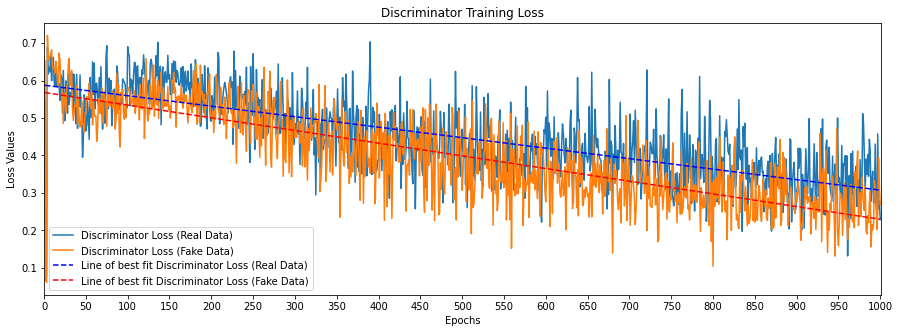

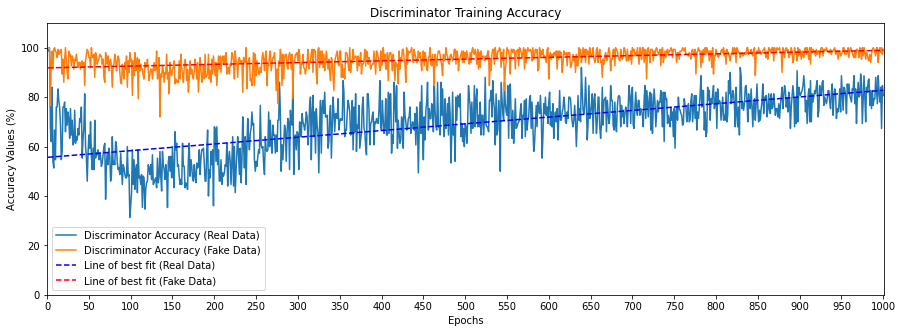

In [14]:
1# Train GAN
def train_gan(generator, discriminator, gan_model, train_x, latent_dim, number_of_epochs=1000, batch_size=128):
    batches_per_epoch = int(train_x.shape[0] / batch_size)
    # Half of batch for real images and half for fake images
    half_batch_size = int(batch_size / 2)
    for i in range(number_of_epochs):
        # Loading bar for each batch in an epoch
        for j in tqdm(range(batches_per_epoch), desc='Epoch %d/%d' % (i+1, number_of_epochs)):
            # Select half_batch_size amount of random real samples from training data
            real_x, real_y = select_real_samples(train_x, half_batch_size)
            # Train discriminator on real images
            d_loss_real, _ = discriminator.train_on_batch(real_x, real_y)

            # Select half_batch_size amount of random fake samples from generated images
            fake_x, fake_y = generate_fake_samples(generator, latent_dim, half_batch_size)
            # Train discriminator on fake images
            d_loss_fake, _ = discriminator.train_on_batch(fake_x, fake_y)

            # Select batch_size amount of random points in the latent space
            gan_x = generate_latent_points(latent_dim, batch_size)
            # Inverted label for each image 
            gan_y = np.ones((batch_size, 1))
            # Update the generator via the discriminators erorr
            g_loss = gan_model.train_on_batch(gan_x, gan_y)
        print('Discriminator Loss (Real Data): %.3f, Discriminator Loss (Fake Data): %.3f, Generator Loss: %.3f' %
              (d_loss_real, d_loss_fake, g_loss))
        
        # Add data from each epoch to these arrays for plotting
        real_x, real_y = select_real_samples(train_x, 150)
        _, d_acc_real = discriminator.evaluate(real_x, real_y, verbose=0)

        fake_x, fake_y = generate_fake_samples(generator, latent_dim, 150)
        _, d_acc_fake = discriminator.evaluate(fake_x, fake_y, verbose=0)

        losses.append((d_loss_real, d_loss_fake))
        accuracies.append((100.0 * d_acc_real, 100.0 * d_acc_fake))
        epochs.append(i + 1)

        # Evaluate GAN every 10 epochs
        if (i + 1) % 10 == 0:
            save_generator(generator, i)
            evaluate_gan(i, generator, discriminator, train_x, latent_dim)

train_x = load_training_data()
train_gan(generator, discriminator, gan_model, train_x, latent_dim)
plot_loss_and_accuracy(losses, accuracies, epochs)